In [ ]:

import os
import cv2
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import MobileNet
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sn


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers, Input
import tensorflow as tf

# Configurar TensorFlow para usar solo la CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Define el directorio de la base de datos CK+
directorio = r'C:\Users\joshu\OneDrive\Desktop\archive'


# Define el mapeo de emociones a etiquetas numéricas basadas en las carpetas
emociones = {
    'anger': 0,
    'contempt': 1,
    'disgust': 2,
    'fear': 3,
    'happy': 4,
    'sadness': 5,
    'surprise': 6
}

# Crear listas para las imágenes y las etiquetas
imagenes_data = []
etiquetas = []

# Recorrer las carpetas de emociones
for emocion, etiqueta in emociones.items():
    carpeta_emocion = os.path.join(directorio, emocion)
    if not os.path.exists(carpeta_emocion):
        continue
    contenido = os.listdir(carpeta_emocion)

    # Cargar imágenes y etiquetas
    for nombre_imagen in contenido:
        ruta_imagen = os.path.join(carpeta_emocion, nombre_imagen)
        if nombre_imagen.endswith(('.png', '.jpg', '.jpeg', '.tiff')):
            imagen_actual = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
            imagen_actual = cv2.resize(imagen_actual, (128, 128))  # Reducir tamaño
            imagen_rgb = cv2.cvtColor(imagen_actual, cv2.COLOR_GRAY2RGB)
            imagen_rgb = imagen_rgb / 255.0  # Normalizar
            imagenes_data.append(imagen_rgb)
            etiquetas.append(etiqueta)

# Convertir listas a arreglos numpy
imagenes_data = np.array(imagenes_data)
etiquetas = np.array(etiquetas)

# Separar los datos en conjuntos de entrenamiento y validación
imagenes_train, imagenes_val, etiquetas_train, etiquetas_val = train_test_split(
    imagenes_data, etiquetas, test_size=0.2, random_state=42
)

# Configurar aumento de datos
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Ajustar el generador al conjunto de entrenamiento
datagen.fit(imagenes_train)

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


# Definir la entrada
input_shape = (128, 128, 3)

model = models.Sequential()

# Primera capa convolucional con Depthwise separable para mantener eficiencia, con menos filtros
model.add(layers.Conv2D(12, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(12, (1, 1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Segunda serie de capas convolucionales, con reducción de filtros
model.add(layers.Conv2D(24, (1, 1), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(24, (1, 1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Bloque final con menos filtros en las convoluciones
model.add(layers.Conv2D(32, (1, 1), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (1, 1), padding='same', activation='relu'))
model.add(layers.GlobalAveragePooling2D())
#la primera conv2d la cambie a 12 era 6

#Modelo con el ultimo bloque con 32 filtros, 48 en la densa, L2 de 0.02 y dropout de 0.3 se ve bien, aun falta bajar mas el loss

# Capas densas finales con Dropout ajustado y menor cantidad de unidades
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.Dropout(0.3))  # Dropout ajustado para reducir sobreajuste
model.add(layers.Dense(7, activation='softmax'))

# Compilación del modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Implementar EarlyStopping y reducción de learning rate en Plateau
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10)


from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Definir un callback personalizado para calcular F1, Precision, y Recall
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.f1s = []
        self.precisions = []
        self.recalls = []

    def on_epoch_end(self, epoch, logs=None):
        val_predicciones = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        val_etiquetas = self.validation_data[1]
        
        f1 = f1_score(val_etiquetas, val_predicciones, average='weighted')
        precision = precision_score(val_etiquetas, val_predicciones, average='weighted')
        recall = recall_score(val_etiquetas, val_predicciones, average='weighted')
        
        self.f1s.append(f1)
        self.precisions.append(precision)
        self.recalls.append(recall)
        
        print(f"Epoch {epoch+1} — F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    # Sobrescribimos el método set_validation_data para obtener el conjunto de validación
    def set_validation_data(self, validation_data):
        self.validation_data = validation_data

# Instanciar el callback y pasar los datos de validación explícitamente
metrics_callback = MetricsCallback()
metrics_callback.set_validation_data((imagenes_val, etiquetas_val))
# Configurar TensorFlow para usar solo la CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
model.summary()

# Entrenar el modelo con el callback
history = model.fit(
    imagenes_train, etiquetas_train,
    validation_data=(imagenes_val, etiquetas_val),
    epochs=1500,
    batch_size=128,
    callbacks=[metrics_callback]
)






Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 6)         168       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 6)         24        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 64, 64, 6)         60        
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 6)         24        
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 6)         42        
                                                        

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.4036 - accuracy: 0.
Epoch 2 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 138ms/step - loss: 2.4032 - accuracy: 0.1059 - val_loss: 2.3150 - val_accuracy: 0.2183
Epoch 3/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.3795 - accuracy: 0.0938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.3849 - accuracy: 0.
Epoch 3 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 136ms/step - loss: 2.3848 - accuracy: 0.1046 - val_loss: 2.3125 - val_accuracy: 0.2183
Epoch 4/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.3701 - accuracy: 0.0781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 8ms/steposs: 2.3807 - accuracy: 0.09
Epoch 4 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 135ms/step - loss: 2.3795 - accuracy: 0.0995 - val_loss: 2.3101 - val_accuracy: 0.2183
Epoch 5/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.3525 - accuracy: 0.1250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.3812 - accuracy: 0.
Epoch 5 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 142ms/step - loss: 2.3836 - accuracy: 0.1148 - val_loss: 2.3077 - val_accuracy: 0.2183
Epoch 6/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.3794 - accuracy: 0.1094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.3739 - accuracy: 0.
Epoch 6 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 144ms/step - loss: 2.3742 - accuracy: 0.0855 - val_loss: 2.3052 - val_accuracy: 0.2183
Epoch 7/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.3717 - accuracy: 0.1406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.3667 - accuracy: 0.
Epoch 7 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.3664 - accuracy: 0.1148 - val_loss: 2.3029 - val_accuracy: 0.2183
Epoch 8/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.3257 - accuracy: 0.1250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.3513 - accuracy: 0.
Epoch 8 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 137ms/step - loss: 2.3518 - accuracy: 0.1135 - val_loss: 2.3007 - val_accuracy: 0.2183
Epoch 9/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.3362 - accuracy: 0.0781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.3425 - accuracy: 0.
Epoch 9 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 135ms/step - loss: 2.3413 - accuracy: 0.1084 - val_loss: 2.2986 - val_accuracy: 0.2183
Epoch 10/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.3645 - accuracy: 0.0859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.3328 - accuracy: 0.
Epoch 10 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.3320 - accuracy: 0.1314 - val_loss: 2.2965 - val_accuracy: 0.2183
Epoch 11/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.3339 - accuracy: 0.0938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.3326 - accuracy: 0.
Epoch 11 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.3321 - accuracy: 0.1276 - val_loss: 2.2944 - val_accuracy: 0.2183
Epoch 12/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.3309 - accuracy: 0.1094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.3154 - accuracy: 0.
Epoch 12 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 135ms/step - loss: 2.3142 - accuracy: 0.1327 - val_loss: 2.2924 - val_accuracy: 0.2183
Epoch 13/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.3165 - accuracy: 0.0938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.3147 - accuracy: 0.
Epoch 13 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 138ms/step - loss: 2.3135 - accuracy: 0.1250 - val_loss: 2.2903 - val_accuracy: 0.2183
Epoch 14/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.3183 - accuracy: 0.1094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.3023 - accuracy: 0.
Epoch 14 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.3042 - accuracy: 0.1327 - val_loss: 2.2879 - val_accuracy: 0.2183
Epoch 15/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.3296 - accuracy: 0.1016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.3041 - accuracy: 0.
Epoch 15 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 140ms/step - loss: 2.3032 - accuracy: 0.1429 - val_loss: 2.2857 - val_accuracy: 0.2183
Epoch 16/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.3264 - accuracy: 0.0938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.3045 - accuracy: 0.
Epoch 16 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 138ms/step - loss: 2.3041 - accuracy: 0.1441 - val_loss: 2.2835 - val_accuracy: 0.2183
Epoch 17/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2764 - accuracy: 0.1484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2885 - accuracy: 0.
Epoch 17 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 137ms/step - loss: 2.2900 - accuracy: 0.1467 - val_loss: 2.2813 - val_accuracy: 0.2183
Epoch 18/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2804 - accuracy: 0.1562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.2946 - accuracy: 0.
Epoch 18 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.2941 - accuracy: 0.1429 - val_loss: 2.2790 - val_accuracy: 0.2183
Epoch 19/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2901 - accuracy: 0.1719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2913 - accuracy: 0.
Epoch 19 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.2911 - accuracy: 0.1441 - val_loss: 2.2766 - val_accuracy: 0.2183
Epoch 20/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2436 - accuracy: 0.2031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2863 - accuracy: 0.
Epoch 20 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 136ms/step - loss: 2.2859 - accuracy: 0.1518 - val_loss: 2.2743 - val_accuracy: 0.2183
Epoch 21/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2932 - accuracy: 0.1484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.2667 - accuracy: 0.
Epoch 21 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.2659 - accuracy: 0.1671 - val_loss: 2.2721 - val_accuracy: 0.2183
Epoch 22/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2877 - accuracy: 0.1797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2631 - accuracy: 0.
Epoch 22 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 136ms/step - loss: 2.2636 - accuracy: 0.1888 - val_loss: 2.2699 - val_accuracy: 0.2183
Epoch 23/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2821 - accuracy: 0.1562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2764 - accuracy: 0.
Epoch 23 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.2758 - accuracy: 0.1518 - val_loss: 2.2679 - val_accuracy: 0.2183
Epoch 24/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2550 - accuracy: 0.1797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.2575 - accuracy: 0.
Epoch 24 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 132ms/step - loss: 2.2575 - accuracy: 0.1798 - val_loss: 2.2657 - val_accuracy: 0.2183
Epoch 25/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2379 - accuracy: 0.1797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2518 - accuracy: 0.
Epoch 25 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.2544 - accuracy: 0.1824 - val_loss: 2.2635 - val_accuracy: 0.2183
Epoch 26/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2489 - accuracy: 0.2031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2443 - accuracy: 0.
Epoch 26 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 132ms/step - loss: 2.2427 - accuracy: 0.1939 - val_loss: 2.2614 - val_accuracy: 0.2183
Epoch 27/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2467 - accuracy: 0.2109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.2502 - accuracy: 0.
Epoch 27 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 136ms/step - loss: 2.2502 - accuracy: 0.2117 - val_loss: 2.2593 - val_accuracy: 0.2183
Epoch 28/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2403 - accuracy: 0.1484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2432 - accuracy: 0.
Epoch 28 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.2420 - accuracy: 0.1862 - val_loss: 2.2571 - val_accuracy: 0.2183
Epoch 29/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2368 - accuracy: 0.2109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.2413 - accuracy: 0.
Epoch 29 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.2411 - accuracy: 0.1837 - val_loss: 2.2550 - val_accuracy: 0.2183
Epoch 30/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2324 - accuracy: 0.1719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2430 - accuracy: 0.
Epoch 30 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 137ms/step - loss: 2.2433 - accuracy: 0.1862 - val_loss: 2.2530 - val_accuracy: 0.2183
Epoch 31/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2148 - accuracy: 0.2109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.2260 - accuracy: 0.
Epoch 31 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 132ms/step - loss: 2.2271 - accuracy: 0.2028 - val_loss: 2.2510 - val_accuracy: 0.2183
Epoch 32/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2260 - accuracy: 0.2031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.2253 - accuracy: 0.
Epoch 32 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.2244 - accuracy: 0.1913 - val_loss: 2.2490 - val_accuracy: 0.2183
Epoch 33/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2442 - accuracy: 0.2031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2267 - accuracy: 0.
Epoch 33 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.2281 - accuracy: 0.2181 - val_loss: 2.2470 - val_accuracy: 0.2183
Epoch 34/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1960 - accuracy: 0.2188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.2174 - accuracy: 0.
Epoch 34 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.2167 - accuracy: 0.2117 - val_loss: 2.2452 - val_accuracy: 0.2183
Epoch 35/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2332 - accuracy: 0.2109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2111 - accuracy: 0.
Epoch 35 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.2128 - accuracy: 0.2054 - val_loss: 2.2434 - val_accuracy: 0.2183
Epoch 36/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2100 - accuracy: 0.2422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2049 - accuracy: 0.
Epoch 36 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.2032 - accuracy: 0.2385 - val_loss: 2.2419 - val_accuracy: 0.2183
Epoch 37/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2098 - accuracy: 0.2266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2025 - accuracy: 0.
Epoch 37 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.2025 - accuracy: 0.2143 - val_loss: 2.2401 - val_accuracy: 0.2183
Epoch 38/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2322 - accuracy: 0.1875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2106 - accuracy: 0.
Epoch 38 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 136ms/step - loss: 2.2101 - accuracy: 0.2130 - val_loss: 2.2384 - val_accuracy: 0.2183
Epoch 39/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2152 - accuracy: 0.2578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.2032 - accuracy: 0.
Epoch 39 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.2026 - accuracy: 0.2296 - val_loss: 2.2366 - val_accuracy: 0.2183
Epoch 40/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1672 - accuracy: 0.2266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1920 - accuracy: 0.
Epoch 40 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.1919 - accuracy: 0.2258 - val_loss: 2.2348 - val_accuracy: 0.2183
Epoch 41/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1872 - accuracy: 0.2422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.1984 - accuracy: 0.
Epoch 41 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 135ms/step - loss: 2.1975 - accuracy: 0.2347 - val_loss: 2.2330 - val_accuracy: 0.2183
Epoch 42/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1852 - accuracy: 0.2344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.1962 - accuracy: 0.
Epoch 42 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 136ms/step - loss: 2.1958 - accuracy: 0.2168 - val_loss: 2.2312 - val_accuracy: 0.2183
Epoch 43/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1717 - accuracy: 0.2500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1851 - accuracy: 0.
Epoch 43 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.1849 - accuracy: 0.2181 - val_loss: 2.2295 - val_accuracy: 0.2183
Epoch 44/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1525 - accuracy: 0.2812

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.1791 - accuracy: 0.
Epoch 44 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.1782 - accuracy: 0.2296 - val_loss: 2.2278 - val_accuracy: 0.2183
Epoch 45/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1852 - accuracy: 0.2656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1793 - accuracy: 0.
Epoch 45 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 132ms/step - loss: 2.1795 - accuracy: 0.2423 - val_loss: 2.2263 - val_accuracy: 0.2183
Epoch 46/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1828 - accuracy: 0.1953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1877 - accuracy: 0.
Epoch 46 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 136ms/step - loss: 2.1889 - accuracy: 0.2168 - val_loss: 2.2249 - val_accuracy: 0.2183
Epoch 47/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2016 - accuracy: 0.1797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.1858 - accuracy: 0.
Epoch 47 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 136ms/step - loss: 2.1856 - accuracy: 0.2219 - val_loss: 2.2237 - val_accuracy: 0.2183
Epoch 48/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1469 - accuracy: 0.2422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1803 - accuracy: 0.
Epoch 48 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 137ms/step - loss: 2.1816 - accuracy: 0.2143 - val_loss: 2.2226 - val_accuracy: 0.2183
Epoch 49/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1866 - accuracy: 0.2500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1825 - accuracy: 0.
Epoch 49 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 136ms/step - loss: 2.1826 - accuracy: 0.2347 - val_loss: 2.2217 - val_accuracy: 0.2183
Epoch 50/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1858 - accuracy: 0.2109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.1693 - accuracy: 0.
Epoch 50 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 132ms/step - loss: 2.1699 - accuracy: 0.2232 - val_loss: 2.2209 - val_accuracy: 0.2183
Epoch 51/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1674 - accuracy: 0.2500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.1676 - accuracy: 0.
Epoch 51 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.1632 - accuracy: 0.2449 - val_loss: 2.2200 - val_accuracy: 0.2183
Epoch 52/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1654 - accuracy: 0.2656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1596 - accuracy: 0.
Epoch 52 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.1581 - accuracy: 0.2640 - val_loss: 2.2188 - val_accuracy: 0.2183
Epoch 53/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1466 - accuracy: 0.2656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.1515 - accuracy: 0.
Epoch 53 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.1531 - accuracy: 0.2296 - val_loss: 2.2177 - val_accuracy: 0.2183
Epoch 54/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1812 - accuracy: 0.2109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.1543 - accuracy: 0.
Epoch 54 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 137ms/step - loss: 2.1536 - accuracy: 0.2334 - val_loss: 2.2167 - val_accuracy: 0.2183
Epoch 55/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1425 - accuracy: 0.2656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1552 - accuracy: 0.
Epoch 55 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 135ms/step - loss: 2.1529 - accuracy: 0.2487 - val_loss: 2.2155 - val_accuracy: 0.2183
Epoch 56/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1664 - accuracy: 0.2188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1495 - accuracy: 0.
Epoch 56 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 135ms/step - loss: 2.1492 - accuracy: 0.2551 - val_loss: 2.2143 - val_accuracy: 0.2183
Epoch 57/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1433 - accuracy: 0.2500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1445 - accuracy: 0.
Epoch 57 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.1448 - accuracy: 0.2462 - val_loss: 2.2132 - val_accuracy: 0.2183
Epoch 58/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1577 - accuracy: 0.2500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.1487 - accuracy: 0.
Epoch 58 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.1490 - accuracy: 0.2398 - val_loss: 2.2125 - val_accuracy: 0.2183
Epoch 59/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.2008 - accuracy: 0.2188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.1476 - accuracy: 0.
Epoch 59 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 136ms/step - loss: 2.1481 - accuracy: 0.2360 - val_loss: 2.2119 - val_accuracy: 0.2183
Epoch 60/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1258 - accuracy: 0.2188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1431 - accuracy: 0.
Epoch 60 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.1428 - accuracy: 0.2270 - val_loss: 2.2110 - val_accuracy: 0.2183
Epoch 61/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1287 - accuracy: 0.2266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1467 - accuracy: 0.
Epoch 61 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 137ms/step - loss: 2.1464 - accuracy: 0.2321 - val_loss: 2.2099 - val_accuracy: 0.2183
Epoch 62/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1016 - accuracy: 0.2812

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1538 - accuracy: 0.
Epoch 62 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 136ms/step - loss: 2.1514 - accuracy: 0.2296 - val_loss: 2.2087 - val_accuracy: 0.2183
Epoch 63/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1398 - accuracy: 0.3203

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1325 - accuracy: 0.
Epoch 63 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 136ms/step - loss: 2.1364 - accuracy: 0.2487 - val_loss: 2.2074 - val_accuracy: 0.2183
Epoch 64/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1263 - accuracy: 0.2422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1360 - accuracy: 0.
Epoch 64 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.1331 - accuracy: 0.2372 - val_loss: 2.2060 - val_accuracy: 0.2183
Epoch 65/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1204 - accuracy: 0.2578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.1213 - accuracy: 0.
Epoch 65 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 132ms/step - loss: 2.1246 - accuracy: 0.2526 - val_loss: 2.2041 - val_accuracy: 0.2183
Epoch 66/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1443 - accuracy: 0.2734

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1263 - accuracy: 0.
Epoch 66 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.1276 - accuracy: 0.2423 - val_loss: 2.2021 - val_accuracy: 0.2183
Epoch 67/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1607 - accuracy: 0.2109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1387 - accuracy: 0.
Epoch 67 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 138ms/step - loss: 2.1342 - accuracy: 0.2551 - val_loss: 2.2002 - val_accuracy: 0.2183
Epoch 68/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1729 - accuracy: 0.1875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1258 - accuracy: 0.
Epoch 68 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 135ms/step - loss: 2.1268 - accuracy: 0.2551 - val_loss: 2.1977 - val_accuracy: 0.2183
Epoch 69/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1123 - accuracy: 0.2422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1202 - accuracy: 0.
Epoch 69 — F1: 0.0782, Precision: 0.0476, Recall: 0.2183
7/7 [==============================] - 1s 133ms/step - loss: 2.1207 - accuracy: 0.2411 - val_loss: 2.1956 - val_accuracy: 0.2183
Epoch 70/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1531 - accuracy: 0.2734

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1224 - accuracy: 0.
Epoch 70 — F1: 0.0885, Precision: 0.2662, Recall: 0.2234
7/7 [==============================] - 1s 137ms/step - loss: 2.1234 - accuracy: 0.2411 - val_loss: 2.1931 - val_accuracy: 0.2234
Epoch 71/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1466 - accuracy: 0.2578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1098 - accuracy: 0.
Epoch 71 — F1: 0.0885, Precision: 0.2662, Recall: 0.2234
7/7 [==============================] - 1s 135ms/step - loss: 2.1098 - accuracy: 0.2487 - val_loss: 2.1895 - val_accuracy: 0.2234
Epoch 72/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1205 - accuracy: 0.2344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.1221 - accuracy: 0.
Epoch 72 — F1: 0.0871, Precision: 0.1564, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.1233 - accuracy: 0.2258 - val_loss: 2.1861 - val_accuracy: 0.2183
Epoch 73/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1279 - accuracy: 0.2500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1282 - accuracy: 0.
Epoch 73 — F1: 0.0871, Precision: 0.1564, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.1304 - accuracy: 0.2347 - val_loss: 2.1836 - val_accuracy: 0.2183
Epoch 74/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1370 - accuracy: 0.2031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1117 - accuracy: 0.
Epoch 74 — F1: 0.0871, Precision: 0.1564, Recall: 0.2183
7/7 [==============================] - 1s 137ms/step - loss: 2.1123 - accuracy: 0.2398 - val_loss: 2.1793 - val_accuracy: 0.2183
Epoch 75/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1102 - accuracy: 0.2578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.1028 - accuracy: 0.
Epoch 75 — F1: 0.0947, Precision: 0.1342, Recall: 0.2183
7/7 [==============================] - 1s 137ms/step - loss: 2.1034 - accuracy: 0.2742 - val_loss: 2.1758 - val_accuracy: 0.2183
Epoch 76/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1065 - accuracy: 0.2266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.1023 - accuracy: 0.
Epoch 76 — F1: 0.1121, Precision: 0.1721, Recall: 0.2284
7/7 [==============================] - 1s 134ms/step - loss: 2.1022 - accuracy: 0.2589 - val_loss: 2.1740 - val_accuracy: 0.2284
Epoch 77/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0374 - accuracy: 0.3203

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0948 - accuracy: 0.
Epoch 77 — F1: 0.1121, Precision: 0.1721, Recall: 0.2284
7/7 [==============================] - 1s 136ms/step - loss: 2.0934 - accuracy: 0.2526 - val_loss: 2.1700 - val_accuracy: 0.2284
Epoch 78/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1066 - accuracy: 0.2188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0976 - accuracy: 0.
Epoch 78 — F1: 0.1079, Precision: 0.1428, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.0981 - accuracy: 0.2640 - val_loss: 2.1658 - val_accuracy: 0.2183
Epoch 79/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1361 - accuracy: 0.2656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0881 - accuracy: 0.
Epoch 79 — F1: 0.1073, Precision: 0.1256, Recall: 0.2183
7/7 [==============================] - 1s 134ms/step - loss: 2.0865 - accuracy: 0.2768 - val_loss: 2.1633 - val_accuracy: 0.2183
Epoch 80/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1322 - accuracy: 0.2266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0960 - accuracy: 0.
Epoch 80 — F1: 0.1096, Precision: 0.1265, Recall: 0.2081
7/7 [==============================] - 1s 139ms/step - loss: 2.0937 - accuracy: 0.2589 - val_loss: 2.1595 - val_accuracy: 0.2081
Epoch 81/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0956 - accuracy: 0.2969

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0895 - accuracy: 0.
Epoch 81 — F1: 0.1134, Precision: 0.1052, Recall: 0.2132
7/7 [==============================] - 1s 139ms/step - loss: 2.0876 - accuracy: 0.2717 - val_loss: 2.1524 - val_accuracy: 0.2132
Epoch 82/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1026 - accuracy: 0.2422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0859 - accuracy: 0.
Epoch 82 — F1: 0.1310, Precision: 0.1198, Recall: 0.2284
7/7 [==============================] - 1s 136ms/step - loss: 2.0862 - accuracy: 0.2717 - val_loss: 2.1491 - val_accuracy: 0.2284
Epoch 83/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0819 - accuracy: 0.2969

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0913 - accuracy: 0.
Epoch 83 — F1: 0.1450, Precision: 0.1314, Recall: 0.2386
7/7 [==============================] - 1s 135ms/step - loss: 2.0898 - accuracy: 0.2564 - val_loss: 2.1454 - val_accuracy: 0.2386
Epoch 84/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.1146 - accuracy: 0.2734

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.0871 - accuracy: 0.
Epoch 84 — F1: 0.1460, Precision: 0.1255, Recall: 0.2335
7/7 [==============================] - 1s 134ms/step - loss: 2.0863 - accuracy: 0.2551 - val_loss: 2.1407 - val_accuracy: 0.2335
Epoch 85/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0534 - accuracy: 0.2891

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.0778 - accuracy: 0.
Epoch 85 — F1: 0.1631, Precision: 0.1362, Recall: 0.2538
7/7 [==============================] - 1s 137ms/step - loss: 2.0770 - accuracy: 0.2781 - val_loss: 2.1390 - val_accuracy: 0.2538
Epoch 86/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0973 - accuracy: 0.2188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0780 - accuracy: 0.
Epoch 86 — F1: 0.1661, Precision: 0.1361, Recall: 0.2589
7/7 [==============================] - 1s 134ms/step - loss: 2.0786 - accuracy: 0.2666 - val_loss: 2.1345 - val_accuracy: 0.2589
Epoch 87/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0359 - accuracy: 0.3906

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0759 - accuracy: 0.
Epoch 87 — F1: 0.1680, Precision: 0.1344, Recall: 0.2640
7/7 [==============================] - 1s 137ms/step - loss: 2.0781 - accuracy: 0.2602 - val_loss: 2.1292 - val_accuracy: 0.2640
Epoch 88/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0594 - accuracy: 0.3125

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0761 - accuracy: 0.
Epoch 88 — F1: 0.1643, Precision: 0.1318, Recall: 0.2589
7/7 [==============================] - 1s 136ms/step - loss: 2.0762 - accuracy: 0.2615 - val_loss: 2.1280 - val_accuracy: 0.2589
Epoch 89/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0158 - accuracy: 0.2734

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.0843 - accuracy: 0.
Epoch 89 — F1: 0.1655, Precision: 0.1305, Recall: 0.2589
7/7 [==============================] - 1s 134ms/step - loss: 2.0842 - accuracy: 0.2628 - val_loss: 2.1226 - val_accuracy: 0.2589
Epoch 90/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0724 - accuracy: 0.2656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0759 - accuracy: 0.
Epoch 90 — F1: 0.1815, Precision: 0.3589, Recall: 0.2741
7/7 [==============================] - 1s 135ms/step - loss: 2.0770 - accuracy: 0.2666 - val_loss: 2.1166 - val_accuracy: 0.2741
Epoch 91/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0815 - accuracy: 0.2734

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0636 - accuracy: 0.
Epoch 91 — F1: 0.1739, Precision: 0.2357, Recall: 0.2640
7/7 [==============================] - 1s 134ms/step - loss: 2.0643 - accuracy: 0.2819 - val_loss: 2.1134 - val_accuracy: 0.2640
Epoch 92/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0818 - accuracy: 0.2578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0696 - accuracy: 0.
Epoch 92 — F1: 0.1933, Precision: 0.1871, Recall: 0.2843
7/7 [==============================] - 1s 134ms/step - loss: 2.0713 - accuracy: 0.2666 - val_loss: 2.1097 - val_accuracy: 0.2843
Epoch 93/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0809 - accuracy: 0.2656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0547 - accuracy: 0.
Epoch 93 — F1: 0.1973, Precision: 0.1953, Recall: 0.2843
7/7 [==============================] - 1s 138ms/step - loss: 2.0506 - accuracy: 0.2946 - val_loss: 2.1046 - val_accuracy: 0.2843
Epoch 94/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0775 - accuracy: 0.2344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0626 - accuracy: 0.
Epoch 94 — F1: 0.2110, Precision: 0.2141, Recall: 0.2995
7/7 [==============================] - 1s 136ms/step - loss: 2.0640 - accuracy: 0.2832 - val_loss: 2.0979 - val_accuracy: 0.2995
Epoch 95/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0504 - accuracy: 0.2734

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0523 - accuracy: 0.
Epoch 95 — F1: 0.2203, Precision: 0.2286, Recall: 0.3046
7/7 [==============================] - 1s 134ms/step - loss: 2.0553 - accuracy: 0.2819 - val_loss: 2.0940 - val_accuracy: 0.3046
Epoch 96/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0489 - accuracy: 0.2891

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0547 - accuracy: 0.
Epoch 96 — F1: 0.2216, Precision: 0.2283, Recall: 0.2995
7/7 [==============================] - 1s 135ms/step - loss: 2.0536 - accuracy: 0.2806 - val_loss: 2.0944 - val_accuracy: 0.2995
Epoch 97/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0137 - accuracy: 0.3359

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0636 - accuracy: 0.
Epoch 97 — F1: 0.2212, Precision: 0.2276, Recall: 0.2995
7/7 [==============================] - 1s 135ms/step - loss: 2.0636 - accuracy: 0.2985 - val_loss: 2.0892 - val_accuracy: 0.2995
Epoch 98/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0793 - accuracy: 0.2188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0528 - accuracy: 0.
Epoch 98 — F1: 0.2188, Precision: 0.2200, Recall: 0.3046
7/7 [==============================] - 1s 135ms/step - loss: 2.0542 - accuracy: 0.2730 - val_loss: 2.0832 - val_accuracy: 0.3046
Epoch 99/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0761 - accuracy: 0.2734

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0423 - accuracy: 0.
Epoch 99 — F1: 0.2207, Precision: 0.2276, Recall: 0.3096
7/7 [==============================] - 1s 135ms/step - loss: 2.0452 - accuracy: 0.2972 - val_loss: 2.0765 - val_accuracy: 0.3096
Epoch 100/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0341 - accuracy: 0.2891

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.0395 - accuracy: 0.
Epoch 100 — F1: 0.2125, Precision: 0.2224, Recall: 0.3046
7/7 [==============================] - 1s 136ms/step - loss: 2.0399 - accuracy: 0.2921 - val_loss: 2.0724 - val_accuracy: 0.3046
Epoch 101/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0739 - accuracy: 0.2891

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0453 - accuracy: 0.
Epoch 101 — F1: 0.2461, Precision: 0.2515, Recall: 0.3299
7/7 [==============================] - 1s 137ms/step - loss: 2.0453 - accuracy: 0.2985 - val_loss: 2.0691 - val_accuracy: 0.3299
Epoch 102/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0723 - accuracy: 0.2969

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0528 - accuracy: 0.
Epoch 102 — F1: 0.2590, Precision: 0.2564, Recall: 0.3350
7/7 [==============================] - 1s 134ms/step - loss: 2.0551 - accuracy: 0.2844 - val_loss: 2.0640 - val_accuracy: 0.3350
Epoch 103/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0624 - accuracy: 0.3281

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.0293 - accuracy: 0.
Epoch 103 — F1: 0.2711, Precision: 0.2628, Recall: 0.3452
7/7 [==============================] - 1s 136ms/step - loss: 2.0307 - accuracy: 0.3112 - val_loss: 2.0623 - val_accuracy: 0.3452
Epoch 104/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0996 - accuracy: 0.2656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0491 - accuracy: 0.
Epoch 104 — F1: 0.2653, Precision: 0.2574, Recall: 0.3401
7/7 [==============================] - 1s 134ms/step - loss: 2.0465 - accuracy: 0.2972 - val_loss: 2.0603 - val_accuracy: 0.3401
Epoch 105/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0124 - accuracy: 0.3203

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0264 - accuracy: 0.
Epoch 105 — F1: 0.2764, Precision: 0.2671, Recall: 0.3503
7/7 [==============================] - 1s 137ms/step - loss: 2.0248 - accuracy: 0.3202 - val_loss: 2.0540 - val_accuracy: 0.3503
Epoch 106/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0098 - accuracy: 0.3047

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 13ms/stepss: 2.0312 - accuracy: 0.
Epoch 106 — F1: 0.2756, Precision: 0.2667, Recall: 0.3503
7/7 [==============================] - 1s 138ms/step - loss: 2.0293 - accuracy: 0.3329 - val_loss: 2.0496 - val_accuracy: 0.3503
Epoch 107/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0625 - accuracy: 0.2969

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0224 - accuracy: 0.
Epoch 107 — F1: 0.2787, Precision: 0.2698, Recall: 0.3553
7/7 [==============================] - 1s 134ms/step - loss: 2.0234 - accuracy: 0.3329 - val_loss: 2.0456 - val_accuracy: 0.3553
Epoch 108/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0655 - accuracy: 0.2891

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.0295 - accuracy: 0.
Epoch 108 — F1: 0.2875, Precision: 0.2768, Recall: 0.3655
7/7 [==============================] - 1s 136ms/step - loss: 2.0271 - accuracy: 0.3099 - val_loss: 2.0424 - val_accuracy: 0.3655
Epoch 109/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0342 - accuracy: 0.3359

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.0263 - accuracy: 0.
Epoch 109 — F1: 0.2798, Precision: 0.2723, Recall: 0.3553
7/7 [==============================] - 1s 136ms/step - loss: 2.0264 - accuracy: 0.3444 - val_loss: 2.0322 - val_accuracy: 0.3553
Epoch 110/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0221 - accuracy: 0.3125

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0157 - accuracy: 0.
Epoch 110 — F1: 0.2845, Precision: 0.2761, Recall: 0.3604
7/7 [==============================] - 1s 135ms/step - loss: 2.0175 - accuracy: 0.3329 - val_loss: 2.0312 - val_accuracy: 0.3604
Epoch 111/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0054 - accuracy: 0.3438

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0195 - accuracy: 0.
Epoch 111 — F1: 0.2955, Precision: 0.2819, Recall: 0.3706
7/7 [==============================] - 1s 133ms/step - loss: 2.0188 - accuracy: 0.3380 - val_loss: 2.0279 - val_accuracy: 0.3706
Epoch 112/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0115 - accuracy: 0.2891

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0241 - accuracy: 0.
Epoch 112 — F1: 0.2985, Precision: 0.2842, Recall: 0.3706
7/7 [==============================] - 1s 136ms/step - loss: 2.0261 - accuracy: 0.3176 - val_loss: 2.0280 - val_accuracy: 0.3706
Epoch 113/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0255 - accuracy: 0.2891

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0177 - accuracy: 0.
Epoch 113 — F1: 0.2934, Precision: 0.2812, Recall: 0.3655
7/7 [==============================] - 1s 138ms/step - loss: 2.0168 - accuracy: 0.3099 - val_loss: 2.0222 - val_accuracy: 0.3655
Epoch 114/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0577 - accuracy: 0.2812

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0206 - accuracy: 0.
Epoch 114 — F1: 0.2986, Precision: 0.2849, Recall: 0.3706
7/7 [==============================] - 1s 134ms/step - loss: 2.0202 - accuracy: 0.3418 - val_loss: 2.0211 - val_accuracy: 0.3706
Epoch 115/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0430 - accuracy: 0.3281

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0304 - accuracy: 0.
Epoch 115 — F1: 0.3044, Precision: 0.2881, Recall: 0.3756
7/7 [==============================] - 1s 136ms/step - loss: 2.0276 - accuracy: 0.3214 - val_loss: 2.0157 - val_accuracy: 0.3756
Epoch 116/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0687 - accuracy: 0.2500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.0126 - accuracy: 0.
Epoch 116 — F1: 0.3070, Precision: 0.2840, Recall: 0.3807
7/7 [==============================] - 1s 134ms/step - loss: 2.0110 - accuracy: 0.3176 - val_loss: 2.0133 - val_accuracy: 0.3807
Epoch 117/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9895 - accuracy: 0.3516

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9994 - accuracy: 0.
Epoch 117 — F1: 0.3122, Precision: 0.2869, Recall: 0.3858
7/7 [==============================] - 1s 137ms/step - loss: 1.9966 - accuracy: 0.3355 - val_loss: 2.0131 - val_accuracy: 0.3858
Epoch 118/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9734 - accuracy: 0.3125

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0064 - accuracy: 0.
Epoch 118 — F1: 0.3093, Precision: 0.3086, Recall: 0.3756
7/7 [==============================] - 1s 135ms/step - loss: 2.0042 - accuracy: 0.3329 - val_loss: 2.0062 - val_accuracy: 0.3756
Epoch 119/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9788 - accuracy: 0.3281

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0147 - accuracy: 0.
Epoch 119 — F1: 0.2889, Precision: 0.2797, Recall: 0.3604
7/7 [==============================] - 1s 142ms/step - loss: 2.0178 - accuracy: 0.3125 - val_loss: 2.0010 - val_accuracy: 0.3604
Epoch 120/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0268 - accuracy: 0.3125

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 2.0124 - accuracy: 0.
Epoch 120 — F1: 0.2889, Precision: 0.2797, Recall: 0.3604
7/7 [==============================] - 1s 137ms/step - loss: 2.0122 - accuracy: 0.3061 - val_loss: 1.9975 - val_accuracy: 0.3604
Epoch 121/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0140 - accuracy: 0.3438

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 2.0098 - accuracy: 0.
Epoch 121 — F1: 0.3031, Precision: 0.2908, Recall: 0.3756
7/7 [==============================] - 1s 136ms/step - loss: 2.0083 - accuracy: 0.3265 - val_loss: 1.9954 - val_accuracy: 0.3756
Epoch 122/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9470 - accuracy: 0.3672

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9925 - accuracy: 0.
Epoch 122 — F1: 0.2983, Precision: 0.2864, Recall: 0.3706
7/7 [==============================] - 1s 134ms/step - loss: 1.9890 - accuracy: 0.3431 - val_loss: 1.9912 - val_accuracy: 0.3706
Epoch 123/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9690 - accuracy: 0.3672

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9864 - accuracy: 0.
Epoch 123 — F1: 0.2993, Precision: 0.2882, Recall: 0.3706
7/7 [==============================] - 1s 135ms/step - loss: 1.9888 - accuracy: 0.3418 - val_loss: 1.9863 - val_accuracy: 0.3706
Epoch 124/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0084 - accuracy: 0.3281

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.9912 - accuracy: 0.
Epoch 124 — F1: 0.3086, Precision: 0.2935, Recall: 0.3807
7/7 [==============================] - 1s 134ms/step - loss: 1.9909 - accuracy: 0.3329 - val_loss: 1.9867 - val_accuracy: 0.3807
Epoch 125/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9808 - accuracy: 0.3828

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9784 - accuracy: 0.
Epoch 125 — F1: 0.3164, Precision: 0.2942, Recall: 0.3909
7/7 [==============================] - 1s 139ms/step - loss: 1.9750 - accuracy: 0.3750 - val_loss: 1.9873 - val_accuracy: 0.3909
Epoch 126/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9718 - accuracy: 0.3750

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9743 - accuracy: 0.
Epoch 126 — F1: 0.3029, Precision: 0.2872, Recall: 0.3756
7/7 [==============================] - 1s 135ms/step - loss: 1.9765 - accuracy: 0.3546 - val_loss: 1.9775 - val_accuracy: 0.3756
Epoch 127/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9998 - accuracy: 0.2734

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 11ms/stepss: 1.9986 - accuracy: 0.
Epoch 127 — F1: 0.3134, Precision: 0.2979, Recall: 0.3909
7/7 [==============================] - 1s 135ms/step - loss: 1.9988 - accuracy: 0.3265 - val_loss: 1.9727 - val_accuracy: 0.3909
Epoch 128/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0099 - accuracy: 0.3359

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9942 - accuracy: 0.
Epoch 128 — F1: 0.3136, Precision: 0.2971, Recall: 0.3858
7/7 [==============================] - 1s 134ms/step - loss: 1.9927 - accuracy: 0.3559 - val_loss: 1.9748 - val_accuracy: 0.3858
Epoch 129/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9514 - accuracy: 0.3906

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.9770 - accuracy: 0.
Epoch 129 — F1: 0.3073, Precision: 0.2947, Recall: 0.3807
7/7 [==============================] - 1s 136ms/step - loss: 1.9798 - accuracy: 0.3648 - val_loss: 1.9697 - val_accuracy: 0.3807
Epoch 130/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9478 - accuracy: 0.3438

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9733 - accuracy: 0.
Epoch 130 — F1: 0.3142, Precision: 0.3012, Recall: 0.3909
7/7 [==============================] - 1s 136ms/step - loss: 1.9746 - accuracy: 0.3508 - val_loss: 1.9666 - val_accuracy: 0.3909
Epoch 131/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9646 - accuracy: 0.4219

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.9705 - accuracy: 0.
Epoch 131 — F1: 0.3099, Precision: 0.2939, Recall: 0.3807
7/7 [==============================] - 1s 136ms/step - loss: 1.9665 - accuracy: 0.3776 - val_loss: 1.9705 - val_accuracy: 0.3807
Epoch 132/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9491 - accuracy: 0.4219

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.9604 - accuracy: 0.
Epoch 132 — F1: 0.3138, Precision: 0.2937, Recall: 0.3858
7/7 [==============================] - 1s 137ms/step - loss: 1.9606 - accuracy: 0.3546 - val_loss: 1.9683 - val_accuracy: 0.3858
Epoch 133/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0390 - accuracy: 0.2500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9727 - accuracy: 0.
Epoch 133 — F1: 0.3215, Precision: 0.3012, Recall: 0.3959
7/7 [==============================] - 1s 138ms/step - loss: 1.9702 - accuracy: 0.3469 - val_loss: 1.9632 - val_accuracy: 0.3959
Epoch 134/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9623 - accuracy: 0.3594

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.9579 - accuracy: 0.
Epoch 134 — F1: 0.3199, Precision: 0.2987, Recall: 0.3959
7/7 [==============================] - 1s 133ms/step - loss: 1.9562 - accuracy: 0.3661 - val_loss: 1.9597 - val_accuracy: 0.3959
Epoch 135/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9844 - accuracy: 0.3359

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9686 - accuracy: 0.
Epoch 135 — F1: 0.3369, Precision: 0.3239, Recall: 0.4112
7/7 [==============================] - 1s 135ms/step - loss: 1.9699 - accuracy: 0.3495 - val_loss: 1.9582 - val_accuracy: 0.4112
Epoch 136/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9727 - accuracy: 0.3125

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.9618 - accuracy: 0.
Epoch 136 — F1: 0.3190, Precision: 0.3098, Recall: 0.3909
7/7 [==============================] - 1s 135ms/step - loss: 1.9608 - accuracy: 0.3520 - val_loss: 1.9556 - val_accuracy: 0.3909
Epoch 137/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9161 - accuracy: 0.4141

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9520 - accuracy: 0.
Epoch 137 — F1: 0.3142, Precision: 0.2972, Recall: 0.3909
7/7 [==============================] - 1s 136ms/step - loss: 1.9533 - accuracy: 0.3699 - val_loss: 1.9529 - val_accuracy: 0.3909
Epoch 138/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9126 - accuracy: 0.3672

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.9530 - accuracy: 0.
Epoch 138 — F1: 0.3394, Precision: 0.3201, Recall: 0.4162
7/7 [==============================] - 1s 136ms/step - loss: 1.9552 - accuracy: 0.3686 - val_loss: 1.9525 - val_accuracy: 0.4162
Epoch 139/1500
1/7 [===>..........................] - ETA: 0s - loss: 2.0182 - accuracy: 0.2656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.9419 - accuracy: 0.
Epoch 139 — F1: 0.3360, Precision: 0.3274, Recall: 0.4162
7/7 [==============================] - 1s 137ms/step - loss: 1.9414 - accuracy: 0.3737 - val_loss: 1.9482 - val_accuracy: 0.4162
Epoch 140/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9178 - accuracy: 0.3750

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9514 - accuracy: 0.
Epoch 140 — F1: 0.3462, Precision: 0.3294, Recall: 0.4213
7/7 [==============================] - 1s 135ms/step - loss: 1.9517 - accuracy: 0.3673 - val_loss: 1.9495 - val_accuracy: 0.4213
Epoch 141/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9399 - accuracy: 0.4141

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9391 - accuracy: 0.
Epoch 141 — F1: 0.3386, Precision: 0.3180, Recall: 0.4162
7/7 [==============================] - 1s 138ms/step - loss: 1.9410 - accuracy: 0.3737 - val_loss: 1.9430 - val_accuracy: 0.4162
Epoch 142/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8911 - accuracy: 0.4297

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9493 - accuracy: 0.
Epoch 142 — F1: 0.3326, Precision: 0.3096, Recall: 0.4112
7/7 [==============================] - 1s 135ms/step - loss: 1.9499 - accuracy: 0.3686 - val_loss: 1.9377 - val_accuracy: 0.4112
Epoch 143/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9095 - accuracy: 0.3828

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.9317 - accuracy: 0.
Epoch 143 — F1: 0.3558, Precision: 0.3385, Recall: 0.4315
7/7 [==============================] - 1s 139ms/step - loss: 1.9332 - accuracy: 0.3788 - val_loss: 1.9376 - val_accuracy: 0.4315
Epoch 144/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9344 - accuracy: 0.4141

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9284 - accuracy: 0.
Epoch 144 — F1: 0.3521, Precision: 0.3362, Recall: 0.4264
7/7 [==============================] - 1s 137ms/step - loss: 1.9283 - accuracy: 0.3890 - val_loss: 1.9371 - val_accuracy: 0.4264
Epoch 145/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9721 - accuracy: 0.3203

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9397 - accuracy: 0.
Epoch 145 — F1: 0.3499, Precision: 0.3252, Recall: 0.4264
7/7 [==============================] - 1s 139ms/step - loss: 1.9383 - accuracy: 0.3686 - val_loss: 1.9372 - val_accuracy: 0.4264
Epoch 146/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9258 - accuracy: 0.3750

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9341 - accuracy: 0.
Epoch 146 — F1: 0.3483, Precision: 0.3165, Recall: 0.4213
7/7 [==============================] - 1s 135ms/step - loss: 1.9341 - accuracy: 0.3661 - val_loss: 1.9377 - val_accuracy: 0.4213
Epoch 147/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9099 - accuracy: 0.4297

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 11ms/stepss: 1.9179 - accuracy: 0.
Epoch 147 — F1: 0.3437, Precision: 0.3132, Recall: 0.4213
7/7 [==============================] - 1s 136ms/step - loss: 1.9151 - accuracy: 0.3954 - val_loss: 1.9289 - val_accuracy: 0.4213
Epoch 148/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9625 - accuracy: 0.3438

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9467 - accuracy: 0.
Epoch 148 — F1: 0.3422, Precision: 0.3117, Recall: 0.4213
7/7 [==============================] - 1s 135ms/step - loss: 1.9444 - accuracy: 0.3559 - val_loss: 1.9244 - val_accuracy: 0.4213
Epoch 149/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9619 - accuracy: 0.3359

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.9399 - accuracy: 0.
Epoch 149 — F1: 0.3464, Precision: 0.3141, Recall: 0.4264
7/7 [==============================] - 1s 136ms/step - loss: 1.9403 - accuracy: 0.3597 - val_loss: 1.9223 - val_accuracy: 0.4264
Epoch 150/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9455 - accuracy: 0.3906

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9273 - accuracy: 0.
Epoch 150 — F1: 0.3458, Precision: 0.3137, Recall: 0.4264
7/7 [==============================] - 1s 137ms/step - loss: 1.9272 - accuracy: 0.3610 - val_loss: 1.9188 - val_accuracy: 0.4264
Epoch 151/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9571 - accuracy: 0.3906

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9056 - accuracy: 0.
Epoch 151 — F1: 0.3505, Precision: 0.3223, Recall: 0.4315
7/7 [==============================] - 1s 137ms/step - loss: 1.9057 - accuracy: 0.3929 - val_loss: 1.9173 - val_accuracy: 0.4315
Epoch 152/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9405 - accuracy: 0.3750

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.9225 - accuracy: 0.
Epoch 152 — F1: 0.3465, Precision: 0.3316, Recall: 0.4213
7/7 [==============================] - 1s 133ms/step - loss: 1.9256 - accuracy: 0.3763 - val_loss: 1.9166 - val_accuracy: 0.4213
Epoch 153/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9077 - accuracy: 0.4609

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9140 - accuracy: 0.
Epoch 153 — F1: 0.3504, Precision: 0.3174, Recall: 0.4315
7/7 [==============================] - 1s 137ms/step - loss: 1.9112 - accuracy: 0.4094 - val_loss: 1.9238 - val_accuracy: 0.4315
Epoch 154/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9472 - accuracy: 0.3516

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9093 - accuracy: 0.
Epoch 154 — F1: 0.3394, Precision: 0.3094, Recall: 0.4162
7/7 [==============================] - 1s 134ms/step - loss: 1.9140 - accuracy: 0.3814 - val_loss: 1.9161 - val_accuracy: 0.4162
Epoch 155/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8572 - accuracy: 0.3672

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9170 - accuracy: 0.
Epoch 155 — F1: 0.3348, Precision: 0.2921, Recall: 0.4213
7/7 [==============================] - 1s 137ms/step - loss: 1.9168 - accuracy: 0.3686 - val_loss: 1.9124 - val_accuracy: 0.4213
Epoch 156/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9552 - accuracy: 0.3516

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.9222 - accuracy: 0.
Epoch 156 — F1: 0.3257, Precision: 0.3018, Recall: 0.4112
7/7 [==============================] - 1s 135ms/step - loss: 1.9237 - accuracy: 0.3699 - val_loss: 1.9097 - val_accuracy: 0.4112
Epoch 157/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9027 - accuracy: 0.3828

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9108 - accuracy: 0.
Epoch 157 — F1: 0.3496, Precision: 0.3199, Recall: 0.4264
7/7 [==============================] - 1s 137ms/step - loss: 1.9112 - accuracy: 0.3457 - val_loss: 1.9105 - val_accuracy: 0.4264
Epoch 158/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9325 - accuracy: 0.3906

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.9083 - accuracy: 0.
Epoch 158 — F1: 0.3440, Precision: 0.3154, Recall: 0.4213
7/7 [==============================] - 1s 134ms/step - loss: 1.9089 - accuracy: 0.3776 - val_loss: 1.9091 - val_accuracy: 0.4213
Epoch 159/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8423 - accuracy: 0.3906

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8970 - accuracy: 0.
Epoch 159 — F1: 0.3457, Precision: 0.3121, Recall: 0.4264
7/7 [==============================] - 1s 134ms/step - loss: 1.8974 - accuracy: 0.3814 - val_loss: 1.9074 - val_accuracy: 0.4264
Epoch 160/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8902 - accuracy: 0.4062

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8993 - accuracy: 0.
Epoch 160 — F1: 0.3227, Precision: 0.2954, Recall: 0.4061
7/7 [==============================] - 1s 137ms/step - loss: 1.8987 - accuracy: 0.3827 - val_loss: 1.9057 - val_accuracy: 0.4061
Epoch 161/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8905 - accuracy: 0.4141

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8924 - accuracy: 0.
Epoch 161 — F1: 0.3256, Precision: 0.2945, Recall: 0.4162
7/7 [==============================] - 1s 138ms/step - loss: 1.8921 - accuracy: 0.4120 - val_loss: 1.9020 - val_accuracy: 0.4162
Epoch 162/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9791 - accuracy: 0.3281

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8990 - accuracy: 0.
Epoch 162 — F1: 0.3302, Precision: 0.3006, Recall: 0.4162
7/7 [==============================] - 1s 136ms/step - loss: 1.9031 - accuracy: 0.4031 - val_loss: 1.9010 - val_accuracy: 0.4162
Epoch 163/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9408 - accuracy: 0.3594

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.9029 - accuracy: 0.
Epoch 163 — F1: 0.3459, Precision: 0.3233, Recall: 0.4365
7/7 [==============================] - 1s 136ms/step - loss: 1.9051 - accuracy: 0.3852 - val_loss: 1.9050 - val_accuracy: 0.4365
Epoch 164/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9191 - accuracy: 0.3672

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.8792 - accuracy: 0.
Epoch 164 — F1: 0.3290, Precision: 0.2983, Recall: 0.4264
7/7 [==============================] - 1s 136ms/step - loss: 1.8785 - accuracy: 0.4082 - val_loss: 1.8960 - val_accuracy: 0.4264
Epoch 165/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8374 - accuracy: 0.4375

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8695 - accuracy: 0.
Epoch 165 — F1: 0.3363, Precision: 0.3054, Recall: 0.4315
7/7 [==============================] - 1s 139ms/step - loss: 1.8711 - accuracy: 0.4031 - val_loss: 1.8961 - val_accuracy: 0.4315
Epoch 166/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9457 - accuracy: 0.3750

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8805 - accuracy: 0.
Epoch 166 — F1: 0.3335, Precision: 0.2979, Recall: 0.4213
7/7 [==============================] - 1s 135ms/step - loss: 1.8804 - accuracy: 0.4171 - val_loss: 1.8958 - val_accuracy: 0.4213
Epoch 167/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8043 - accuracy: 0.4688

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.8658 - accuracy: 0.
Epoch 167 — F1: 0.3518, Precision: 0.3115, Recall: 0.4416
7/7 [==============================] - 1s 137ms/step - loss: 1.8661 - accuracy: 0.4209 - val_loss: 1.8860 - val_accuracy: 0.4416
Epoch 168/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8204 - accuracy: 0.4219

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8622 - accuracy: 0.
Epoch 168 — F1: 0.3352, Precision: 0.2986, Recall: 0.4264
7/7 [==============================] - 1s 136ms/step - loss: 1.8599 - accuracy: 0.4094 - val_loss: 1.8897 - val_accuracy: 0.4264
Epoch 169/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8919 - accuracy: 0.3594

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.8888 - accuracy: 0.
Epoch 169 — F1: 0.3315, Precision: 0.2982, Recall: 0.4264
7/7 [==============================] - 1s 134ms/step - loss: 1.8864 - accuracy: 0.3839 - val_loss: 1.8852 - val_accuracy: 0.4264
Epoch 170/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8882 - accuracy: 0.3906

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8765 - accuracy: 0.
Epoch 170 — F1: 0.3401, Precision: 0.3028, Recall: 0.4315
7/7 [==============================] - 1s 135ms/step - loss: 1.8742 - accuracy: 0.3941 - val_loss: 1.8835 - val_accuracy: 0.4315
Epoch 171/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9225 - accuracy: 0.3828

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8738 - accuracy: 0.
Epoch 171 — F1: 0.3597, Precision: 0.3204, Recall: 0.4467
7/7 [==============================] - 1s 134ms/step - loss: 1.8719 - accuracy: 0.3929 - val_loss: 1.8815 - val_accuracy: 0.4467
Epoch 172/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8227 - accuracy: 0.4453

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8802 - accuracy: 0.
Epoch 172 — F1: 0.3287, Precision: 0.2854, Recall: 0.4315
7/7 [==============================] - 1s 136ms/step - loss: 1.8816 - accuracy: 0.3737 - val_loss: 1.8750 - val_accuracy: 0.4315
Epoch 173/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8651 - accuracy: 0.4531

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8560 - accuracy: 0.
Epoch 173 — F1: 0.3516, Precision: 0.3120, Recall: 0.4416
7/7 [==============================] - 1s 140ms/step - loss: 1.8559 - accuracy: 0.4324 - val_loss: 1.8798 - val_accuracy: 0.4416
Epoch 174/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8741 - accuracy: 0.3984

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.8660 - accuracy: 0.
Epoch 174 — F1: 0.3449, Precision: 0.3253, Recall: 0.4365
7/7 [==============================] - 1s 134ms/step - loss: 1.8637 - accuracy: 0.4005 - val_loss: 1.8782 - val_accuracy: 0.4365
Epoch 175/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8892 - accuracy: 0.2891

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8447 - accuracy: 0.
Epoch 175 — F1: 0.3351, Precision: 0.3213, Recall: 0.4365
7/7 [==============================] - 1s 135ms/step - loss: 1.8459 - accuracy: 0.3992 - val_loss: 1.8717 - val_accuracy: 0.4365
Epoch 176/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8994 - accuracy: 0.3906

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8620 - accuracy: 0.
Epoch 176 — F1: 0.3436, Precision: 0.3276, Recall: 0.4467
7/7 [==============================] - 1s 136ms/step - loss: 1.8603 - accuracy: 0.4133 - val_loss: 1.8671 - val_accuracy: 0.4467
Epoch 177/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8244 - accuracy: 0.4297

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8484 - accuracy: 0.
Epoch 177 — F1: 0.3416, Precision: 0.3172, Recall: 0.4365
7/7 [==============================] - 1s 136ms/step - loss: 1.8570 - accuracy: 0.4031 - val_loss: 1.8687 - val_accuracy: 0.4365
Epoch 178/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8710 - accuracy: 0.4062

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.8525 - accuracy: 0.
Epoch 178 — F1: 0.3311, Precision: 0.3175, Recall: 0.4213
7/7 [==============================] - 1s 136ms/step - loss: 1.8506 - accuracy: 0.4082 - val_loss: 1.8691 - val_accuracy: 0.4213
Epoch 179/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8199 - accuracy: 0.4453

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8694 - accuracy: 0.
Epoch 179 — F1: 0.3404, Precision: 0.3300, Recall: 0.4365
7/7 [==============================] - 1s 139ms/step - loss: 1.8683 - accuracy: 0.3916 - val_loss: 1.8644 - val_accuracy: 0.4365
Epoch 180/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8692 - accuracy: 0.3672

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8432 - accuracy: 0.
Epoch 180 — F1: 0.3369, Precision: 0.3268, Recall: 0.4315
7/7 [==============================] - 1s 134ms/step - loss: 1.8442 - accuracy: 0.4145 - val_loss: 1.8667 - val_accuracy: 0.4315
Epoch 181/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8521 - accuracy: 0.3984

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.8373 - accuracy: 0.
Epoch 181 — F1: 0.3255, Precision: 0.3184, Recall: 0.4264
7/7 [==============================] - 1s 137ms/step - loss: 1.8408 - accuracy: 0.4145 - val_loss: 1.8619 - val_accuracy: 0.4264
Epoch 182/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7922 - accuracy: 0.4375

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.8403 - accuracy: 0.
Epoch 182 — F1: 0.3328, Precision: 0.3329, Recall: 0.4315
7/7 [==============================] - 1s 134ms/step - loss: 1.8376 - accuracy: 0.4184 - val_loss: 1.8624 - val_accuracy: 0.4315
Epoch 183/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8135 - accuracy: 0.4531

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8353 - accuracy: 0.
Epoch 183 — F1: 0.3411, Precision: 0.3365, Recall: 0.4365
7/7 [==============================] - 1s 135ms/step - loss: 1.8365 - accuracy: 0.4222 - val_loss: 1.8634 - val_accuracy: 0.4365
Epoch 184/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8597 - accuracy: 0.3828

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.8246 - accuracy: 0.
Epoch 184 — F1: 0.3378, Precision: 0.3252, Recall: 0.4365
7/7 [==============================] - 1s 135ms/step - loss: 1.8242 - accuracy: 0.4056 - val_loss: 1.8569 - val_accuracy: 0.4365
Epoch 185/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8323 - accuracy: 0.3516

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.8217 - accuracy: 0.
Epoch 185 — F1: 0.3305, Precision: 0.3218, Recall: 0.4213
7/7 [==============================] - 1s 136ms/step - loss: 1.8202 - accuracy: 0.4184 - val_loss: 1.8578 - val_accuracy: 0.4213
Epoch 186/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.9064 - accuracy: 0.3750

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8357 - accuracy: 0.
Epoch 186 — F1: 0.3438, Precision: 0.3534, Recall: 0.4416
7/7 [==============================] - 1s 136ms/step - loss: 1.8318 - accuracy: 0.4005 - val_loss: 1.8533 - val_accuracy: 0.4416
Epoch 187/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7807 - accuracy: 0.4531

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8444 - accuracy: 0.
Epoch 187 — F1: 0.3248, Precision: 0.3323, Recall: 0.4264
7/7 [==============================] - 1s 137ms/step - loss: 1.8424 - accuracy: 0.4171 - val_loss: 1.8596 - val_accuracy: 0.4264
Epoch 188/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7806 - accuracy: 0.4531

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8068 - accuracy: 0.
Epoch 188 — F1: 0.3167, Precision: 0.3179, Recall: 0.4264
7/7 [==============================] - 1s 134ms/step - loss: 1.8059 - accuracy: 0.4196 - val_loss: 1.8582 - val_accuracy: 0.4264
Epoch 189/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8521 - accuracy: 0.4297

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.8251 - accuracy: 0.
Epoch 189 — F1: 0.3418, Precision: 0.3595, Recall: 0.4467
7/7 [==============================] - 1s 138ms/step - loss: 1.8238 - accuracy: 0.4171 - val_loss: 1.8453 - val_accuracy: 0.4467
Epoch 190/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7551 - accuracy: 0.4297

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8061 - accuracy: 0.
Epoch 190 — F1: 0.3119, Precision: 0.3003, Recall: 0.4264
7/7 [==============================] - 1s 136ms/step - loss: 1.8102 - accuracy: 0.4286 - val_loss: 1.8437 - val_accuracy: 0.4264
Epoch 191/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8112 - accuracy: 0.3672

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8167 - accuracy: 0.
Epoch 191 — F1: 0.3209, Precision: 0.3279, Recall: 0.4213
7/7 [==============================] - 1s 138ms/step - loss: 1.8195 - accuracy: 0.4094 - val_loss: 1.8480 - val_accuracy: 0.4213
Epoch 192/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8314 - accuracy: 0.4297

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.8050 - accuracy: 0.
Epoch 192 — F1: 0.3274, Precision: 0.3470, Recall: 0.4264
7/7 [==============================] - 1s 138ms/step - loss: 1.8100 - accuracy: 0.4082 - val_loss: 1.8549 - val_accuracy: 0.4264
Epoch 193/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8654 - accuracy: 0.3828

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8048 - accuracy: 0.
Epoch 193 — F1: 0.3263, Precision: 0.3433, Recall: 0.4315
7/7 [==============================] - 1s 137ms/step - loss: 1.8026 - accuracy: 0.4388 - val_loss: 1.8416 - val_accuracy: 0.4315
Epoch 194/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7757 - accuracy: 0.4375

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8042 - accuracy: 0.
Epoch 194 — F1: 0.3418, Precision: 0.3595, Recall: 0.4467
7/7 [==============================] - 1s 135ms/step - loss: 1.8092 - accuracy: 0.4247 - val_loss: 1.8371 - val_accuracy: 0.4467
Epoch 195/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8265 - accuracy: 0.4062

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.8006 - accuracy: 0.
Epoch 195 — F1: 0.3285, Precision: 0.3334, Recall: 0.4315
7/7 [==============================] - 1s 135ms/step - loss: 1.8003 - accuracy: 0.4235 - val_loss: 1.8374 - val_accuracy: 0.4315
Epoch 196/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8047 - accuracy: 0.4297

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7951 - accuracy: 0.
Epoch 196 — F1: 0.3270, Precision: 0.3468, Recall: 0.4315
7/7 [==============================] - 1s 135ms/step - loss: 1.7979 - accuracy: 0.4426 - val_loss: 1.8362 - val_accuracy: 0.4315
Epoch 197/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7388 - accuracy: 0.4844

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7892 - accuracy: 0.
Epoch 197 — F1: 0.3382, Precision: 0.3519, Recall: 0.4467
7/7 [==============================] - 1s 139ms/step - loss: 1.7905 - accuracy: 0.4298 - val_loss: 1.8304 - val_accuracy: 0.4467
Epoch 198/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8572 - accuracy: 0.4141

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7755 - accuracy: 0.
Epoch 198 — F1: 0.3425, Precision: 0.3598, Recall: 0.4467
7/7 [==============================] - 1s 136ms/step - loss: 1.7761 - accuracy: 0.4362 - val_loss: 1.8256 - val_accuracy: 0.4467
Epoch 199/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8233 - accuracy: 0.3828

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7995 - accuracy: 0.
Epoch 199 — F1: 0.3324, Precision: 0.3277, Recall: 0.4365
7/7 [==============================] - 1s 134ms/step - loss: 1.7972 - accuracy: 0.4171 - val_loss: 1.8301 - val_accuracy: 0.4365
Epoch 200/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7866 - accuracy: 0.4375

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7785 - accuracy: 0.
Epoch 200 — F1: 0.3363, Precision: 0.3442, Recall: 0.4365
7/7 [==============================] - 1s 137ms/step - loss: 1.7768 - accuracy: 0.4515 - val_loss: 1.8251 - val_accuracy: 0.4365
Epoch 201/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7749 - accuracy: 0.4688

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7963 - accuracy: 0.
Epoch 201 — F1: 0.3412, Precision: 0.3593, Recall: 0.4467
7/7 [==============================] - 1s 136ms/step - loss: 1.7964 - accuracy: 0.4426 - val_loss: 1.8189 - val_accuracy: 0.4467
Epoch 202/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8366 - accuracy: 0.3984

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7857 - accuracy: 0.
Epoch 202 — F1: 0.3318, Precision: 0.3271, Recall: 0.4365
7/7 [==============================] - 1s 137ms/step - loss: 1.7890 - accuracy: 0.4401 - val_loss: 1.8204 - val_accuracy: 0.4365
Epoch 203/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8011 - accuracy: 0.4531

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7851 - accuracy: 0.
Epoch 203 — F1: 0.3321, Precision: 0.3200, Recall: 0.4365
7/7 [==============================] - 1s 139ms/step - loss: 1.7837 - accuracy: 0.4273 - val_loss: 1.8163 - val_accuracy: 0.4365
Epoch 204/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8325 - accuracy: 0.3906

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7782 - accuracy: 0.
Epoch 204 — F1: 0.3463, Precision: 0.3520, Recall: 0.4518
7/7 [==============================] - 1s 136ms/step - loss: 1.7803 - accuracy: 0.4388 - val_loss: 1.8122 - val_accuracy: 0.4518
Epoch 205/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7396 - accuracy: 0.4297

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7873 - accuracy: 0.
Epoch 205 — F1: 0.3446, Precision: 0.3620, Recall: 0.4518
7/7 [==============================] - 1s 137ms/step - loss: 1.7877 - accuracy: 0.4171 - val_loss: 1.8100 - val_accuracy: 0.4518
Epoch 206/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7904 - accuracy: 0.4766

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7703 - accuracy: 0.
Epoch 206 — F1: 0.3481, Precision: 0.3481, Recall: 0.4467
7/7 [==============================] - 1s 136ms/step - loss: 1.7749 - accuracy: 0.4490 - val_loss: 1.8062 - val_accuracy: 0.4467
Epoch 207/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7926 - accuracy: 0.4297

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7846 - accuracy: 0.
Epoch 207 — F1: 0.3477, Precision: 0.3358, Recall: 0.4467
7/7 [==============================] - 1s 136ms/step - loss: 1.7835 - accuracy: 0.4426 - val_loss: 1.8008 - val_accuracy: 0.4467
Epoch 208/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8362 - accuracy: 0.3672

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7884 - accuracy: 0.
Epoch 208 — F1: 0.3529, Precision: 0.3800, Recall: 0.4416
7/7 [==============================] - 1s 137ms/step - loss: 1.7879 - accuracy: 0.4273 - val_loss: 1.8081 - val_accuracy: 0.4416
Epoch 209/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8620 - accuracy: 0.4062

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7897 - accuracy: 0.
Epoch 209 — F1: 0.3589, Precision: 0.3859, Recall: 0.4467
7/7 [==============================] - 1s 138ms/step - loss: 1.7875 - accuracy: 0.4286 - val_loss: 1.8084 - val_accuracy: 0.4467
Epoch 210/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7553 - accuracy: 0.4453

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7687 - accuracy: 0.
Epoch 210 — F1: 0.3488, Precision: 0.3479, Recall: 0.4467
7/7 [==============================] - 1s 137ms/step - loss: 1.7675 - accuracy: 0.4464 - val_loss: 1.7918 - val_accuracy: 0.4467
Epoch 211/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7929 - accuracy: 0.3906

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7479 - accuracy: 0.
Epoch 211 — F1: 0.3749, Precision: 0.4015, Recall: 0.4619
7/7 [==============================] - 1s 135ms/step - loss: 1.7504 - accuracy: 0.4452 - val_loss: 1.7938 - val_accuracy: 0.4619
Epoch 212/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7679 - accuracy: 0.4375

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7861 - accuracy: 0.
Epoch 212 — F1: 0.3587, Precision: 0.3865, Recall: 0.4467
7/7 [==============================] - 1s 135ms/step - loss: 1.7869 - accuracy: 0.4298 - val_loss: 1.8053 - val_accuracy: 0.4467
Epoch 213/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7261 - accuracy: 0.4297

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7476 - accuracy: 0.
Epoch 213 — F1: 0.3463, Precision: 0.3520, Recall: 0.4518
7/7 [==============================] - 1s 138ms/step - loss: 1.7506 - accuracy: 0.4566 - val_loss: 1.7905 - val_accuracy: 0.4518
Epoch 214/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7729 - accuracy: 0.4531

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7638 - accuracy: 0.
Epoch 214 — F1: 0.3614, Precision: 0.3980, Recall: 0.4569
7/7 [==============================] - 1s 135ms/step - loss: 1.7630 - accuracy: 0.4311 - val_loss: 1.7928 - val_accuracy: 0.4569
Epoch 215/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7740 - accuracy: 0.4688

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7442 - accuracy: 0.
Epoch 215 — F1: 0.3822, Precision: 0.4016, Recall: 0.4569
7/7 [==============================] - 1s 140ms/step - loss: 1.7442 - accuracy: 0.4592 - val_loss: 1.7972 - val_accuracy: 0.4569
Epoch 216/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7180 - accuracy: 0.4219

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7410 - accuracy: 0.
Epoch 216 — F1: 0.3510, Precision: 0.3914, Recall: 0.4416
7/7 [==============================] - 1s 136ms/step - loss: 1.7450 - accuracy: 0.4426 - val_loss: 1.7935 - val_accuracy: 0.4416
Epoch 217/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7860 - accuracy: 0.3984

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7559 - accuracy: 0.
Epoch 217 — F1: 0.3625, Precision: 0.4076, Recall: 0.4619
7/7 [==============================] - 1s 137ms/step - loss: 1.7526 - accuracy: 0.4349 - val_loss: 1.7819 - val_accuracy: 0.4619
Epoch 218/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.8066 - accuracy: 0.4141

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7297 - accuracy: 0.
Epoch 218 — F1: 0.3577, Precision: 0.3953, Recall: 0.4518
7/7 [==============================] - 1s 135ms/step - loss: 1.7332 - accuracy: 0.4630 - val_loss: 1.7830 - val_accuracy: 0.4518
Epoch 219/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7280 - accuracy: 0.4297

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7402 - accuracy: 0.
Epoch 219 — F1: 0.3574, Precision: 0.3519, Recall: 0.4467
7/7 [==============================] - 1s 136ms/step - loss: 1.7452 - accuracy: 0.4413 - val_loss: 1.7838 - val_accuracy: 0.4467
Epoch 220/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7062 - accuracy: 0.4844

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7462 - accuracy: 0.
Epoch 220 — F1: 0.3722, Precision: 0.3549, Recall: 0.4569
7/7 [==============================] - 1s 134ms/step - loss: 1.7481 - accuracy: 0.4515 - val_loss: 1.7788 - val_accuracy: 0.4569
Epoch 221/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7816 - accuracy: 0.4062

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7374 - accuracy: 0.
Epoch 221 — F1: 0.3967, Precision: 0.3839, Recall: 0.4772
7/7 [==============================] - 1s 140ms/step - loss: 1.7410 - accuracy: 0.4515 - val_loss: 1.7777 - val_accuracy: 0.4772
Epoch 222/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6708 - accuracy: 0.4766

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7338 - accuracy: 0.
Epoch 222 — F1: 0.3822, Precision: 0.3666, Recall: 0.4619
7/7 [==============================] - 1s 134ms/step - loss: 1.7356 - accuracy: 0.4439 - val_loss: 1.7739 - val_accuracy: 0.4619
Epoch 223/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7121 - accuracy: 0.4453

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7287 - accuracy: 0.
Epoch 223 — F1: 0.3650, Precision: 0.3905, Recall: 0.4569
7/7 [==============================] - 1s 136ms/step - loss: 1.7301 - accuracy: 0.4452 - val_loss: 1.7700 - val_accuracy: 0.4569
Epoch 224/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7020 - accuracy: 0.4766

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7181 - accuracy: 0.
Epoch 224 — F1: 0.3367, Precision: 0.3439, Recall: 0.4416
7/7 [==============================] - 1s 136ms/step - loss: 1.7188 - accuracy: 0.4681 - val_loss: 1.7672 - val_accuracy: 0.4416
Epoch 225/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7389 - accuracy: 0.4375

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7299 - accuracy: 0.
Epoch 225 — F1: 0.3706, Precision: 0.4000, Recall: 0.4619
7/7 [==============================] - 1s 135ms/step - loss: 1.7344 - accuracy: 0.4541 - val_loss: 1.7680 - val_accuracy: 0.4619
Epoch 226/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7602 - accuracy: 0.4375

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7236 - accuracy: 0.
Epoch 226 — F1: 0.3700, Precision: 0.3734, Recall: 0.4518
7/7 [==============================] - 1s 137ms/step - loss: 1.7283 - accuracy: 0.4579 - val_loss: 1.7739 - val_accuracy: 0.4518
Epoch 227/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7515 - accuracy: 0.4375

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7241 - accuracy: 0.
Epoch 227 — F1: 0.3640, Precision: 0.3892, Recall: 0.4569
7/7 [==============================] - 1s 139ms/step - loss: 1.7267 - accuracy: 0.4490 - val_loss: 1.7607 - val_accuracy: 0.4569
Epoch 228/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7856 - accuracy: 0.4219

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7158 - accuracy: 0.
Epoch 228 — F1: 0.3754, Precision: 0.3735, Recall: 0.4619
7/7 [==============================] - 1s 137ms/step - loss: 1.7142 - accuracy: 0.4515 - val_loss: 1.7652 - val_accuracy: 0.4619
Epoch 229/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6912 - accuracy: 0.4844

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7181 - accuracy: 0.
Epoch 229 — F1: 0.3832, Precision: 0.3996, Recall: 0.4518
7/7 [==============================] - 1s 137ms/step - loss: 1.7185 - accuracy: 0.4528 - val_loss: 1.7861 - val_accuracy: 0.4518
Epoch 230/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6904 - accuracy: 0.4609

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7247 - accuracy: 0.
Epoch 230 — F1: 0.3614, Precision: 0.3577, Recall: 0.4467
7/7 [==============================] - 1s 136ms/step - loss: 1.7275 - accuracy: 0.4566 - val_loss: 1.7638 - val_accuracy: 0.4467
Epoch 231/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6713 - accuracy: 0.5234

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7087 - accuracy: 0.
Epoch 231 — F1: 0.3709, Precision: 0.3702, Recall: 0.4619
7/7 [==============================] - 1s 137ms/step - loss: 1.7094 - accuracy: 0.4579 - val_loss: 1.7502 - val_accuracy: 0.4619
Epoch 232/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6916 - accuracy: 0.4922

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7003 - accuracy: 0.
Epoch 232 — F1: 0.4017, Precision: 0.3944, Recall: 0.4822
7/7 [==============================] - 1s 134ms/step - loss: 1.7018 - accuracy: 0.4617 - val_loss: 1.7501 - val_accuracy: 0.4822
Epoch 233/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7916 - accuracy: 0.3828

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7049 - accuracy: 0.
Epoch 233 — F1: 0.3482, Precision: 0.3490, Recall: 0.4467
7/7 [==============================] - 1s 139ms/step - loss: 1.7010 - accuracy: 0.4643 - val_loss: 1.7513 - val_accuracy: 0.4467
Epoch 234/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7442 - accuracy: 0.3984

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6983 - accuracy: 0.
Epoch 234 — F1: 0.3487, Precision: 0.3562, Recall: 0.4467
7/7 [==============================] - 1s 136ms/step - loss: 1.6985 - accuracy: 0.4668 - val_loss: 1.7459 - val_accuracy: 0.4467
Epoch 235/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7140 - accuracy: 0.4453

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7063 - accuracy: 0.
Epoch 235 — F1: 0.3863, Precision: 0.3857, Recall: 0.4721
7/7 [==============================] - 1s 135ms/step - loss: 1.7084 - accuracy: 0.4681 - val_loss: 1.7447 - val_accuracy: 0.4721
Epoch 236/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6894 - accuracy: 0.4531

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6790 - accuracy: 0.
Epoch 236 — F1: 0.3946, Precision: 0.3968, Recall: 0.4721
7/7 [==============================] - 1s 137ms/step - loss: 1.6752 - accuracy: 0.4923 - val_loss: 1.7502 - val_accuracy: 0.4721
Epoch 237/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6629 - accuracy: 0.4922

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.6961 - accuracy: 0.
Epoch 237 — F1: 0.3782, Precision: 0.3911, Recall: 0.4670
7/7 [==============================] - 1s 137ms/step - loss: 1.6913 - accuracy: 0.4605 - val_loss: 1.7378 - val_accuracy: 0.4670
Epoch 238/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6079 - accuracy: 0.4844

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6726 - accuracy: 0.
Epoch 238 — F1: 0.3972, Precision: 0.3952, Recall: 0.4721
7/7 [==============================] - 1s 136ms/step - loss: 1.6716 - accuracy: 0.4668 - val_loss: 1.7444 - val_accuracy: 0.4721
Epoch 239/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6464 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6874 - accuracy: 0.
Epoch 239 — F1: 0.3975, Precision: 0.3908, Recall: 0.4822
7/7 [==============================] - 1s 139ms/step - loss: 1.6815 - accuracy: 0.4719 - val_loss: 1.7241 - val_accuracy: 0.4822
Epoch 240/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6707 - accuracy: 0.4922

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.7043 - accuracy: 0.
Epoch 240 — F1: 0.3628, Precision: 0.3700, Recall: 0.4619
7/7 [==============================] - 1s 136ms/step - loss: 1.7019 - accuracy: 0.4477 - val_loss: 1.7241 - val_accuracy: 0.4619
Epoch 241/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7055 - accuracy: 0.4688

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.6746 - accuracy: 0.
Epoch 241 — F1: 0.3617, Precision: 0.3653, Recall: 0.4569
7/7 [==============================] - 1s 136ms/step - loss: 1.6790 - accuracy: 0.4770 - val_loss: 1.7290 - val_accuracy: 0.4569
Epoch 242/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7046 - accuracy: 0.4141

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6817 - accuracy: 0.
Epoch 242 — F1: 0.3766, Precision: 0.3710, Recall: 0.4670
7/7 [==============================] - 1s 136ms/step - loss: 1.6806 - accuracy: 0.4554 - val_loss: 1.7194 - val_accuracy: 0.4670
Epoch 243/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7899 - accuracy: 0.3672

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7049 - accuracy: 0.
Epoch 243 — F1: 0.4059, Precision: 0.3875, Recall: 0.4873
7/7 [==============================] - 1s 137ms/step - loss: 1.7048 - accuracy: 0.4362 - val_loss: 1.7177 - val_accuracy: 0.4873
Epoch 244/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7213 - accuracy: 0.4375

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.7050 - accuracy: 0.
Epoch 244 — F1: 0.4064, Precision: 0.3991, Recall: 0.4924
7/7 [==============================] - 1s 137ms/step - loss: 1.7040 - accuracy: 0.4477 - val_loss: 1.7164 - val_accuracy: 0.4924
Epoch 245/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6909 - accuracy: 0.4609

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6772 - accuracy: 0.
Epoch 245 — F1: 0.3662, Precision: 0.3658, Recall: 0.4619
7/7 [==============================] - 1s 140ms/step - loss: 1.6792 - accuracy: 0.4681 - val_loss: 1.7126 - val_accuracy: 0.4619
Epoch 246/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6245 - accuracy: 0.5078

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6491 - accuracy: 0.
Epoch 246 — F1: 0.3491, Precision: 0.3633, Recall: 0.4518
7/7 [==============================] - 1s 136ms/step - loss: 1.6526 - accuracy: 0.4911 - val_loss: 1.7179 - val_accuracy: 0.4518
Epoch 247/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6547 - accuracy: 0.4922

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6840 - accuracy: 0.
Epoch 247 — F1: 0.4009, Precision: 0.4060, Recall: 0.4822
7/7 [==============================] - 1s 136ms/step - loss: 1.6827 - accuracy: 0.4617 - val_loss: 1.7155 - val_accuracy: 0.4822
Epoch 248/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6068 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6763 - accuracy: 0.
Epoch 248 — F1: 0.3874, Precision: 0.3755, Recall: 0.4721
7/7 [==============================] - 1s 135ms/step - loss: 1.6721 - accuracy: 0.4554 - val_loss: 1.7029 - val_accuracy: 0.4721
Epoch 249/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6234 - accuracy: 0.4922

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6645 - accuracy: 0.
Epoch 249 — F1: 0.4094, Precision: 0.3880, Recall: 0.4924
7/7 [==============================] - 1s 135ms/step - loss: 1.6724 - accuracy: 0.4617 - val_loss: 1.7050 - val_accuracy: 0.4924
Epoch 250/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6960 - accuracy: 0.4453

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6707 - accuracy: 0.
Epoch 250 — F1: 0.3781, Precision: 0.3839, Recall: 0.4670
7/7 [==============================] - 1s 135ms/step - loss: 1.6721 - accuracy: 0.4732 - val_loss: 1.7158 - val_accuracy: 0.4670
Epoch 251/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6827 - accuracy: 0.4766

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6841 - accuracy: 0.
Epoch 251 — F1: 0.4276, Precision: 0.4090, Recall: 0.5076
7/7 [==============================] - 1s 138ms/step - loss: 1.6846 - accuracy: 0.4605 - val_loss: 1.6997 - val_accuracy: 0.5076
Epoch 252/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7014 - accuracy: 0.4219

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.6742 - accuracy: 0.
Epoch 252 — F1: 0.4164, Precision: 0.3964, Recall: 0.4975
7/7 [==============================] - 1s 133ms/step - loss: 1.6682 - accuracy: 0.4541 - val_loss: 1.6973 - val_accuracy: 0.4975
Epoch 253/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7788 - accuracy: 0.3984

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6720 - accuracy: 0.
Epoch 253 — F1: 0.4120, Precision: 0.4015, Recall: 0.4873
7/7 [==============================] - 1s 136ms/step - loss: 1.6717 - accuracy: 0.4592 - val_loss: 1.7031 - val_accuracy: 0.4873
Epoch 254/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6371 - accuracy: 0.4453

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6690 - accuracy: 0.
Epoch 254 — F1: 0.4261, Precision: 0.4052, Recall: 0.5025
7/7 [==============================] - 1s 133ms/step - loss: 1.6702 - accuracy: 0.4719 - val_loss: 1.6962 - val_accuracy: 0.5025
Epoch 255/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6616 - accuracy: 0.4688

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6296 - accuracy: 0.
Epoch 255 — F1: 0.4226, Precision: 0.4021, Recall: 0.5025
7/7 [==============================] - 1s 134ms/step - loss: 1.6318 - accuracy: 0.4911 - val_loss: 1.6910 - val_accuracy: 0.5025
Epoch 256/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6345 - accuracy: 0.5078

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6349 - accuracy: 0.
Epoch 256 — F1: 0.4196, Precision: 0.4006, Recall: 0.4975
7/7 [==============================] - 1s 135ms/step - loss: 1.6319 - accuracy: 0.4885 - val_loss: 1.6894 - val_accuracy: 0.4975
Epoch 257/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6938 - accuracy: 0.4453

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.6455 - accuracy: 0.
Epoch 257 — F1: 0.4143, Precision: 0.3972, Recall: 0.4873
7/7 [==============================] - 1s 137ms/step - loss: 1.6498 - accuracy: 0.4694 - val_loss: 1.6912 - val_accuracy: 0.4873
Epoch 258/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6451 - accuracy: 0.5156

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6415 - accuracy: 0.
Epoch 258 — F1: 0.3866, Precision: 0.3909, Recall: 0.4721
7/7 [==============================] - 1s 134ms/step - loss: 1.6412 - accuracy: 0.4898 - val_loss: 1.6886 - val_accuracy: 0.4721
Epoch 259/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6149 - accuracy: 0.5078

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6234 - accuracy: 0.
Epoch 259 — F1: 0.4237, Precision: 0.3974, Recall: 0.5025
7/7 [==============================] - 1s 134ms/step - loss: 1.6203 - accuracy: 0.5179 - val_loss: 1.6790 - val_accuracy: 0.5025
Epoch 260/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6078 - accuracy: 0.4453

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.6267 - accuracy: 0.
Epoch 260 — F1: 0.4212, Precision: 0.3951, Recall: 0.4975
7/7 [==============================] - 1s 133ms/step - loss: 1.6257 - accuracy: 0.4745 - val_loss: 1.6793 - val_accuracy: 0.4975
Epoch 261/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6572 - accuracy: 0.4766

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6372 - accuracy: 0.
Epoch 261 — F1: 0.4075, Precision: 0.3868, Recall: 0.4822
7/7 [==============================] - 1s 136ms/step - loss: 1.6453 - accuracy: 0.4681 - val_loss: 1.6787 - val_accuracy: 0.4822
Epoch 262/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6408 - accuracy: 0.4453

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6246 - accuracy: 0.
Epoch 262 — F1: 0.4212, Precision: 0.3879, Recall: 0.4873
7/7 [==============================] - 1s 133ms/step - loss: 1.6217 - accuracy: 0.4834 - val_loss: 1.6770 - val_accuracy: 0.4873
Epoch 263/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6468 - accuracy: 0.5000

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6297 - accuracy: 0.
Epoch 263 — F1: 0.4181, Precision: 0.3938, Recall: 0.4873
7/7 [==============================] - 1s 135ms/step - loss: 1.6311 - accuracy: 0.4758 - val_loss: 1.6792 - val_accuracy: 0.4873
Epoch 264/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6934 - accuracy: 0.4531

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6389 - accuracy: 0.
Epoch 264 — F1: 0.4272, Precision: 0.4042, Recall: 0.5025
7/7 [==============================] - 1s 140ms/step - loss: 1.6387 - accuracy: 0.4758 - val_loss: 1.6672 - val_accuracy: 0.5025
Epoch 265/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5856 - accuracy: 0.4844

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6481 - accuracy: 0.
Epoch 265 — F1: 0.3883, Precision: 0.3695, Recall: 0.4772
7/7 [==============================] - 1s 137ms/step - loss: 1.6448 - accuracy: 0.4719 - val_loss: 1.6703 - val_accuracy: 0.4772
Epoch 266/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6107 - accuracy: 0.5156

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6293 - accuracy: 0.
Epoch 266 — F1: 0.4019, Precision: 0.3795, Recall: 0.4873
7/7 [==============================] - 1s 134ms/step - loss: 1.6363 - accuracy: 0.4783 - val_loss: 1.6620 - val_accuracy: 0.4873
Epoch 267/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6441 - accuracy: 0.4688

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.6491 - accuracy: 0.
Epoch 267 — F1: 0.4213, Precision: 0.3969, Recall: 0.4924
7/7 [==============================] - 1s 132ms/step - loss: 1.6500 - accuracy: 0.4656 - val_loss: 1.6815 - val_accuracy: 0.4924
Epoch 268/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5263 - accuracy: 0.5312

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6045 - accuracy: 0.
Epoch 268 — F1: 0.4257, Precision: 0.4016, Recall: 0.4975
7/7 [==============================] - 1s 135ms/step - loss: 1.6079 - accuracy: 0.4936 - val_loss: 1.6851 - val_accuracy: 0.4975
Epoch 269/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6177 - accuracy: 0.4766

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.6081 - accuracy: 0.
Epoch 269 — F1: 0.4275, Precision: 0.3985, Recall: 0.4924
7/7 [==============================] - 1s 137ms/step - loss: 1.6095 - accuracy: 0.4809 - val_loss: 1.6871 - val_accuracy: 0.4924
Epoch 270/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6407 - accuracy: 0.4922

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.6321 - accuracy: 0.
Epoch 270 — F1: 0.4027, Precision: 0.3730, Recall: 0.4772
7/7 [==============================] - 1s 133ms/step - loss: 1.6316 - accuracy: 0.4681 - val_loss: 1.6647 - val_accuracy: 0.4772
Epoch 271/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5670 - accuracy: 0.4766

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6073 - accuracy: 0.
Epoch 271 — F1: 0.4253, Precision: 0.4025, Recall: 0.4975
7/7 [==============================] - 1s 133ms/step - loss: 1.6087 - accuracy: 0.4834 - val_loss: 1.6700 - val_accuracy: 0.4975
Epoch 272/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6320 - accuracy: 0.5000

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5819 - accuracy: 0.
Epoch 272 — F1: 0.4153, Precision: 0.3938, Recall: 0.4822
7/7 [==============================] - 1s 135ms/step - loss: 1.5850 - accuracy: 0.5013 - val_loss: 1.6795 - val_accuracy: 0.4822
Epoch 273/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6390 - accuracy: 0.4609

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.6130 - accuracy: 0.
Epoch 273 — F1: 0.4064, Precision: 0.3822, Recall: 0.4772
7/7 [==============================] - 1s 141ms/step - loss: 1.6147 - accuracy: 0.4719 - val_loss: 1.6589 - val_accuracy: 0.4772
Epoch 274/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6272 - accuracy: 0.5000

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6078 - accuracy: 0.
Epoch 274 — F1: 0.4206, Precision: 0.4036, Recall: 0.4924
7/7 [==============================] - 1s 134ms/step - loss: 1.6113 - accuracy: 0.4936 - val_loss: 1.6582 - val_accuracy: 0.4924
Epoch 275/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5805 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6045 - accuracy: 0.
Epoch 275 — F1: 0.4061, Precision: 0.3983, Recall: 0.4822
7/7 [==============================] - 1s 134ms/step - loss: 1.6060 - accuracy: 0.4809 - val_loss: 1.6753 - val_accuracy: 0.4822
Epoch 276/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6924 - accuracy: 0.4453

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5934 - accuracy: 0.
Epoch 276 — F1: 0.4179, Precision: 0.4064, Recall: 0.4924
7/7 [==============================] - 1s 134ms/step - loss: 1.5915 - accuracy: 0.4936 - val_loss: 1.6671 - val_accuracy: 0.4924
Epoch 277/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5695 - accuracy: 0.4688

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5786 - accuracy: 0.
Epoch 277 — F1: 0.4223, Precision: 0.4111, Recall: 0.4975
7/7 [==============================] - 1s 137ms/step - loss: 1.5775 - accuracy: 0.4809 - val_loss: 1.6664 - val_accuracy: 0.4975
Epoch 278/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5749 - accuracy: 0.4453

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5752 - accuracy: 0.
Epoch 278 — F1: 0.4086, Precision: 0.3987, Recall: 0.4873
7/7 [==============================] - 1s 133ms/step - loss: 1.5815 - accuracy: 0.4770 - val_loss: 1.6575 - val_accuracy: 0.4873
Epoch 279/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5666 - accuracy: 0.5312

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6018 - accuracy: 0.
Epoch 279 — F1: 0.4406, Precision: 0.4208, Recall: 0.5127
7/7 [==============================] - 1s 134ms/step - loss: 1.6026 - accuracy: 0.4847 - val_loss: 1.6646 - val_accuracy: 0.5127
Epoch 280/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.7048 - accuracy: 0.4297

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.6144 - accuracy: 0.
Epoch 280 — F1: 0.4381, Precision: 0.4100, Recall: 0.5127
7/7 [==============================] - 1s 133ms/step - loss: 1.6161 - accuracy: 0.4821 - val_loss: 1.6499 - val_accuracy: 0.5127
Epoch 281/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6164 - accuracy: 0.5312

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.6006 - accuracy: 0.
Epoch 281 — F1: 0.4477, Precision: 0.4238, Recall: 0.5178
7/7 [==============================] - 1s 137ms/step - loss: 1.5992 - accuracy: 0.5013 - val_loss: 1.6509 - val_accuracy: 0.5178
Epoch 282/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4462 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5787 - accuracy: 0.
Epoch 282 — F1: 0.4398, Precision: 0.4180, Recall: 0.5127
7/7 [==============================] - 1s 134ms/step - loss: 1.5775 - accuracy: 0.4770 - val_loss: 1.6473 - val_accuracy: 0.5127
Epoch 283/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5769 - accuracy: 0.5234

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5752 - accuracy: 0.
Epoch 283 — F1: 0.4210, Precision: 0.3965, Recall: 0.4975
7/7 [==============================] - 1s 135ms/step - loss: 1.5771 - accuracy: 0.5102 - val_loss: 1.6299 - val_accuracy: 0.4975
Epoch 284/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6932 - accuracy: 0.4375

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5589 - accuracy: 0.
Epoch 284 — F1: 0.4465, Precision: 0.4215, Recall: 0.5178
7/7 [==============================] - 1s 133ms/step - loss: 1.5629 - accuracy: 0.5013 - val_loss: 1.6332 - val_accuracy: 0.5178
Epoch 285/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5776 - accuracy: 0.4531

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5740 - accuracy: 0.
Epoch 285 — F1: 0.4475, Precision: 0.4222, Recall: 0.5178
7/7 [==============================] - 1s 137ms/step - loss: 1.5718 - accuracy: 0.4987 - val_loss: 1.6416 - val_accuracy: 0.5178
Epoch 286/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5903 - accuracy: 0.5000

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.6210 - accuracy: 0.
Epoch 286 — F1: 0.4240, Precision: 0.4096, Recall: 0.4975
7/7 [==============================] - 1s 134ms/step - loss: 1.6206 - accuracy: 0.4681 - val_loss: 1.6472 - val_accuracy: 0.4975
Epoch 287/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4965 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.5869 - accuracy: 0.
Epoch 287 — F1: 0.4454, Precision: 0.4217, Recall: 0.5178
7/7 [==============================] - 1s 135ms/step - loss: 1.5906 - accuracy: 0.4796 - val_loss: 1.6301 - val_accuracy: 0.5178
Epoch 288/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5363 - accuracy: 0.5312

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5657 - accuracy: 0.
Epoch 288 — F1: 0.4425, Precision: 0.4202, Recall: 0.5127
7/7 [==============================] - 1s 135ms/step - loss: 1.5667 - accuracy: 0.4936 - val_loss: 1.6351 - val_accuracy: 0.5127
Epoch 289/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6847 - accuracy: 0.4609

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5831 - accuracy: 0.
Epoch 289 — F1: 0.4255, Precision: 0.4031, Recall: 0.4975
7/7 [==============================] - 1s 135ms/step - loss: 1.5838 - accuracy: 0.4783 - val_loss: 1.6327 - val_accuracy: 0.4975
Epoch 290/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5835 - accuracy: 0.4766

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5711 - accuracy: 0.
Epoch 290 — F1: 0.4510, Precision: 0.4290, Recall: 0.5228
7/7 [==============================] - 1s 137ms/step - loss: 1.5749 - accuracy: 0.5051 - val_loss: 1.6287 - val_accuracy: 0.5228
Epoch 291/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5544 - accuracy: 0.4688

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5779 - accuracy: 0.
Epoch 291 — F1: 0.4544, Precision: 0.4321, Recall: 0.5279
7/7 [==============================] - 1s 135ms/step - loss: 1.5768 - accuracy: 0.4898 - val_loss: 1.6323 - val_accuracy: 0.5279
Epoch 292/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5452 - accuracy: 0.5234

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5629 - accuracy: 0.
Epoch 292 — F1: 0.4472, Precision: 0.4292, Recall: 0.5228
7/7 [==============================] - 1s 133ms/step - loss: 1.5688 - accuracy: 0.4911 - val_loss: 1.6320 - val_accuracy: 0.5228
Epoch 293/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4990 - accuracy: 0.5156

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5457 - accuracy: 0.
Epoch 293 — F1: 0.4420, Precision: 0.4129, Recall: 0.5076
7/7 [==============================] - 1s 135ms/step - loss: 1.5456 - accuracy: 0.4860 - val_loss: 1.6349 - val_accuracy: 0.5076
Epoch 294/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6437 - accuracy: 0.4688

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5528 - accuracy: 0.
Epoch 294 — F1: 0.3790, Precision: 0.3639, Recall: 0.4721
7/7 [==============================] - 1s 134ms/step - loss: 1.5572 - accuracy: 0.5230 - val_loss: 1.6178 - val_accuracy: 0.4721
Epoch 295/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6611 - accuracy: 0.4531

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.5723 - accuracy: 0.
Epoch 295 — F1: 0.3958, Precision: 0.3920, Recall: 0.4873
7/7 [==============================] - 1s 135ms/step - loss: 1.5753 - accuracy: 0.4923 - val_loss: 1.6186 - val_accuracy: 0.4873
Epoch 296/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5760 - accuracy: 0.5000

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5493 - accuracy: 0.
Epoch 296 — F1: 0.4337, Precision: 0.4142, Recall: 0.5076
7/7 [==============================] - 1s 139ms/step - loss: 1.5513 - accuracy: 0.5038 - val_loss: 1.6201 - val_accuracy: 0.5076
Epoch 297/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4445 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5374 - accuracy: 0.
Epoch 297 — F1: 0.4350, Precision: 0.4040, Recall: 0.5127
7/7 [==============================] - 1s 142ms/step - loss: 1.5400 - accuracy: 0.5332 - val_loss: 1.6101 - val_accuracy: 0.5127
Epoch 298/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5848 - accuracy: 0.5078

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5543 - accuracy: 0.
Epoch 298 — F1: 0.4382, Precision: 0.4023, Recall: 0.5076
7/7 [==============================] - 1s 138ms/step - loss: 1.5503 - accuracy: 0.5191 - val_loss: 1.6104 - val_accuracy: 0.5076
Epoch 299/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5423 - accuracy: 0.4844

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5481 - accuracy: 0.
Epoch 299 — F1: 0.4455, Precision: 0.4161, Recall: 0.5228
7/7 [==============================] - 1s 137ms/step - loss: 1.5495 - accuracy: 0.5026 - val_loss: 1.6006 - val_accuracy: 0.5228
Epoch 300/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4958 - accuracy: 0.5156

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5628 - accuracy: 0.
Epoch 300 — F1: 0.4293, Precision: 0.4078, Recall: 0.5127
7/7 [==============================] - 1s 140ms/step - loss: 1.5612 - accuracy: 0.5000 - val_loss: 1.5964 - val_accuracy: 0.5127
Epoch 301/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4496 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5204 - accuracy: 0.
Epoch 301 — F1: 0.4608, Precision: 0.4304, Recall: 0.5330
7/7 [==============================] - 1s 149ms/step - loss: 1.5249 - accuracy: 0.5191 - val_loss: 1.5983 - val_accuracy: 0.5330
Epoch 302/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4697 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 11ms/stepss: 1.5399 - accuracy: 0.
Epoch 302 — F1: 0.4563, Precision: 0.4320, Recall: 0.5279
7/7 [==============================] - 1s 147ms/step - loss: 1.5368 - accuracy: 0.5128 - val_loss: 1.6001 - val_accuracy: 0.5279
Epoch 303/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4644 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 12ms/stepss: 1.5258 - accuracy: 0.
Epoch 303 — F1: 0.4401, Precision: 0.4226, Recall: 0.5127
7/7 [==============================] - 1s 157ms/step - loss: 1.5231 - accuracy: 0.5242 - val_loss: 1.6106 - val_accuracy: 0.5127
Epoch 304/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4593 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5264 - accuracy: 0.
Epoch 304 — F1: 0.4110, Precision: 0.3953, Recall: 0.4924
7/7 [==============================] - 1s 150ms/step - loss: 1.5335 - accuracy: 0.5102 - val_loss: 1.5967 - val_accuracy: 0.4924
Epoch 305/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6337 - accuracy: 0.4688

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.5611 - accuracy: 0.
Epoch 305 — F1: 0.3959, Precision: 0.3808, Recall: 0.4822
7/7 [==============================] - 1s 149ms/step - loss: 1.5650 - accuracy: 0.4783 - val_loss: 1.5958 - val_accuracy: 0.4822
Epoch 306/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4364 - accuracy: 0.5312

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5185 - accuracy: 0.
Epoch 306 — F1: 0.4400, Precision: 0.4193, Recall: 0.5127
7/7 [==============================] - 1s 133ms/step - loss: 1.5155 - accuracy: 0.5191 - val_loss: 1.6082 - val_accuracy: 0.5127
Epoch 307/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5817 - accuracy: 0.4531

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5304 - accuracy: 0.
Epoch 307 — F1: 0.4476, Precision: 0.4191, Recall: 0.5127
7/7 [==============================] - 1s 136ms/step - loss: 1.5330 - accuracy: 0.4974 - val_loss: 1.6013 - val_accuracy: 0.5127
Epoch 308/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5744 - accuracy: 0.4531

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.5398 - accuracy: 0.
Epoch 308 — F1: 0.4167, Precision: 0.3932, Recall: 0.4924
7/7 [==============================] - 1s 138ms/step - loss: 1.5386 - accuracy: 0.4911 - val_loss: 1.5849 - val_accuracy: 0.4924
Epoch 309/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6436 - accuracy: 0.4141

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5457 - accuracy: 0.
Epoch 309 — F1: 0.4299, Precision: 0.4072, Recall: 0.4975
7/7 [==============================] - 1s 137ms/step - loss: 1.5513 - accuracy: 0.4987 - val_loss: 1.6125 - val_accuracy: 0.4975
Epoch 310/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5503 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5458 - accuracy: 0.
Epoch 310 — F1: 0.4360, Precision: 0.4089, Recall: 0.5025
7/7 [==============================] - 1s 135ms/step - loss: 1.5478 - accuracy: 0.5191 - val_loss: 1.6021 - val_accuracy: 0.5025
Epoch 311/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5256 - accuracy: 0.5078

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5116 - accuracy: 0.
Epoch 311 — F1: 0.4441, Precision: 0.4162, Recall: 0.5127
7/7 [==============================] - 1s 136ms/step - loss: 1.5091 - accuracy: 0.5217 - val_loss: 1.5858 - val_accuracy: 0.5127
Epoch 312/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4925 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5296 - accuracy: 0.
Epoch 312 — F1: 0.4428, Precision: 0.4191, Recall: 0.5076
7/7 [==============================] - 1s 134ms/step - loss: 1.5306 - accuracy: 0.4911 - val_loss: 1.5976 - val_accuracy: 0.5076
Epoch 313/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5260 - accuracy: 0.5312

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.5460 - accuracy: 0.
Epoch 313 — F1: 0.4503, Precision: 0.4214, Recall: 0.5127
7/7 [==============================] - 1s 135ms/step - loss: 1.5472 - accuracy: 0.4987 - val_loss: 1.5965 - val_accuracy: 0.5127
Epoch 314/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4062 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5121 - accuracy: 0.
Epoch 314 — F1: 0.4300, Precision: 0.3972, Recall: 0.5025
7/7 [==============================] - 1s 133ms/step - loss: 1.5128 - accuracy: 0.5166 - val_loss: 1.5743 - val_accuracy: 0.5025
Epoch 315/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5338 - accuracy: 0.4766

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5199 - accuracy: 0.
Epoch 315 — F1: 0.4528, Precision: 0.4184, Recall: 0.5178
7/7 [==============================] - 1s 133ms/step - loss: 1.5183 - accuracy: 0.5051 - val_loss: 1.5740 - val_accuracy: 0.5178
Epoch 316/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5552 - accuracy: 0.4922

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5188 - accuracy: 0.
Epoch 316 — F1: 0.4456, Precision: 0.4147, Recall: 0.5127
7/7 [==============================] - 1s 137ms/step - loss: 1.5154 - accuracy: 0.5064 - val_loss: 1.5837 - val_accuracy: 0.5127
Epoch 317/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5636 - accuracy: 0.4688

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4924 - accuracy: 0.
Epoch 317 — F1: 0.4385, Precision: 0.4004, Recall: 0.5076
7/7 [==============================] - 1s 134ms/step - loss: 1.4926 - accuracy: 0.5306 - val_loss: 1.5666 - val_accuracy: 0.5076
Epoch 318/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5880 - accuracy: 0.4688

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5188 - accuracy: 0.
Epoch 318 — F1: 0.4554, Precision: 0.4219, Recall: 0.5228
7/7 [==============================] - 1s 135ms/step - loss: 1.5204 - accuracy: 0.5102 - val_loss: 1.5737 - val_accuracy: 0.5228
Epoch 319/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6043 - accuracy: 0.4609

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 11ms/stepss: 1.5159 - accuracy: 0.
Epoch 319 — F1: 0.4577, Precision: 0.4246, Recall: 0.5228
7/7 [==============================] - 1s 134ms/step - loss: 1.5212 - accuracy: 0.5191 - val_loss: 1.5749 - val_accuracy: 0.5228
Epoch 320/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5612 - accuracy: 0.4531

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4965 - accuracy: 0.
Epoch 320 — F1: 0.4554, Precision: 0.4194, Recall: 0.5279
7/7 [==============================] - 1s 134ms/step - loss: 1.4977 - accuracy: 0.5140 - val_loss: 1.5509 - val_accuracy: 0.5279
Epoch 321/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5314 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5099 - accuracy: 0.
Epoch 321 — F1: 0.4475, Precision: 0.4135, Recall: 0.5279
7/7 [==============================] - 1s 135ms/step - loss: 1.5140 - accuracy: 0.5102 - val_loss: 1.5523 - val_accuracy: 0.5279
Epoch 322/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4459 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5075 - accuracy: 0.
Epoch 322 — F1: 0.4613, Precision: 0.4291, Recall: 0.5228
7/7 [==============================] - 1s 134ms/step - loss: 1.5093 - accuracy: 0.5281 - val_loss: 1.5670 - val_accuracy: 0.5228
Epoch 323/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5149 - accuracy: 0.4844

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.4961 - accuracy: 0.
Epoch 323 — F1: 0.4773, Precision: 0.4432, Recall: 0.5381
7/7 [==============================] - 1s 137ms/step - loss: 1.5046 - accuracy: 0.4949 - val_loss: 1.5689 - val_accuracy: 0.5381
Epoch 324/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3977 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4934 - accuracy: 0.
Epoch 324 — F1: 0.4618, Precision: 0.4240, Recall: 0.5279
7/7 [==============================] - 1s 136ms/step - loss: 1.4937 - accuracy: 0.5242 - val_loss: 1.5474 - val_accuracy: 0.5279
Epoch 325/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4537 - accuracy: 0.5312

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.4805 - accuracy: 0.
Epoch 325 — F1: 0.4385, Precision: 0.4084, Recall: 0.5127
7/7 [==============================] - 1s 136ms/step - loss: 1.4886 - accuracy: 0.5217 - val_loss: 1.5453 - val_accuracy: 0.5127
Epoch 326/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5705 - accuracy: 0.4609

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.5036 - accuracy: 0.
Epoch 326 — F1: 0.4472, Precision: 0.4145, Recall: 0.5178
7/7 [==============================] - 1s 135ms/step - loss: 1.5050 - accuracy: 0.5013 - val_loss: 1.5451 - val_accuracy: 0.5178
Epoch 327/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3698 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4830 - accuracy: 0.
Epoch 327 — F1: 0.4741, Precision: 0.4476, Recall: 0.5431
7/7 [==============================] - 1s 135ms/step - loss: 1.4792 - accuracy: 0.5166 - val_loss: 1.5521 - val_accuracy: 0.5431
Epoch 328/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5800 - accuracy: 0.4453

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4633 - accuracy: 0.
Epoch 328 — F1: 0.4609, Precision: 0.4333, Recall: 0.5279
7/7 [==============================] - 1s 135ms/step - loss: 1.4639 - accuracy: 0.5408 - val_loss: 1.5501 - val_accuracy: 0.5279
Epoch 329/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5330 - accuracy: 0.5078

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4748 - accuracy: 0.
Epoch 329 — F1: 0.4536, Precision: 0.4196, Recall: 0.5228
7/7 [==============================] - 1s 135ms/step - loss: 1.4806 - accuracy: 0.5204 - val_loss: 1.5400 - val_accuracy: 0.5228
Epoch 330/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4827 - accuracy: 0.4922

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.4895 - accuracy: 0.
Epoch 330 — F1: 0.4215, Precision: 0.4099, Recall: 0.4975
7/7 [==============================] - 1s 136ms/step - loss: 1.4860 - accuracy: 0.5089 - val_loss: 1.5549 - val_accuracy: 0.4975
Epoch 331/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3520 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4588 - accuracy: 0.
Epoch 331 — F1: 0.4613, Precision: 0.4371, Recall: 0.5279
7/7 [==============================] - 1s 133ms/step - loss: 1.4615 - accuracy: 0.5395 - val_loss: 1.5510 - val_accuracy: 0.5279
Epoch 332/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4521 - accuracy: 0.5156

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4794 - accuracy: 0.
Epoch 332 — F1: 0.4576, Precision: 0.4182, Recall: 0.5279
7/7 [==============================] - 1s 140ms/step - loss: 1.4794 - accuracy: 0.5230 - val_loss: 1.5336 - val_accuracy: 0.5279
Epoch 333/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4588 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.4638 - accuracy: 0.
Epoch 333 — F1: 0.4726, Precision: 0.4460, Recall: 0.5431
7/7 [==============================] - 1s 137ms/step - loss: 1.4655 - accuracy: 0.5332 - val_loss: 1.5339 - val_accuracy: 0.5431
Epoch 334/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5185 - accuracy: 0.5078

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4878 - accuracy: 0.
Epoch 334 — F1: 0.4506, Precision: 0.4174, Recall: 0.5279
7/7 [==============================] - 1s 133ms/step - loss: 1.4911 - accuracy: 0.5230 - val_loss: 1.5255 - val_accuracy: 0.5279
Epoch 335/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3497 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4832 - accuracy: 0.
Epoch 335 — F1: 0.4649, Precision: 0.4251, Recall: 0.5381
7/7 [==============================] - 1s 133ms/step - loss: 1.4825 - accuracy: 0.5217 - val_loss: 1.5247 - val_accuracy: 0.5381
Epoch 336/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4155 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4789 - accuracy: 0.
Epoch 336 — F1: 0.4658, Precision: 0.4246, Recall: 0.5381
7/7 [==============================] - 1s 133ms/step - loss: 1.4771 - accuracy: 0.5242 - val_loss: 1.5258 - val_accuracy: 0.5381
Epoch 337/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4141 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4569 - accuracy: 0.
Epoch 337 — F1: 0.4586, Precision: 0.4232, Recall: 0.5330
7/7 [==============================] - 1s 133ms/step - loss: 1.4613 - accuracy: 0.5434 - val_loss: 1.5208 - val_accuracy: 0.5330
Epoch 338/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.6446 - accuracy: 0.4297

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4836 - accuracy: 0.
Epoch 338 — F1: 0.4447, Precision: 0.4245, Recall: 0.5228
7/7 [==============================] - 1s 134ms/step - loss: 1.4805 - accuracy: 0.5217 - val_loss: 1.5283 - val_accuracy: 0.5228
Epoch 339/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5184 - accuracy: 0.5000

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4874 - accuracy: 0.
Epoch 339 — F1: 0.4640, Precision: 0.4488, Recall: 0.5381
7/7 [==============================] - 1s 136ms/step - loss: 1.4864 - accuracy: 0.5140 - val_loss: 1.5359 - val_accuracy: 0.5381
Epoch 340/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3957 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 11ms/stepss: 1.4588 - accuracy: 0.
Epoch 340 — F1: 0.4682, Precision: 0.4508, Recall: 0.5431
7/7 [==============================] - 1s 139ms/step - loss: 1.4550 - accuracy: 0.5281 - val_loss: 1.5351 - val_accuracy: 0.5431
Epoch 341/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4867 - accuracy: 0.5234

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4709 - accuracy: 0.
Epoch 341 — F1: 0.4466, Precision: 0.4112, Recall: 0.5228
7/7 [==============================] - 1s 136ms/step - loss: 1.4739 - accuracy: 0.5230 - val_loss: 1.5191 - val_accuracy: 0.5228
Epoch 342/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4669 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4631 - accuracy: 0.
Epoch 342 — F1: 0.4523, Precision: 0.4386, Recall: 0.5279
7/7 [==============================] - 1s 136ms/step - loss: 1.4711 - accuracy: 0.5485 - val_loss: 1.5221 - val_accuracy: 0.5279
Epoch 343/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4097 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4551 - accuracy: 0.
Epoch 343 — F1: 0.4455, Precision: 0.4241, Recall: 0.5228
7/7 [==============================] - 1s 135ms/step - loss: 1.4530 - accuracy: 0.5319 - val_loss: 1.5171 - val_accuracy: 0.5228
Epoch 344/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4490 - accuracy: 0.5156

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4375 - accuracy: 0.
Epoch 344 — F1: 0.4397, Precision: 0.4164, Recall: 0.5178
7/7 [==============================] - 1s 134ms/step - loss: 1.4362 - accuracy: 0.5472 - val_loss: 1.5200 - val_accuracy: 0.5178
Epoch 345/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4372 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.4515 - accuracy: 0.
Epoch 345 — F1: 0.4383, Precision: 0.4152, Recall: 0.5127
7/7 [==============================] - 1s 135ms/step - loss: 1.4465 - accuracy: 0.5548 - val_loss: 1.5324 - val_accuracy: 0.5127
Epoch 346/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3865 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4715 - accuracy: 0.
Epoch 346 — F1: 0.4452, Precision: 0.4186, Recall: 0.5127
7/7 [==============================] - 1s 136ms/step - loss: 1.4707 - accuracy: 0.5064 - val_loss: 1.5433 - val_accuracy: 0.5127
Epoch 347/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4362 - accuracy: 0.5078

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4491 - accuracy: 0.
Epoch 347 — F1: 0.4644, Precision: 0.4468, Recall: 0.5381
7/7 [==============================] - 1s 135ms/step - loss: 1.4591 - accuracy: 0.5306 - val_loss: 1.5237 - val_accuracy: 0.5381
Epoch 348/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5307 - accuracy: 0.5234

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.4486 - accuracy: 0.
Epoch 348 — F1: 0.4548, Precision: 0.4455, Recall: 0.5279
7/7 [==============================] - 1s 134ms/step - loss: 1.4474 - accuracy: 0.5255 - val_loss: 1.5166 - val_accuracy: 0.5279
Epoch 349/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3978 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4335 - accuracy: 0.
Epoch 349 — F1: 0.4466, Precision: 0.4307, Recall: 0.5178
7/7 [==============================] - 1s 139ms/step - loss: 1.4398 - accuracy: 0.5434 - val_loss: 1.5372 - val_accuracy: 0.5178
Epoch 350/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4674 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4434 - accuracy: 0.
Epoch 350 — F1: 0.4707, Precision: 0.4443, Recall: 0.5431
7/7 [==============================] - 1s 134ms/step - loss: 1.4435 - accuracy: 0.5446 - val_loss: 1.5078 - val_accuracy: 0.5431
Epoch 351/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3111 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4406 - accuracy: 0.
Epoch 351 — F1: 0.4509, Precision: 0.4327, Recall: 0.5279
7/7 [==============================] - 1s 134ms/step - loss: 1.4483 - accuracy: 0.5408 - val_loss: 1.5108 - val_accuracy: 0.5279
Epoch 352/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4592 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4675 - accuracy: 0.
Epoch 352 — F1: 0.4449, Precision: 0.4327, Recall: 0.5228
7/7 [==============================] - 1s 135ms/step - loss: 1.4749 - accuracy: 0.5166 - val_loss: 1.5229 - val_accuracy: 0.5228
Epoch 353/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4477 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4577 - accuracy: 0.
Epoch 353 — F1: 0.4710, Precision: 0.4349, Recall: 0.5431
7/7 [==============================] - 1s 134ms/step - loss: 1.4592 - accuracy: 0.5166 - val_loss: 1.4980 - val_accuracy: 0.5431
Epoch 354/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4660 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4236 - accuracy: 0.
Epoch 354 — F1: 0.4769, Precision: 0.4413, Recall: 0.5482
7/7 [==============================] - 1s 138ms/step - loss: 1.4253 - accuracy: 0.5446 - val_loss: 1.4987 - val_accuracy: 0.5482
Epoch 355/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3461 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4309 - accuracy: 0.
Epoch 355 — F1: 0.4675, Precision: 0.4342, Recall: 0.5381
7/7 [==============================] - 1s 135ms/step - loss: 1.4398 - accuracy: 0.5306 - val_loss: 1.5007 - val_accuracy: 0.5381
Epoch 356/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4402 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4325 - accuracy: 0.
Epoch 356 — F1: 0.4667, Precision: 0.4372, Recall: 0.5381
7/7 [==============================] - 1s 135ms/step - loss: 1.4366 - accuracy: 0.5383 - val_loss: 1.5110 - val_accuracy: 0.5381
Epoch 357/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4260 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4407 - accuracy: 0.
Epoch 357 — F1: 0.4795, Precision: 0.4435, Recall: 0.5533
7/7 [==============================] - 1s 135ms/step - loss: 1.4452 - accuracy: 0.5332 - val_loss: 1.4889 - val_accuracy: 0.5533
Epoch 358/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3794 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4300 - accuracy: 0.
Epoch 358 — F1: 0.4699, Precision: 0.4348, Recall: 0.5431
7/7 [==============================] - 1s 134ms/step - loss: 1.4312 - accuracy: 0.5408 - val_loss: 1.4868 - val_accuracy: 0.5431
Epoch 359/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4010 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4281 - accuracy: 0.
Epoch 359 — F1: 0.4756, Precision: 0.4393, Recall: 0.5482
7/7 [==============================] - 1s 134ms/step - loss: 1.4321 - accuracy: 0.5370 - val_loss: 1.4887 - val_accuracy: 0.5482
Epoch 360/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3841 - accuracy: 0.5000

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4469 - accuracy: 0.
Epoch 360 — F1: 0.4812, Precision: 0.4491, Recall: 0.5533
7/7 [==============================] - 1s 133ms/step - loss: 1.4452 - accuracy: 0.5153 - val_loss: 1.4900 - val_accuracy: 0.5533
Epoch 361/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3914 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.4430 - accuracy: 0.
Epoch 361 — F1: 0.4706, Precision: 0.4416, Recall: 0.5431
7/7 [==============================] - 1s 137ms/step - loss: 1.4456 - accuracy: 0.5421 - val_loss: 1.4866 - val_accuracy: 0.5431
Epoch 362/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.5462 - accuracy: 0.4688

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4051 - accuracy: 0.
Epoch 362 — F1: 0.4818, Precision: 0.4529, Recall: 0.5533
7/7 [==============================] - 1s 134ms/step - loss: 1.4034 - accuracy: 0.5523 - val_loss: 1.4925 - val_accuracy: 0.5533
Epoch 363/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3070 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4162 - accuracy: 0.
Epoch 363 — F1: 0.4768, Precision: 0.4454, Recall: 0.5482
7/7 [==============================] - 1s 135ms/step - loss: 1.4163 - accuracy: 0.5638 - val_loss: 1.4852 - val_accuracy: 0.5482
Epoch 364/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4355 - accuracy: 0.5312

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4272 - accuracy: 0.
Epoch 364 — F1: 0.4871, Precision: 0.4608, Recall: 0.5584
7/7 [==============================] - 1s 132ms/step - loss: 1.4302 - accuracy: 0.5242 - val_loss: 1.4850 - val_accuracy: 0.5584
Epoch 365/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4031 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4177 - accuracy: 0.
Epoch 365 — F1: 0.4801, Precision: 0.4498, Recall: 0.5533
7/7 [==============================] - 1s 138ms/step - loss: 1.4221 - accuracy: 0.5497 - val_loss: 1.4837 - val_accuracy: 0.5533
Epoch 366/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4497 - accuracy: 0.4922

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4180 - accuracy: 0.
Epoch 366 — F1: 0.4848, Precision: 0.4528, Recall: 0.5584
7/7 [==============================] - 1s 134ms/step - loss: 1.4128 - accuracy: 0.5548 - val_loss: 1.4835 - val_accuracy: 0.5584
Epoch 367/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3718 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4018 - accuracy: 0.
Epoch 367 — F1: 0.4789, Precision: 0.4407, Recall: 0.5533
7/7 [==============================] - 1s 136ms/step - loss: 1.4051 - accuracy: 0.5485 - val_loss: 1.4731 - val_accuracy: 0.5533
Epoch 368/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3844 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4458 - accuracy: 0.
Epoch 368 — F1: 0.4916, Precision: 0.4628, Recall: 0.5635
7/7 [==============================] - 1s 136ms/step - loss: 1.4480 - accuracy: 0.5281 - val_loss: 1.4798 - val_accuracy: 0.5635
Epoch 369/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2843 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4168 - accuracy: 0.
Epoch 369 — F1: 0.4693, Precision: 0.4365, Recall: 0.5381
7/7 [==============================] - 1s 137ms/step - loss: 1.4115 - accuracy: 0.5702 - val_loss: 1.4815 - val_accuracy: 0.5381
Epoch 370/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4181 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.4077 - accuracy: 0.
Epoch 370 — F1: 0.4756, Precision: 0.4366, Recall: 0.5482
7/7 [==============================] - 1s 133ms/step - loss: 1.4136 - accuracy: 0.5497 - val_loss: 1.4647 - val_accuracy: 0.5482
Epoch 371/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4440 - accuracy: 0.5312

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4070 - accuracy: 0.
Epoch 371 — F1: 0.4809, Precision: 0.4471, Recall: 0.5533
7/7 [==============================] - 1s 133ms/step - loss: 1.4068 - accuracy: 0.5319 - val_loss: 1.4662 - val_accuracy: 0.5533
Epoch 372/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3828 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.3964 - accuracy: 0.
Epoch 372 — F1: 0.4974, Precision: 0.4670, Recall: 0.5635
7/7 [==============================] - 1s 132ms/step - loss: 1.4012 - accuracy: 0.5510 - val_loss: 1.4742 - val_accuracy: 0.5635
Epoch 373/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3390 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4093 - accuracy: 0.
Epoch 373 — F1: 0.4888, Precision: 0.4555, Recall: 0.5533
7/7 [==============================] - 1s 136ms/step - loss: 1.4094 - accuracy: 0.5510 - val_loss: 1.4820 - val_accuracy: 0.5533
Epoch 374/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3750 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4278 - accuracy: 0.
Epoch 374 — F1: 0.4720, Precision: 0.4326, Recall: 0.5482
7/7 [==============================] - 1s 132ms/step - loss: 1.4250 - accuracy: 0.5344 - val_loss: 1.4608 - val_accuracy: 0.5482
Epoch 375/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3966 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.4010 - accuracy: 0.
Epoch 375 — F1: 0.4890, Precision: 0.4553, Recall: 0.5584
7/7 [==============================] - 1s 135ms/step - loss: 1.4049 - accuracy: 0.5472 - val_loss: 1.4707 - val_accuracy: 0.5584
Epoch 376/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4173 - accuracy: 0.5234

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4174 - accuracy: 0.
Epoch 376 — F1: 0.4768, Precision: 0.4478, Recall: 0.5381
7/7 [==============================] - 1s 137ms/step - loss: 1.4170 - accuracy: 0.5255 - val_loss: 1.4888 - val_accuracy: 0.5381
Epoch 377/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3885 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3725 - accuracy: 0.
Epoch 377 — F1: 0.4833, Precision: 0.4453, Recall: 0.5533
7/7 [==============================] - 1s 135ms/step - loss: 1.3683 - accuracy: 0.5574 - val_loss: 1.4590 - val_accuracy: 0.5533
Epoch 378/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3847 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3770 - accuracy: 0.
Epoch 378 — F1: 0.4843, Precision: 0.4451, Recall: 0.5584
7/7 [==============================] - 1s 133ms/step - loss: 1.3743 - accuracy: 0.5638 - val_loss: 1.4523 - val_accuracy: 0.5584
Epoch 379/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4400 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.3824 - accuracy: 0.
Epoch 379 — F1: 0.4997, Precision: 0.4685, Recall: 0.5685
7/7 [==============================] - 1s 134ms/step - loss: 1.3881 - accuracy: 0.5485 - val_loss: 1.4576 - val_accuracy: 0.5685
Epoch 380/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3662 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4020 - accuracy: 0.
Epoch 380 — F1: 0.4677, Precision: 0.4277, Recall: 0.5431
7/7 [==============================] - 1s 134ms/step - loss: 1.4103 - accuracy: 0.5523 - val_loss: 1.4502 - val_accuracy: 0.5431
Epoch 381/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3314 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3808 - accuracy: 0.
Epoch 381 — F1: 0.4958, Precision: 0.4586, Recall: 0.5635
7/7 [==============================] - 1s 138ms/step - loss: 1.3757 - accuracy: 0.5804 - val_loss: 1.4565 - val_accuracy: 0.5635
Epoch 382/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4173 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4011 - accuracy: 0.
Epoch 382 — F1: 0.4758, Precision: 0.4393, Recall: 0.5482
7/7 [==============================] - 1s 132ms/step - loss: 1.3977 - accuracy: 0.5446 - val_loss: 1.4472 - val_accuracy: 0.5482
Epoch 383/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4803 - accuracy: 0.5156

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4018 - accuracy: 0.
Epoch 383 — F1: 0.4822, Precision: 0.4451, Recall: 0.5533
7/7 [==============================] - 1s 133ms/step - loss: 1.4001 - accuracy: 0.5485 - val_loss: 1.4456 - val_accuracy: 0.5533
Epoch 384/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3636 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3913 - accuracy: 0.
Epoch 384 — F1: 0.4757, Precision: 0.4357, Recall: 0.5482
7/7 [==============================] - 1s 137ms/step - loss: 1.3928 - accuracy: 0.5395 - val_loss: 1.4397 - val_accuracy: 0.5482
Epoch 385/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4252 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3977 - accuracy: 0.
Epoch 385 — F1: 0.4824, Precision: 0.4539, Recall: 0.5533
7/7 [==============================] - 1s 134ms/step - loss: 1.4000 - accuracy: 0.5434 - val_loss: 1.4504 - val_accuracy: 0.5533
Epoch 386/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3990 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3697 - accuracy: 0.
Epoch 386 — F1: 0.4861, Precision: 0.4587, Recall: 0.5584
7/7 [==============================] - 1s 133ms/step - loss: 1.3679 - accuracy: 0.5676 - val_loss: 1.4588 - val_accuracy: 0.5584
Epoch 387/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3437 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3628 - accuracy: 0.
Epoch 387 — F1: 0.4791, Precision: 0.4423, Recall: 0.5533
7/7 [==============================] - 1s 134ms/step - loss: 1.3690 - accuracy: 0.5612 - val_loss: 1.4410 - val_accuracy: 0.5533
Epoch 388/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3401 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.3972 - accuracy: 0.
Epoch 388 — F1: 0.4931, Precision: 0.4584, Recall: 0.5635
7/7 [==============================] - 1s 134ms/step - loss: 1.3939 - accuracy: 0.5421 - val_loss: 1.4449 - val_accuracy: 0.5635
Epoch 389/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3027 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3792 - accuracy: 0.
Epoch 389 — F1: 0.4987, Precision: 0.4638, Recall: 0.5685
7/7 [==============================] - 1s 136ms/step - loss: 1.3759 - accuracy: 0.5548 - val_loss: 1.4450 - val_accuracy: 0.5685
Epoch 390/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3957 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.4036 - accuracy: 0.
Epoch 390 — F1: 0.4752, Precision: 0.4373, Recall: 0.5482
7/7 [==============================] - 1s 134ms/step - loss: 1.4062 - accuracy: 0.5472 - val_loss: 1.4360 - val_accuracy: 0.5482
Epoch 391/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3559 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3700 - accuracy: 0.
Epoch 391 — F1: 0.4840, Precision: 0.4532, Recall: 0.5584
7/7 [==============================] - 1s 134ms/step - loss: 1.3669 - accuracy: 0.5676 - val_loss: 1.4445 - val_accuracy: 0.5584
Epoch 392/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3721 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3797 - accuracy: 0.
Epoch 392 — F1: 0.4965, Precision: 0.4621, Recall: 0.5685
7/7 [==============================] - 1s 135ms/step - loss: 1.3807 - accuracy: 0.5816 - val_loss: 1.4343 - val_accuracy: 0.5685
Epoch 393/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4513 - accuracy: 0.5312

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3869 - accuracy: 0.
Epoch 393 — F1: 0.4559, Precision: 0.4198, Recall: 0.5330
7/7 [==============================] - 1s 135ms/step - loss: 1.3855 - accuracy: 0.5497 - val_loss: 1.4380 - val_accuracy: 0.5330
Epoch 394/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4327 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3975 - accuracy: 0.
Epoch 394 — F1: 0.4998, Precision: 0.4668, Recall: 0.5685
7/7 [==============================] - 1s 134ms/step - loss: 1.3929 - accuracy: 0.5434 - val_loss: 1.4385 - val_accuracy: 0.5685
Epoch 395/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4264 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3721 - accuracy: 0.
Epoch 395 — F1: 0.4950, Precision: 0.4607, Recall: 0.5584
7/7 [==============================] - 1s 136ms/step - loss: 1.3724 - accuracy: 0.5536 - val_loss: 1.4443 - val_accuracy: 0.5584
Epoch 396/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3598 - accuracy: 0.5312

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3796 - accuracy: 0.
Epoch 396 — F1: 0.4818, Precision: 0.4413, Recall: 0.5533
7/7 [==============================] - 1s 133ms/step - loss: 1.3862 - accuracy: 0.5485 - val_loss: 1.4213 - val_accuracy: 0.5533
Epoch 397/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4037 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3660 - accuracy: 0.
Epoch 397 — F1: 0.4861, Precision: 0.4418, Recall: 0.5584
7/7 [==============================] - 1s 138ms/step - loss: 1.3680 - accuracy: 0.5536 - val_loss: 1.4141 - val_accuracy: 0.5584
Epoch 398/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4381 - accuracy: 0.4844

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3336 - accuracy: 0.
Epoch 398 — F1: 0.4966, Precision: 0.4558, Recall: 0.5635
7/7 [==============================] - 1s 133ms/step - loss: 1.3379 - accuracy: 0.5702 - val_loss: 1.4271 - val_accuracy: 0.5635
Epoch 399/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4033 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3754 - accuracy: 0.
Epoch 399 — F1: 0.5023, Precision: 0.4681, Recall: 0.5685
7/7 [==============================] - 1s 137ms/step - loss: 1.3720 - accuracy: 0.5651 - val_loss: 1.4259 - val_accuracy: 0.5685
Epoch 400/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3216 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3746 - accuracy: 0.
Epoch 400 — F1: 0.4817, Precision: 0.4419, Recall: 0.5584
7/7 [==============================] - 1s 135ms/step - loss: 1.3711 - accuracy: 0.5561 - val_loss: 1.4192 - val_accuracy: 0.5584
Epoch 401/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3744 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3703 - accuracy: 0.
Epoch 401 — F1: 0.5049, Precision: 0.4619, Recall: 0.5736
7/7 [==============================] - 1s 137ms/step - loss: 1.3754 - accuracy: 0.5485 - val_loss: 1.4151 - val_accuracy: 0.5736
Epoch 402/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2928 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3448 - accuracy: 0.
Epoch 402 — F1: 0.5043, Precision: 0.4619, Recall: 0.5736
7/7 [==============================] - 1s 138ms/step - loss: 1.3470 - accuracy: 0.5740 - val_loss: 1.4137 - val_accuracy: 0.5736
Epoch 403/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2940 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.3505 - accuracy: 0.
Epoch 403 — F1: 0.4811, Precision: 0.4452, Recall: 0.5533
7/7 [==============================] - 1s 133ms/step - loss: 1.3543 - accuracy: 0.5753 - val_loss: 1.4128 - val_accuracy: 0.5533
Epoch 404/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4308 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3409 - accuracy: 0.
Epoch 404 — F1: 0.4914, Precision: 0.4502, Recall: 0.5635
7/7 [==============================] - 1s 135ms/step - loss: 1.3399 - accuracy: 0.5663 - val_loss: 1.4084 - val_accuracy: 0.5635
Epoch 405/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2576 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3588 - accuracy: 0.
Epoch 405 — F1: 0.4745, Precision: 0.4345, Recall: 0.5482
7/7 [==============================] - 1s 135ms/step - loss: 1.3577 - accuracy: 0.5574 - val_loss: 1.4088 - val_accuracy: 0.5482
Epoch 406/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2929 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3455 - accuracy: 0.
Epoch 406 — F1: 0.4750, Precision: 0.4356, Recall: 0.5482
7/7 [==============================] - 1s 134ms/step - loss: 1.3479 - accuracy: 0.5625 - val_loss: 1.4065 - val_accuracy: 0.5482
Epoch 407/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3295 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3685 - accuracy: 0.
Epoch 407 — F1: 0.5211, Precision: 0.4832, Recall: 0.5888
7/7 [==============================] - 1s 135ms/step - loss: 1.3778 - accuracy: 0.5599 - val_loss: 1.4129 - val_accuracy: 0.5888
Epoch 408/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3824 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3514 - accuracy: 0.
Epoch 408 — F1: 0.4975, Precision: 0.4685, Recall: 0.5635
7/7 [==============================] - 1s 136ms/step - loss: 1.3489 - accuracy: 0.5663 - val_loss: 1.4433 - val_accuracy: 0.5635
Epoch 409/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3228 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3529 - accuracy: 0.
Epoch 409 — F1: 0.4918, Precision: 0.4513, Recall: 0.5584
7/7 [==============================] - 1s 134ms/step - loss: 1.3543 - accuracy: 0.5651 - val_loss: 1.4061 - val_accuracy: 0.5584
Epoch 410/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3759 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3615 - accuracy: 0.
Epoch 410 — F1: 0.4760, Precision: 0.4348, Recall: 0.5482
7/7 [==============================] - 1s 134ms/step - loss: 1.3683 - accuracy: 0.5561 - val_loss: 1.4068 - val_accuracy: 0.5482
Epoch 411/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4228 - accuracy: 0.5234

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3458 - accuracy: 0.
Epoch 411 — F1: 0.4928, Precision: 0.4522, Recall: 0.5635
7/7 [==============================] - 1s 136ms/step - loss: 1.3547 - accuracy: 0.5497 - val_loss: 1.4106 - val_accuracy: 0.5635
Epoch 412/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3375 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3514 - accuracy: 0.
Epoch 412 — F1: 0.4884, Precision: 0.4493, Recall: 0.5635
7/7 [==============================] - 1s 135ms/step - loss: 1.3553 - accuracy: 0.5753 - val_loss: 1.4007 - val_accuracy: 0.5635
Epoch 413/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2812 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3383 - accuracy: 0.
Epoch 413 — F1: 0.4985, Precision: 0.4582, Recall: 0.5685
7/7 [==============================] - 1s 138ms/step - loss: 1.3354 - accuracy: 0.5689 - val_loss: 1.4009 - val_accuracy: 0.5685
Epoch 414/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3568 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3484 - accuracy: 0.
Epoch 414 — F1: 0.5013, Precision: 0.4719, Recall: 0.5685
7/7 [==============================] - 1s 136ms/step - loss: 1.3467 - accuracy: 0.5702 - val_loss: 1.4243 - val_accuracy: 0.5685
Epoch 415/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3864 - accuracy: 0.5156

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3344 - accuracy: 0.
Epoch 415 — F1: 0.5110, Precision: 0.4765, Recall: 0.5787
7/7 [==============================] - 1s 135ms/step - loss: 1.3425 - accuracy: 0.5651 - val_loss: 1.4068 - val_accuracy: 0.5787
Epoch 416/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3427 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3300 - accuracy: 0.
Epoch 416 — F1: 0.4915, Precision: 0.4491, Recall: 0.5635
7/7 [==============================] - 1s 136ms/step - loss: 1.3330 - accuracy: 0.5995 - val_loss: 1.3926 - val_accuracy: 0.5635
Epoch 417/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3961 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.3302 - accuracy: 0.
Epoch 417 — F1: 0.4921, Precision: 0.4536, Recall: 0.5584
7/7 [==============================] - 1s 133ms/step - loss: 1.3336 - accuracy: 0.5676 - val_loss: 1.4005 - val_accuracy: 0.5584
Epoch 418/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2986 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3560 - accuracy: 0.
Epoch 418 — F1: 0.4784, Precision: 0.4516, Recall: 0.5482
7/7 [==============================] - 1s 134ms/step - loss: 1.3519 - accuracy: 0.5561 - val_loss: 1.4168 - val_accuracy: 0.5482
Epoch 419/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3169 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3480 - accuracy: 0.
Epoch 419 — F1: 0.5039, Precision: 0.4657, Recall: 0.5685
7/7 [==============================] - 1s 135ms/step - loss: 1.3520 - accuracy: 0.5561 - val_loss: 1.4020 - val_accuracy: 0.5685
Epoch 420/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2999 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3271 - accuracy: 0.
Epoch 420 — F1: 0.4809, Precision: 0.4372, Recall: 0.5482
7/7 [==============================] - 1s 134ms/step - loss: 1.3321 - accuracy: 0.5599 - val_loss: 1.3894 - val_accuracy: 0.5482
Epoch 421/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3456 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3225 - accuracy: 0.
Epoch 421 — F1: 0.4713, Precision: 0.4261, Recall: 0.5431
7/7 [==============================] - 1s 140ms/step - loss: 1.3261 - accuracy: 0.5842 - val_loss: 1.3893 - val_accuracy: 0.5431
Epoch 422/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2792 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3192 - accuracy: 0.
Epoch 422 — F1: 0.5131, Precision: 0.4830, Recall: 0.5787
7/7 [==============================] - 1s 134ms/step - loss: 1.3133 - accuracy: 0.5676 - val_loss: 1.4077 - val_accuracy: 0.5787
Epoch 423/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4325 - accuracy: 0.5312

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3598 - accuracy: 0.
Epoch 423 — F1: 0.4990, Precision: 0.4619, Recall: 0.5685
7/7 [==============================] - 1s 135ms/step - loss: 1.3581 - accuracy: 0.5510 - val_loss: 1.3917 - val_accuracy: 0.5685
Epoch 424/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3664 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3453 - accuracy: 0.
Epoch 424 — F1: 0.5074, Precision: 0.4643, Recall: 0.5787
7/7 [==============================] - 1s 136ms/step - loss: 1.3392 - accuracy: 0.5689 - val_loss: 1.3831 - val_accuracy: 0.5787
Epoch 425/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3198 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3421 - accuracy: 0.
Epoch 425 — F1: 0.5104, Precision: 0.4677, Recall: 0.5787
7/7 [==============================] - 1s 134ms/step - loss: 1.3470 - accuracy: 0.5599 - val_loss: 1.3872 - val_accuracy: 0.5787
Epoch 426/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2683 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3136 - accuracy: 0.
Epoch 426 — F1: 0.4945, Precision: 0.4527, Recall: 0.5635
7/7 [==============================] - 1s 133ms/step - loss: 1.3182 - accuracy: 0.5867 - val_loss: 1.3828 - val_accuracy: 0.5635
Epoch 427/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3327 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3017 - accuracy: 0.
Epoch 427 — F1: 0.5152, Precision: 0.4749, Recall: 0.5787
7/7 [==============================] - 1s 132ms/step - loss: 1.3031 - accuracy: 0.5804 - val_loss: 1.3939 - val_accuracy: 0.5787
Epoch 428/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2128 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3275 - accuracy: 0.
Epoch 428 — F1: 0.5123, Precision: 0.4676, Recall: 0.5787
7/7 [==============================] - 1s 138ms/step - loss: 1.3289 - accuracy: 0.5829 - val_loss: 1.3804 - val_accuracy: 0.5787
Epoch 429/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3105 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3068 - accuracy: 0.
Epoch 429 — F1: 0.4999, Precision: 0.4577, Recall: 0.5685
7/7 [==============================] - 1s 134ms/step - loss: 1.3099 - accuracy: 0.5842 - val_loss: 1.3762 - val_accuracy: 0.5685
Epoch 430/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3547 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3327 - accuracy: 0.
Epoch 430 — F1: 0.4952, Precision: 0.4548, Recall: 0.5635
7/7 [==============================] - 1s 137ms/step - loss: 1.3339 - accuracy: 0.5727 - val_loss: 1.3755 - val_accuracy: 0.5635
Epoch 431/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3489 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3196 - accuracy: 0.
Epoch 431 — F1: 0.5103, Precision: 0.4686, Recall: 0.5787
7/7 [==============================] - 1s 135ms/step - loss: 1.3228 - accuracy: 0.5804 - val_loss: 1.3754 - val_accuracy: 0.5787
Epoch 432/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2623 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2934 - accuracy: 0.
Epoch 432 — F1: 0.5168, Precision: 0.4869, Recall: 0.5787
7/7 [==============================] - 1s 134ms/step - loss: 1.2952 - accuracy: 0.5969 - val_loss: 1.4104 - val_accuracy: 0.5787
Epoch 433/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2556 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3614 - accuracy: 0.
Epoch 433 — F1: 0.5281, Precision: 0.4899, Recall: 0.5939
7/7 [==============================] - 1s 135ms/step - loss: 1.3632 - accuracy: 0.5383 - val_loss: 1.3878 - val_accuracy: 0.5939
Epoch 434/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3561 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.3356 - accuracy: 0.
Epoch 434 — F1: 0.4959, Precision: 0.4519, Recall: 0.5685
7/7 [==============================] - 1s 133ms/step - loss: 1.3347 - accuracy: 0.5638 - val_loss: 1.3652 - val_accuracy: 0.5685
Epoch 435/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3182 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3346 - accuracy: 0.
Epoch 435 — F1: 0.5000, Precision: 0.4640, Recall: 0.5685
7/7 [==============================] - 1s 136ms/step - loss: 1.3353 - accuracy: 0.5638 - val_loss: 1.3712 - val_accuracy: 0.5685
Epoch 436/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3026 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3235 - accuracy: 0.
Epoch 436 — F1: 0.5130, Precision: 0.4815, Recall: 0.5787
7/7 [==============================] - 1s 133ms/step - loss: 1.3201 - accuracy: 0.5714 - val_loss: 1.3869 - val_accuracy: 0.5787
Epoch 437/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3123 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3276 - accuracy: 0.
Epoch 437 — F1: 0.4955, Precision: 0.4547, Recall: 0.5685
7/7 [==============================] - 1s 136ms/step - loss: 1.3305 - accuracy: 0.5510 - val_loss: 1.3663 - val_accuracy: 0.5685
Epoch 438/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3039 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3218 - accuracy: 0.
Epoch 438 — F1: 0.5091, Precision: 0.4652, Recall: 0.5787
7/7 [==============================] - 1s 134ms/step - loss: 1.3289 - accuracy: 0.5638 - val_loss: 1.3676 - val_accuracy: 0.5787
Epoch 439/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.4005 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.3204 - accuracy: 0.
Epoch 439 — F1: 0.5493, Precision: 0.5146, Recall: 0.6091
7/7 [==============================] - 1s 134ms/step - loss: 1.3239 - accuracy: 0.5727 - val_loss: 1.3821 - val_accuracy: 0.6091
Epoch 440/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2410 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3078 - accuracy: 0.
Epoch 440 — F1: 0.4907, Precision: 0.4542, Recall: 0.5635
7/7 [==============================] - 1s 135ms/step - loss: 1.3084 - accuracy: 0.5753 - val_loss: 1.3695 - val_accuracy: 0.5635
Epoch 441/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3331 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3429 - accuracy: 0.
Epoch 441 — F1: 0.5085, Precision: 0.4659, Recall: 0.5787
7/7 [==============================] - 1s 133ms/step - loss: 1.3399 - accuracy: 0.5651 - val_loss: 1.3592 - val_accuracy: 0.5787
Epoch 442/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3023 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3080 - accuracy: 0.
Epoch 442 — F1: 0.5462, Precision: 0.5035, Recall: 0.6091
7/7 [==============================] - 1s 135ms/step - loss: 1.3097 - accuracy: 0.5753 - val_loss: 1.3783 - val_accuracy: 0.6091
Epoch 443/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2276 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.3272 - accuracy: 0.
Epoch 443 — F1: 0.4936, Precision: 0.4513, Recall: 0.5635
7/7 [==============================] - 1s 137ms/step - loss: 1.3297 - accuracy: 0.5676 - val_loss: 1.3548 - val_accuracy: 0.5635
Epoch 444/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1508 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3203 - accuracy: 0.
Epoch 444 — F1: 0.5074, Precision: 0.4602, Recall: 0.5736
7/7 [==============================] - 1s 133ms/step - loss: 1.3122 - accuracy: 0.5727 - val_loss: 1.3557 - val_accuracy: 0.5736
Epoch 445/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2374 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.3142 - accuracy: 0.
Epoch 445 — F1: 0.5499, Precision: 0.5145, Recall: 0.6041
7/7 [==============================] - 1s 136ms/step - loss: 1.3217 - accuracy: 0.5523 - val_loss: 1.4032 - val_accuracy: 0.6041
Epoch 446/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2098 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3418 - accuracy: 0.
Epoch 446 — F1: 0.5144, Precision: 0.5034, Recall: 0.5533
7/7 [==============================] - 1s 173ms/step - loss: 1.3463 - accuracy: 0.5510 - val_loss: 1.4647 - val_accuracy: 0.5533
Epoch 447/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3458 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.3176 - accuracy: 0.
Epoch 447 — F1: 0.4915, Precision: 0.4484, Recall: 0.5685
7/7 [==============================] - 1s 134ms/step - loss: 1.3227 - accuracy: 0.5676 - val_loss: 1.3598 - val_accuracy: 0.5685
Epoch 448/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2624 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3182 - accuracy: 0.
Epoch 448 — F1: 0.4998, Precision: 0.4529, Recall: 0.5736
7/7 [==============================] - 1s 133ms/step - loss: 1.3240 - accuracy: 0.5791 - val_loss: 1.3487 - val_accuracy: 0.5736
Epoch 449/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2778 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2875 - accuracy: 0.
Epoch 449 — F1: 0.5443, Precision: 0.5151, Recall: 0.5939
7/7 [==============================] - 1s 137ms/step - loss: 1.2857 - accuracy: 0.5765 - val_loss: 1.4166 - val_accuracy: 0.5939
Epoch 450/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3068 - accuracy: 0.5234

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3173 - accuracy: 0.
Epoch 450 — F1: 0.5306, Precision: 0.4845, Recall: 0.5939
7/7 [==============================] - 1s 138ms/step - loss: 1.3130 - accuracy: 0.5612 - val_loss: 1.3575 - val_accuracy: 0.5939
Epoch 451/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3828 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.3161 - accuracy: 0.
Epoch 451 — F1: 0.5111, Precision: 0.4627, Recall: 0.5787
7/7 [==============================] - 1s 136ms/step - loss: 1.3235 - accuracy: 0.5574 - val_loss: 1.3485 - val_accuracy: 0.5787
Epoch 452/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2660 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.2969 - accuracy: 0.
Epoch 452 — F1: 0.5346, Precision: 0.5071, Recall: 0.5888
7/7 [==============================] - 1s 136ms/step - loss: 1.2971 - accuracy: 0.5804 - val_loss: 1.4067 - val_accuracy: 0.5888
Epoch 453/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2472 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2915 - accuracy: 0.
Epoch 453 — F1: 0.5595, Precision: 0.5215, Recall: 0.6193
7/7 [==============================] - 1s 136ms/step - loss: 1.2856 - accuracy: 0.5714 - val_loss: 1.3672 - val_accuracy: 0.6193
Epoch 454/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3421 - accuracy: 0.5078

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2859 - accuracy: 0.
Epoch 454 — F1: 0.5168, Precision: 0.4708, Recall: 0.5838
7/7 [==============================] - 1s 135ms/step - loss: 1.2858 - accuracy: 0.5867 - val_loss: 1.3423 - val_accuracy: 0.5838
Epoch 455/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2184 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2921 - accuracy: 0.
Epoch 455 — F1: 0.5375, Precision: 0.4936, Recall: 0.6041
7/7 [==============================] - 1s 134ms/step - loss: 1.2990 - accuracy: 0.5918 - val_loss: 1.3481 - val_accuracy: 0.6041
Epoch 456/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1749 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2884 - accuracy: 0.
Epoch 456 — F1: 0.5389, Precision: 0.4945, Recall: 0.6041
7/7 [==============================] - 1s 134ms/step - loss: 1.2894 - accuracy: 0.5778 - val_loss: 1.3483 - val_accuracy: 0.6041
Epoch 457/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2936 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2889 - accuracy: 0.
Epoch 457 — F1: 0.5138, Precision: 0.4702, Recall: 0.5787
7/7 [==============================] - 1s 137ms/step - loss: 1.2847 - accuracy: 0.5727 - val_loss: 1.3451 - val_accuracy: 0.5787
Epoch 458/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3232 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2811 - accuracy: 0.
Epoch 458 — F1: 0.5414, Precision: 0.4965, Recall: 0.6041
7/7 [==============================] - 1s 133ms/step - loss: 1.2867 - accuracy: 0.5842 - val_loss: 1.3472 - val_accuracy: 0.6041
Epoch 459/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2578 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2838 - accuracy: 0.
Epoch 459 — F1: 0.5675, Precision: 0.5379, Recall: 0.6193
7/7 [==============================] - 1s 134ms/step - loss: 1.2840 - accuracy: 0.5727 - val_loss: 1.3891 - val_accuracy: 0.6193
Epoch 460/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2445 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2666 - accuracy: 0.
Epoch 460 — F1: 0.5731, Precision: 0.5338, Recall: 0.6294
7/7 [==============================] - 1s 134ms/step - loss: 1.2670 - accuracy: 0.5931 - val_loss: 1.3605 - val_accuracy: 0.6294
Epoch 461/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2996 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2957 - accuracy: 0.
Epoch 461 — F1: 0.5693, Precision: 0.5272, Recall: 0.6244
7/7 [==============================] - 1s 134ms/step - loss: 1.2963 - accuracy: 0.5804 - val_loss: 1.3523 - val_accuracy: 0.6244
Epoch 462/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3002 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2861 - accuracy: 0.
Epoch 462 — F1: 0.5374, Precision: 0.4923, Recall: 0.5990
7/7 [==============================] - 1s 134ms/step - loss: 1.2820 - accuracy: 0.6046 - val_loss: 1.3405 - val_accuracy: 0.5990
Epoch 463/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3251 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2649 - accuracy: 0.
Epoch 463 — F1: 0.5626, Precision: 0.5154, Recall: 0.6244
7/7 [==============================] - 1s 133ms/step - loss: 1.2666 - accuracy: 0.5893 - val_loss: 1.3492 - val_accuracy: 0.6244
Epoch 464/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2775 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2889 - accuracy: 0.
Epoch 464 — F1: 0.5311, Precision: 0.4858, Recall: 0.5939
7/7 [==============================] - 1s 136ms/step - loss: 1.2863 - accuracy: 0.5829 - val_loss: 1.3508 - val_accuracy: 0.5939
Epoch 465/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2399 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2532 - accuracy: 0.
Epoch 465 — F1: 0.4961, Precision: 0.4563, Recall: 0.5685
7/7 [==============================] - 1s 136ms/step - loss: 1.2556 - accuracy: 0.5969 - val_loss: 1.3459 - val_accuracy: 0.5685
Epoch 466/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2368 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2893 - accuracy: 0.
Epoch 466 — F1: 0.3307, Precision: 0.3200, Recall: 0.4467
7/7 [==============================] - 1s 139ms/step - loss: 1.2899 - accuracy: 0.5625 - val_loss: 1.6028 - val_accuracy: 0.4467
Epoch 467/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3921 - accuracy: 0.5000

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2818 - accuracy: 0.
Epoch 467 — F1: 0.5315, Precision: 0.4832, Recall: 0.5939
7/7 [==============================] - 1s 137ms/step - loss: 1.2838 - accuracy: 0.5702 - val_loss: 1.3470 - val_accuracy: 0.5939
Epoch 468/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2433 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2928 - accuracy: 0.
Epoch 468 — F1: 0.5464, Precision: 0.5188, Recall: 0.5939
7/7 [==============================] - 1s 136ms/step - loss: 1.2882 - accuracy: 0.5791 - val_loss: 1.4115 - val_accuracy: 0.5939
Epoch 469/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2774 - accuracy: 0.5234

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2716 - accuracy: 0.
Epoch 469 — F1: 0.5648, Precision: 0.5202, Recall: 0.6244
7/7 [==============================] - 1s 133ms/step - loss: 1.2731 - accuracy: 0.5816 - val_loss: 1.3520 - val_accuracy: 0.6244
Epoch 470/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2232 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.2582 - accuracy: 0.
Epoch 470 — F1: 0.5250, Precision: 0.4775, Recall: 0.5888
7/7 [==============================] - 1s 135ms/step - loss: 1.2609 - accuracy: 0.5931 - val_loss: 1.3351 - val_accuracy: 0.5888
Epoch 471/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2728 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2799 - accuracy: 0.
Epoch 471 — F1: 0.5266, Precision: 0.4795, Recall: 0.5888
7/7 [==============================] - 1s 138ms/step - loss: 1.2847 - accuracy: 0.5995 - val_loss: 1.3324 - val_accuracy: 0.5888
Epoch 472/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3773 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2662 - accuracy: 0.
Epoch 472 — F1: 0.5191, Precision: 0.4786, Recall: 0.5888
7/7 [==============================] - 1s 133ms/step - loss: 1.2654 - accuracy: 0.6008 - val_loss: 1.3375 - val_accuracy: 0.5888
Epoch 473/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2297 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2541 - accuracy: 0.
Epoch 473 — F1: 0.5150, Precision: 0.4739, Recall: 0.5838
7/7 [==============================] - 1s 136ms/step - loss: 1.2510 - accuracy: 0.6008 - val_loss: 1.3306 - val_accuracy: 0.5838
Epoch 474/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3394 - accuracy: 0.5000

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2726 - accuracy: 0.
Epoch 474 — F1: 0.5098, Precision: 0.4699, Recall: 0.5787
7/7 [==============================] - 1s 134ms/step - loss: 1.2719 - accuracy: 0.5689 - val_loss: 1.3366 - val_accuracy: 0.5787
Epoch 475/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2208 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2585 - accuracy: 0.
Epoch 475 — F1: 0.4977, Precision: 0.4579, Recall: 0.5685
7/7 [==============================] - 1s 136ms/step - loss: 1.2627 - accuracy: 0.5995 - val_loss: 1.3313 - val_accuracy: 0.5685
Epoch 476/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2311 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.2806 - accuracy: 0.
Epoch 476 — F1: 0.4849, Precision: 0.4461, Recall: 0.5584
7/7 [==============================] - 1s 133ms/step - loss: 1.2771 - accuracy: 0.6173 - val_loss: 1.3281 - val_accuracy: 0.5584
Epoch 477/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2093 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2693 - accuracy: 0.
Epoch 477 — F1: 0.5201, Precision: 0.4799, Recall: 0.5888
7/7 [==============================] - 1s 133ms/step - loss: 1.2723 - accuracy: 0.5855 - val_loss: 1.3289 - val_accuracy: 0.5888
Epoch 478/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3543 - accuracy: 0.5078

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2827 - accuracy: 0.
Epoch 478 — F1: 0.5188, Precision: 0.4784, Recall: 0.5888
7/7 [==============================] - 1s 137ms/step - loss: 1.2849 - accuracy: 0.5867 - val_loss: 1.3319 - val_accuracy: 0.5888
Epoch 479/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2934 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.2510 - accuracy: 0.
Epoch 479 — F1: 0.5319, Precision: 0.4924, Recall: 0.5990
7/7 [==============================] - 1s 134ms/step - loss: 1.2480 - accuracy: 0.5906 - val_loss: 1.3328 - val_accuracy: 0.5990
Epoch 480/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2354 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.2401 - accuracy: 0.
Epoch 480 — F1: 0.4982, Precision: 0.4606, Recall: 0.5685
7/7 [==============================] - 1s 135ms/step - loss: 1.2453 - accuracy: 0.6046 - val_loss: 1.3294 - val_accuracy: 0.5685
Epoch 481/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3567 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.2827 - accuracy: 0.
Epoch 481 — F1: 0.5209, Precision: 0.4902, Recall: 0.5888
7/7 [==============================] - 1s 134ms/step - loss: 1.2842 - accuracy: 0.5931 - val_loss: 1.3313 - val_accuracy: 0.5888
Epoch 482/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2301 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2414 - accuracy: 0.
Epoch 482 — F1: 0.4852, Precision: 0.4535, Recall: 0.5584
7/7 [==============================] - 1s 137ms/step - loss: 1.2418 - accuracy: 0.5944 - val_loss: 1.3337 - val_accuracy: 0.5584
Epoch 483/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2675 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2562 - accuracy: 0.
Epoch 483 — F1: 0.5004, Precision: 0.4646, Recall: 0.5685
7/7 [==============================] - 1s 133ms/step - loss: 1.2574 - accuracy: 0.5842 - val_loss: 1.3258 - val_accuracy: 0.5685
Epoch 484/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2207 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2311 - accuracy: 0.
Epoch 484 — F1: 0.5283, Precision: 0.4886, Recall: 0.5939
7/7 [==============================] - 1s 134ms/step - loss: 1.2336 - accuracy: 0.6008 - val_loss: 1.3188 - val_accuracy: 0.5939
Epoch 485/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2065 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2320 - accuracy: 0.
Epoch 485 — F1: 0.5124, Precision: 0.4758, Recall: 0.5787
7/7 [==============================] - 1s 139ms/step - loss: 1.2363 - accuracy: 0.6020 - val_loss: 1.3195 - val_accuracy: 0.5787
Epoch 486/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1909 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2388 - accuracy: 0.
Epoch 486 — F1: 0.5401, Precision: 0.4943, Recall: 0.6041
7/7 [==============================] - 1s 136ms/step - loss: 1.2382 - accuracy: 0.5995 - val_loss: 1.3218 - val_accuracy: 0.6041
Epoch 487/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2610 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2809 - accuracy: 0.
Epoch 487 — F1: 0.5219, Precision: 0.4745, Recall: 0.5888
7/7 [==============================] - 1s 135ms/step - loss: 1.2790 - accuracy: 0.5842 - val_loss: 1.3166 - val_accuracy: 0.5888
Epoch 488/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1171 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2426 - accuracy: 0.
Epoch 488 — F1: 0.5191, Precision: 0.4773, Recall: 0.5888
7/7 [==============================] - 1s 135ms/step - loss: 1.2413 - accuracy: 0.5957 - val_loss: 1.3245 - val_accuracy: 0.5888
Epoch 489/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3471 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2548 - accuracy: 0.
Epoch 489 — F1: 0.5088, Precision: 0.4676, Recall: 0.5787
7/7 [==============================] - 1s 135ms/step - loss: 1.2565 - accuracy: 0.6033 - val_loss: 1.3307 - val_accuracy: 0.5787
Epoch 490/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2334 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2473 - accuracy: 0.
Epoch 490 — F1: 0.5196, Precision: 0.4808, Recall: 0.5888
7/7 [==============================] - 1s 136ms/step - loss: 1.2451 - accuracy: 0.6008 - val_loss: 1.3235 - val_accuracy: 0.5888
Epoch 491/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1853 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2465 - accuracy: 0.
Epoch 491 — F1: 0.5100, Precision: 0.4696, Recall: 0.5787
7/7 [==============================] - 1s 133ms/step - loss: 1.2456 - accuracy: 0.5969 - val_loss: 1.3133 - val_accuracy: 0.5787
Epoch 492/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1997 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2562 - accuracy: 0.
Epoch 492 — F1: 0.5320, Precision: 0.4948, Recall: 0.5990
7/7 [==============================] - 1s 136ms/step - loss: 1.2569 - accuracy: 0.5625 - val_loss: 1.3289 - val_accuracy: 0.5990
Epoch 493/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2056 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.2066 - accuracy: 0.
Epoch 493 — F1: 0.5301, Precision: 0.4884, Recall: 0.5990
7/7 [==============================] - 1s 134ms/step - loss: 1.2048 - accuracy: 0.6148 - val_loss: 1.3164 - val_accuracy: 0.5990
Epoch 494/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2960 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2336 - accuracy: 0.
Epoch 494 — F1: 0.5233, Precision: 0.4801, Recall: 0.5888
7/7 [==============================] - 1s 135ms/step - loss: 1.2369 - accuracy: 0.6071 - val_loss: 1.3093 - val_accuracy: 0.5888
Epoch 495/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1873 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2534 - accuracy: 0.
Epoch 495 — F1: 0.5567, Precision: 0.5122, Recall: 0.6193
7/7 [==============================] - 1s 136ms/step - loss: 1.2545 - accuracy: 0.5893 - val_loss: 1.3115 - val_accuracy: 0.6193
Epoch 496/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3311 - accuracy: 0.5312

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.2367 - accuracy: 0.
Epoch 496 — F1: 0.5519, Precision: 0.5068, Recall: 0.6142
7/7 [==============================] - 1s 133ms/step - loss: 1.2323 - accuracy: 0.5931 - val_loss: 1.3136 - val_accuracy: 0.6142
Epoch 497/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1708 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2152 - accuracy: 0.
Epoch 497 — F1: 0.5321, Precision: 0.4949, Recall: 0.5939
7/7 [==============================] - 1s 132ms/step - loss: 1.2242 - accuracy: 0.6059 - val_loss: 1.3315 - val_accuracy: 0.5939
Epoch 498/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2999 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2565 - accuracy: 0.
Epoch 498 — F1: 0.5403, Precision: 0.4957, Recall: 0.6041
7/7 [==============================] - 1s 139ms/step - loss: 1.2549 - accuracy: 0.5906 - val_loss: 1.3116 - val_accuracy: 0.6041
Epoch 499/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2675 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2468 - accuracy: 0.
Epoch 499 — F1: 0.5396, Precision: 0.4969, Recall: 0.6041
7/7 [==============================] - 1s 135ms/step - loss: 1.2485 - accuracy: 0.6071 - val_loss: 1.3084 - val_accuracy: 0.6041
Epoch 500/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2583 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.2215 - accuracy: 0.
Epoch 500 — F1: 0.5288, Precision: 0.4909, Recall: 0.5939
7/7 [==============================] - 1s 135ms/step - loss: 1.2174 - accuracy: 0.6020 - val_loss: 1.3217 - val_accuracy: 0.5939
Epoch 501/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2933 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2311 - accuracy: 0.
Epoch 501 — F1: 0.5624, Precision: 0.5255, Recall: 0.6244
7/7 [==============================] - 1s 135ms/step - loss: 1.2346 - accuracy: 0.6250 - val_loss: 1.3115 - val_accuracy: 0.6244
Epoch 502/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3319 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2369 - accuracy: 0.
Epoch 502 — F1: 0.5576, Precision: 0.5247, Recall: 0.6193
7/7 [==============================] - 1s 133ms/step - loss: 1.2384 - accuracy: 0.6148 - val_loss: 1.3264 - val_accuracy: 0.6193
Epoch 503/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1444 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2292 - accuracy: 0.
Epoch 503 — F1: 0.5263, Precision: 0.4854, Recall: 0.5939
7/7 [==============================] - 1s 133ms/step - loss: 1.2267 - accuracy: 0.6008 - val_loss: 1.3145 - val_accuracy: 0.5939
Epoch 504/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2983 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2058 - accuracy: 0.
Epoch 504 — F1: 0.5376, Precision: 0.5002, Recall: 0.6041
7/7 [==============================] - 1s 133ms/step - loss: 1.2135 - accuracy: 0.6046 - val_loss: 1.3180 - val_accuracy: 0.6041
Epoch 505/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2538 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2266 - accuracy: 0.
Epoch 505 — F1: 0.5479, Precision: 0.5109, Recall: 0.6091
7/7 [==============================] - 1s 137ms/step - loss: 1.2236 - accuracy: 0.5931 - val_loss: 1.3245 - val_accuracy: 0.6091
Epoch 506/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3132 - accuracy: 0.5234

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2584 - accuracy: 0.
Epoch 506 — F1: 0.5225, Precision: 0.4789, Recall: 0.5888
7/7 [==============================] - 1s 136ms/step - loss: 1.2617 - accuracy: 0.5638 - val_loss: 1.3027 - val_accuracy: 0.5888
Epoch 507/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2350 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2034 - accuracy: 0.
Epoch 507 — F1: 0.5122, Precision: 0.4704, Recall: 0.5787
7/7 [==============================] - 1s 135ms/step - loss: 1.2086 - accuracy: 0.6097 - val_loss: 1.3111 - val_accuracy: 0.5787
Epoch 508/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1839 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2405 - accuracy: 0.
Epoch 508 — F1: 0.5429, Precision: 0.5048, Recall: 0.6041
7/7 [==============================] - 1s 134ms/step - loss: 1.2439 - accuracy: 0.5931 - val_loss: 1.3292 - val_accuracy: 0.6041
Epoch 509/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1670 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1974 - accuracy: 0.
Epoch 509 — F1: 0.5624, Precision: 0.5158, Recall: 0.6244
7/7 [==============================] - 1s 133ms/step - loss: 1.2015 - accuracy: 0.6135 - val_loss: 1.2977 - val_accuracy: 0.6244
Epoch 510/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2199 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.2062 - accuracy: 0.
Epoch 510 — F1: 0.5373, Precision: 0.4960, Recall: 0.6041
7/7 [==============================] - 1s 133ms/step - loss: 1.2147 - accuracy: 0.6110 - val_loss: 1.3080 - val_accuracy: 0.6041
Epoch 511/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2024 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2134 - accuracy: 0.
Epoch 511 — F1: 0.5395, Precision: 0.4945, Recall: 0.6041
7/7 [==============================] - 1s 134ms/step - loss: 1.2163 - accuracy: 0.6097 - val_loss: 1.2965 - val_accuracy: 0.6041
Epoch 512/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2400 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2188 - accuracy: 0.
Epoch 512 — F1: 0.5546, Precision: 0.5224, Recall: 0.6142
7/7 [==============================] - 1s 134ms/step - loss: 1.2125 - accuracy: 0.6148 - val_loss: 1.3274 - val_accuracy: 0.6142
Epoch 513/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0889 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2238 - accuracy: 0.
Epoch 513 — F1: 0.5700, Precision: 0.5362, Recall: 0.6294
7/7 [==============================] - 1s 134ms/step - loss: 1.2242 - accuracy: 0.6071 - val_loss: 1.3147 - val_accuracy: 0.6294
Epoch 514/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2329 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2236 - accuracy: 0.
Epoch 514 — F1: 0.5769, Precision: 0.5325, Recall: 0.6396
7/7 [==============================] - 1s 136ms/step - loss: 1.2206 - accuracy: 0.6008 - val_loss: 1.3010 - val_accuracy: 0.6396
Epoch 515/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2448 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2147 - accuracy: 0.
Epoch 515 — F1: 0.5510, Precision: 0.5053, Recall: 0.6142
7/7 [==============================] - 1s 133ms/step - loss: 1.2069 - accuracy: 0.5995 - val_loss: 1.2914 - val_accuracy: 0.6142
Epoch 516/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2052 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2046 - accuracy: 0.
Epoch 516 — F1: 0.5593, Precision: 0.5136, Recall: 0.6244
7/7 [==============================] - 1s 134ms/step - loss: 1.2034 - accuracy: 0.6110 - val_loss: 1.2922 - val_accuracy: 0.6244
Epoch 517/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2171 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.2026 - accuracy: 0.
Epoch 517 — F1: 0.5339, Precision: 0.4920, Recall: 0.5990
7/7 [==============================] - 1s 135ms/step - loss: 1.1968 - accuracy: 0.5969 - val_loss: 1.2870 - val_accuracy: 0.5990
Epoch 518/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1156 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2100 - accuracy: 0.
Epoch 518 — F1: 0.5471, Precision: 0.5021, Recall: 0.6091
7/7 [==============================] - 1s 135ms/step - loss: 1.2070 - accuracy: 0.5969 - val_loss: 1.3025 - val_accuracy: 0.6091
Epoch 519/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2751 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2086 - accuracy: 0.
Epoch 519 — F1: 0.5553, Precision: 0.5097, Recall: 0.6193
7/7 [==============================] - 1s 134ms/step - loss: 1.2111 - accuracy: 0.5880 - val_loss: 1.3022 - val_accuracy: 0.6193
Epoch 520/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2731 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2195 - accuracy: 0.
Epoch 520 — F1: 0.5593, Precision: 0.5116, Recall: 0.6193
7/7 [==============================] - 1s 133ms/step - loss: 1.2181 - accuracy: 0.6173 - val_loss: 1.2845 - val_accuracy: 0.6193
Epoch 521/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1658 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1984 - accuracy: 0.
Epoch 521 — F1: 0.5549, Precision: 0.5106, Recall: 0.6091
7/7 [==============================] - 1s 136ms/step - loss: 1.1950 - accuracy: 0.6122 - val_loss: 1.2941 - val_accuracy: 0.6091
Epoch 522/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1822 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1916 - accuracy: 0.
Epoch 522 — F1: 0.5343, Precision: 0.4893, Recall: 0.5990
7/7 [==============================] - 1s 136ms/step - loss: 1.2004 - accuracy: 0.6110 - val_loss: 1.2842 - val_accuracy: 0.5990
Epoch 523/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2221 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.2058 - accuracy: 0.
Epoch 523 — F1: 0.5363, Precision: 0.4877, Recall: 0.5990
7/7 [==============================] - 1s 135ms/step - loss: 1.2095 - accuracy: 0.6046 - val_loss: 1.2795 - val_accuracy: 0.5990
Epoch 524/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1427 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2098 - accuracy: 0.
Epoch 524 — F1: 0.5678, Precision: 0.5248, Recall: 0.6244
7/7 [==============================] - 1s 137ms/step - loss: 1.2110 - accuracy: 0.5995 - val_loss: 1.2862 - val_accuracy: 0.6244
Epoch 525/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.3231 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2185 - accuracy: 0.
Epoch 525 — F1: 0.5576, Precision: 0.5206, Recall: 0.6142
7/7 [==============================] - 1s 134ms/step - loss: 1.2198 - accuracy: 0.6046 - val_loss: 1.3118 - val_accuracy: 0.6142
Epoch 526/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2852 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2254 - accuracy: 0.
Epoch 526 — F1: 0.5319, Precision: 0.4817, Recall: 0.5990
7/7 [==============================] - 1s 134ms/step - loss: 1.2213 - accuracy: 0.6033 - val_loss: 1.2785 - val_accuracy: 0.5990
Epoch 527/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1363 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2029 - accuracy: 0.
Epoch 527 — F1: 0.5044, Precision: 0.4649, Recall: 0.5787
7/7 [==============================] - 1s 134ms/step - loss: 1.2114 - accuracy: 0.5969 - val_loss: 1.2934 - val_accuracy: 0.5787
Epoch 528/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2757 - accuracy: 0.5391

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2090 - accuracy: 0.
Epoch 528 — F1: 0.5607, Precision: 0.5121, Recall: 0.6244
7/7 [==============================] - 1s 134ms/step - loss: 1.2095 - accuracy: 0.5944 - val_loss: 1.2783 - val_accuracy: 0.6244
Epoch 529/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2254 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1606 - accuracy: 0.
Epoch 529 — F1: 0.5214, Precision: 0.4740, Recall: 0.5888
7/7 [==============================] - 1s 137ms/step - loss: 1.1637 - accuracy: 0.6314 - val_loss: 1.2863 - val_accuracy: 0.5888
Epoch 530/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1891 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.2240 - accuracy: 0.
Epoch 530 — F1: 0.5319, Precision: 0.4849, Recall: 0.5990
7/7 [==============================] - 1s 138ms/step - loss: 1.2335 - accuracy: 0.5918 - val_loss: 1.2861 - val_accuracy: 0.5990
Epoch 531/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2506 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2036 - accuracy: 0.
Epoch 531 — F1: 0.5347, Precision: 0.4868, Recall: 0.5990
7/7 [==============================] - 1s 134ms/step - loss: 1.1947 - accuracy: 0.6199 - val_loss: 1.2784 - val_accuracy: 0.5990
Epoch 532/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2209 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1981 - accuracy: 0.
Epoch 532 — F1: 0.5250, Precision: 0.4791, Recall: 0.5888
7/7 [==============================] - 1s 134ms/step - loss: 1.1981 - accuracy: 0.6097 - val_loss: 1.2788 - val_accuracy: 0.5888
Epoch 533/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2749 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1894 - accuracy: 0.
Epoch 533 — F1: 0.5613, Precision: 0.5144, Recall: 0.6244
7/7 [==============================] - 1s 133ms/step - loss: 1.1941 - accuracy: 0.5931 - val_loss: 1.2806 - val_accuracy: 0.6244
Epoch 534/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2179 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1975 - accuracy: 0.
Epoch 534 — F1: 0.5529, Precision: 0.5048, Recall: 0.6142
7/7 [==============================] - 1s 133ms/step - loss: 1.2020 - accuracy: 0.6033 - val_loss: 1.2663 - val_accuracy: 0.6142
Epoch 535/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1954 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2140 - accuracy: 0.
Epoch 535 — F1: 0.5363, Precision: 0.4869, Recall: 0.6041
7/7 [==============================] - 1s 134ms/step - loss: 1.2115 - accuracy: 0.5918 - val_loss: 1.2575 - val_accuracy: 0.6041
Epoch 536/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2050 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2147 - accuracy: 0.
Epoch 536 — F1: 0.5679, Precision: 0.5222, Recall: 0.6244
7/7 [==============================] - 1s 137ms/step - loss: 1.2124 - accuracy: 0.6059 - val_loss: 1.2840 - val_accuracy: 0.6244
Epoch 537/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0742 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2000 - accuracy: 0.
Epoch 537 — F1: 0.5653, Precision: 0.5181, Recall: 0.6244
7/7 [==============================] - 1s 135ms/step - loss: 1.1967 - accuracy: 0.6161 - val_loss: 1.2822 - val_accuracy: 0.6244
Epoch 538/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1491 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1772 - accuracy: 0.
Epoch 538 — F1: 0.5383, Precision: 0.4888, Recall: 0.6041
7/7 [==============================] - 1s 135ms/step - loss: 1.1873 - accuracy: 0.6122 - val_loss: 1.2653 - val_accuracy: 0.6041
Epoch 539/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1677 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1724 - accuracy: 0.
Epoch 539 — F1: 0.5532, Precision: 0.5059, Recall: 0.6142
7/7 [==============================] - 1s 134ms/step - loss: 1.1845 - accuracy: 0.6122 - val_loss: 1.2611 - val_accuracy: 0.6142
Epoch 540/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2440 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1678 - accuracy: 0.
Epoch 540 — F1: 0.5632, Precision: 0.5198, Recall: 0.6244
7/7 [==============================] - 1s 135ms/step - loss: 1.1741 - accuracy: 0.6301 - val_loss: 1.2792 - val_accuracy: 0.6244
Epoch 541/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1726 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1708 - accuracy: 0.
Epoch 541 — F1: 0.5489, Precision: 0.5109, Recall: 0.6142
7/7 [==============================] - 1s 135ms/step - loss: 1.1716 - accuracy: 0.5969 - val_loss: 1.2881 - val_accuracy: 0.6142
Epoch 542/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1108 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1845 - accuracy: 0.
Epoch 542 — F1: 0.5372, Precision: 0.4963, Recall: 0.6041
7/7 [==============================] - 1s 138ms/step - loss: 1.1870 - accuracy: 0.6046 - val_loss: 1.2915 - val_accuracy: 0.6041
Epoch 543/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1133 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1778 - accuracy: 0.
Epoch 543 — F1: 0.5404, Precision: 0.4982, Recall: 0.6091
7/7 [==============================] - 1s 134ms/step - loss: 1.1729 - accuracy: 0.6263 - val_loss: 1.2853 - val_accuracy: 0.6091
Epoch 544/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1482 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1602 - accuracy: 0.
Epoch 544 — F1: 0.5416, Precision: 0.5057, Recall: 0.6091
7/7 [==============================] - 1s 135ms/step - loss: 1.1683 - accuracy: 0.6276 - val_loss: 1.2833 - val_accuracy: 0.6091
Epoch 545/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0837 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1730 - accuracy: 0.
Epoch 545 — F1: 0.5299, Precision: 0.4910, Recall: 0.5990
7/7 [==============================] - 1s 135ms/step - loss: 1.1765 - accuracy: 0.6148 - val_loss: 1.2889 - val_accuracy: 0.5990
Epoch 546/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2195 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.2006 - accuracy: 0.
Epoch 546 — F1: 0.5467, Precision: 0.5083, Recall: 0.6142
7/7 [==============================] - 1s 135ms/step - loss: 1.2027 - accuracy: 0.5944 - val_loss: 1.2809 - val_accuracy: 0.6142
Epoch 547/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0998 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1962 - accuracy: 0.
Epoch 547 — F1: 0.5487, Precision: 0.5044, Recall: 0.6142
7/7 [==============================] - 1s 136ms/step - loss: 1.1988 - accuracy: 0.6250 - val_loss: 1.2787 - val_accuracy: 0.6142
Epoch 548/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1821 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1957 - accuracy: 0.
Epoch 548 — F1: 0.5688, Precision: 0.5380, Recall: 0.6244
7/7 [==============================] - 1s 138ms/step - loss: 1.1937 - accuracy: 0.6084 - val_loss: 1.3008 - val_accuracy: 0.6244
Epoch 549/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1370 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1701 - accuracy: 0.
Epoch 549 — F1: 0.5355, Precision: 0.4923, Recall: 0.6041
7/7 [==============================] - 1s 136ms/step - loss: 1.1699 - accuracy: 0.6237 - val_loss: 1.2726 - val_accuracy: 0.6041
Epoch 550/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2927 - accuracy: 0.5234

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1775 - accuracy: 0.
Epoch 550 — F1: 0.5140, Precision: 0.4749, Recall: 0.5838
7/7 [==============================] - 1s 133ms/step - loss: 1.1762 - accuracy: 0.6033 - val_loss: 1.2808 - val_accuracy: 0.5838
Epoch 551/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1804 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1783 - accuracy: 0.
Epoch 551 — F1: 0.5574, Precision: 0.5131, Recall: 0.6244
7/7 [==============================] - 1s 135ms/step - loss: 1.1861 - accuracy: 0.6084 - val_loss: 1.2727 - val_accuracy: 0.6244
Epoch 552/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2212 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1623 - accuracy: 0.
Epoch 552 — F1: 0.5574, Precision: 0.5148, Recall: 0.6193
7/7 [==============================] - 1s 134ms/step - loss: 1.1665 - accuracy: 0.6097 - val_loss: 1.2741 - val_accuracy: 0.6193
Epoch 553/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1106 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1626 - accuracy: 0.
Epoch 553 — F1: 0.5693, Precision: 0.5333, Recall: 0.6294
7/7 [==============================] - 1s 137ms/step - loss: 1.1660 - accuracy: 0.6097 - val_loss: 1.2799 - val_accuracy: 0.6294
Epoch 554/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2199 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1898 - accuracy: 0.
Epoch 554 — F1: 0.5494, Precision: 0.5073, Recall: 0.6142
7/7 [==============================] - 1s 137ms/step - loss: 1.1907 - accuracy: 0.6084 - val_loss: 1.2677 - val_accuracy: 0.6142
Epoch 555/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1244 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1873 - accuracy: 0.
Epoch 555 — F1: 0.5363, Precision: 0.4919, Recall: 0.6041
7/7 [==============================] - 1s 134ms/step - loss: 1.1876 - accuracy: 0.6059 - val_loss: 1.2692 - val_accuracy: 0.6041
Epoch 556/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0972 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1834 - accuracy: 0.
Epoch 556 — F1: 0.5426, Precision: 0.4994, Recall: 0.6091
7/7 [==============================] - 1s 136ms/step - loss: 1.1879 - accuracy: 0.6110 - val_loss: 1.2653 - val_accuracy: 0.6091
Epoch 557/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1320 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.2022 - accuracy: 0.
Epoch 557 — F1: 0.5328, Precision: 0.4867, Recall: 0.5990
7/7 [==============================] - 1s 134ms/step - loss: 1.1939 - accuracy: 0.6097 - val_loss: 1.2613 - val_accuracy: 0.5990
Epoch 558/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0993 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1792 - accuracy: 0.
Epoch 558 — F1: 0.5425, Precision: 0.4975, Recall: 0.6091
7/7 [==============================] - 1s 136ms/step - loss: 1.1796 - accuracy: 0.5995 - val_loss: 1.2567 - val_accuracy: 0.6091
Epoch 559/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1919 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1746 - accuracy: 0.
Epoch 559 — F1: 0.5511, Precision: 0.5030, Recall: 0.6142
7/7 [==============================] - 1s 137ms/step - loss: 1.1747 - accuracy: 0.6339 - val_loss: 1.2602 - val_accuracy: 0.6142
Epoch 560/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2595 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1642 - accuracy: 0.
Epoch 560 — F1: 0.5362, Precision: 0.4897, Recall: 0.5990
7/7 [==============================] - 1s 137ms/step - loss: 1.1682 - accuracy: 0.6224 - val_loss: 1.2603 - val_accuracy: 0.5990
Epoch 561/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2862 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1851 - accuracy: 0.
Epoch 561 — F1: 0.5323, Precision: 0.4913, Recall: 0.5990
7/7 [==============================] - 1s 137ms/step - loss: 1.1827 - accuracy: 0.6084 - val_loss: 1.2580 - val_accuracy: 0.5990
Epoch 562/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2022 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1506 - accuracy: 0.
Epoch 562 — F1: 0.5639, Precision: 0.5173, Recall: 0.6244
7/7 [==============================] - 1s 136ms/step - loss: 1.1477 - accuracy: 0.6199 - val_loss: 1.2573 - val_accuracy: 0.6244
Epoch 563/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1742 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1821 - accuracy: 0.
Epoch 563 — F1: 0.5638, Precision: 0.5219, Recall: 0.6244
7/7 [==============================] - 1s 135ms/step - loss: 1.1818 - accuracy: 0.6186 - val_loss: 1.2719 - val_accuracy: 0.6244
Epoch 564/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0961 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1691 - accuracy: 0.
Epoch 564 — F1: 0.5216, Precision: 0.4834, Recall: 0.5888
7/7 [==============================] - 1s 136ms/step - loss: 1.1679 - accuracy: 0.6224 - val_loss: 1.2548 - val_accuracy: 0.5888
Epoch 565/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2445 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1708 - accuracy: 0.
Epoch 565 — F1: 0.5430, Precision: 0.4963, Recall: 0.6041
7/7 [==============================] - 1s 135ms/step - loss: 1.1709 - accuracy: 0.6263 - val_loss: 1.2471 - val_accuracy: 0.6041
Epoch 566/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0819 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1591 - accuracy: 0.
Epoch 566 — F1: 0.5857, Precision: 0.5414, Recall: 0.6447
7/7 [==============================] - 1s 136ms/step - loss: 1.1628 - accuracy: 0.6288 - val_loss: 1.2526 - val_accuracy: 0.6447
Epoch 567/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1540 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1563 - accuracy: 0.
Epoch 567 — F1: 0.5516, Precision: 0.5039, Recall: 0.6142
7/7 [==============================] - 1s 133ms/step - loss: 1.1599 - accuracy: 0.6224 - val_loss: 1.2382 - val_accuracy: 0.6142
Epoch 568/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0808 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1742 - accuracy: 0.
Epoch 568 — F1: 0.5643, Precision: 0.5184, Recall: 0.6244
7/7 [==============================] - 1s 134ms/step - loss: 1.1712 - accuracy: 0.6224 - val_loss: 1.2303 - val_accuracy: 0.6244
Epoch 569/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9879 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1738 - accuracy: 0.
Epoch 569 — F1: 0.5735, Precision: 0.5297, Recall: 0.6345
7/7 [==============================] - 1s 138ms/step - loss: 1.1783 - accuracy: 0.6429 - val_loss: 1.2518 - val_accuracy: 0.6345
Epoch 570/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2186 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1668 - accuracy: 0.
Epoch 570 — F1: 0.5773, Precision: 0.5305, Recall: 0.6396
7/7 [==============================] - 1s 135ms/step - loss: 1.1659 - accuracy: 0.6135 - val_loss: 1.2426 - val_accuracy: 0.6396
Epoch 571/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2629 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1804 - accuracy: 0.
Epoch 571 — F1: 0.5770, Precision: 0.5308, Recall: 0.6345
7/7 [==============================] - 1s 134ms/step - loss: 1.1850 - accuracy: 0.6161 - val_loss: 1.2346 - val_accuracy: 0.6345
Epoch 572/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0999 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1793 - accuracy: 0.
Epoch 572 — F1: 0.5683, Precision: 0.5205, Recall: 0.6294
7/7 [==============================] - 1s 136ms/step - loss: 1.1736 - accuracy: 0.6097 - val_loss: 1.2385 - val_accuracy: 0.6294
Epoch 573/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1392 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1466 - accuracy: 0.
Epoch 573 — F1: 0.5605, Precision: 0.5175, Recall: 0.6193
7/7 [==============================] - 1s 134ms/step - loss: 1.1446 - accuracy: 0.6365 - val_loss: 1.2540 - val_accuracy: 0.6193
Epoch 574/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1814 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1347 - accuracy: 0.
Epoch 574 — F1: 0.5646, Precision: 0.5196, Recall: 0.6244
7/7 [==============================] - 1s 134ms/step - loss: 1.1395 - accuracy: 0.6365 - val_loss: 1.2453 - val_accuracy: 0.6244
Epoch 575/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1232 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1629 - accuracy: 0.
Epoch 575 — F1: 0.5784, Precision: 0.5353, Recall: 0.6345
7/7 [==============================] - 1s 135ms/step - loss: 1.1659 - accuracy: 0.6237 - val_loss: 1.2480 - val_accuracy: 0.6345
Epoch 576/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1273 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1661 - accuracy: 0.
Epoch 576 — F1: 0.5703, Precision: 0.5264, Recall: 0.6294
7/7 [==============================] - 1s 133ms/step - loss: 1.1652 - accuracy: 0.6288 - val_loss: 1.2463 - val_accuracy: 0.6294
Epoch 577/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1470 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1548 - accuracy: 0.
Epoch 577 — F1: 0.5553, Precision: 0.5082, Recall: 0.6193
7/7 [==============================] - 1s 135ms/step - loss: 1.1520 - accuracy: 0.6365 - val_loss: 1.2431 - val_accuracy: 0.6193
Epoch 578/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2454 - accuracy: 0.5469

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1646 - accuracy: 0.
Epoch 578 — F1: 0.5228, Precision: 0.4841, Recall: 0.5939
7/7 [==============================] - 1s 133ms/step - loss: 1.1663 - accuracy: 0.6224 - val_loss: 1.2505 - val_accuracy: 0.5939
Epoch 579/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0798 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1731 - accuracy: 0.
Epoch 579 — F1: 0.5688, Precision: 0.5234, Recall: 0.6345
7/7 [==============================] - 1s 137ms/step - loss: 1.1702 - accuracy: 0.6071 - val_loss: 1.2417 - val_accuracy: 0.6345
Epoch 580/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0973 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1457 - accuracy: 0.
Epoch 580 — F1: 0.5692, Precision: 0.5230, Recall: 0.6345
7/7 [==============================] - 1s 134ms/step - loss: 1.1442 - accuracy: 0.6084 - val_loss: 1.2420 - val_accuracy: 0.6345
Epoch 581/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1129 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1392 - accuracy: 0.
Epoch 581 — F1: 0.5627, Precision: 0.5151, Recall: 0.6244
7/7 [==============================] - 1s 136ms/step - loss: 1.1449 - accuracy: 0.6301 - val_loss: 1.2478 - val_accuracy: 0.6244
Epoch 582/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2034 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1314 - accuracy: 0.
Epoch 582 — F1: 0.5680, Precision: 0.5194, Recall: 0.6294
7/7 [==============================] - 1s 133ms/step - loss: 1.1328 - accuracy: 0.6288 - val_loss: 1.2349 - val_accuracy: 0.6294
Epoch 583/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2733 - accuracy: 0.5547

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1443 - accuracy: 0.
Epoch 583 — F1: 0.5366, Precision: 0.4919, Recall: 0.5990
7/7 [==============================] - 1s 134ms/step - loss: 1.1445 - accuracy: 0.6339 - val_loss: 1.2391 - val_accuracy: 0.5990
Epoch 584/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1659 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1390 - accuracy: 0.
Epoch 584 — F1: 0.5649, Precision: 0.5181, Recall: 0.6244
7/7 [==============================] - 1s 136ms/step - loss: 1.1400 - accuracy: 0.6276 - val_loss: 1.2476 - val_accuracy: 0.6244
Epoch 585/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1287 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1283 - accuracy: 0.
Epoch 585 — F1: 0.5741, Precision: 0.5299, Recall: 0.6345
7/7 [==============================] - 1s 136ms/step - loss: 1.1267 - accuracy: 0.6390 - val_loss: 1.2495 - val_accuracy: 0.6345
Epoch 586/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1770 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1437 - accuracy: 0.
Epoch 586 — F1: 0.5759, Precision: 0.5331, Recall: 0.6345
7/7 [==============================] - 1s 136ms/step - loss: 1.1482 - accuracy: 0.6250 - val_loss: 1.2440 - val_accuracy: 0.6345
Epoch 587/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1215 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1735 - accuracy: 0.
Epoch 587 — F1: 0.5780, Precision: 0.5316, Recall: 0.6396
7/7 [==============================] - 1s 135ms/step - loss: 1.1739 - accuracy: 0.6186 - val_loss: 1.2368 - val_accuracy: 0.6396
Epoch 588/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0784 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1481 - accuracy: 0.
Epoch 588 — F1: 0.5730, Precision: 0.5300, Recall: 0.6345
7/7 [==============================] - 1s 134ms/step - loss: 1.1486 - accuracy: 0.6263 - val_loss: 1.2431 - val_accuracy: 0.6345
Epoch 589/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1070 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 11ms/stepss: 1.1570 - accuracy: 0.
Epoch 589 — F1: 0.5869, Precision: 0.5476, Recall: 0.6447
7/7 [==============================] - 1s 134ms/step - loss: 1.1573 - accuracy: 0.6173 - val_loss: 1.2471 - val_accuracy: 0.6447
Epoch 590/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1597 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1439 - accuracy: 0.
Epoch 590 — F1: 0.5622, Precision: 0.5153, Recall: 0.6244
7/7 [==============================] - 1s 135ms/step - loss: 1.1423 - accuracy: 0.6339 - val_loss: 1.2308 - val_accuracy: 0.6244
Epoch 591/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1168 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1358 - accuracy: 0.
Epoch 591 — F1: 0.5629, Precision: 0.5191, Recall: 0.6244
7/7 [==============================] - 1s 134ms/step - loss: 1.1366 - accuracy: 0.6454 - val_loss: 1.2372 - val_accuracy: 0.6244
Epoch 592/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0883 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1250 - accuracy: 0.
Epoch 592 — F1: 0.5569, Precision: 0.5112, Recall: 0.6193
7/7 [==============================] - 1s 138ms/step - loss: 1.1314 - accuracy: 0.6276 - val_loss: 1.2348 - val_accuracy: 0.6193
Epoch 593/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1288 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1654 - accuracy: 0.
Epoch 593 — F1: 0.5577, Precision: 0.5169, Recall: 0.6142
7/7 [==============================] - 1s 136ms/step - loss: 1.1621 - accuracy: 0.6250 - val_loss: 1.2378 - val_accuracy: 0.6142
Epoch 594/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1367 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1129 - accuracy: 0.
Epoch 594 — F1: 0.5687, Precision: 0.5264, Recall: 0.6244
7/7 [==============================] - 1s 134ms/step - loss: 1.1218 - accuracy: 0.6365 - val_loss: 1.2387 - val_accuracy: 0.6244
Epoch 595/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2168 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1359 - accuracy: 0.
Epoch 595 — F1: 0.5487, Precision: 0.5040, Recall: 0.6091
7/7 [==============================] - 1s 136ms/step - loss: 1.1325 - accuracy: 0.6352 - val_loss: 1.2325 - val_accuracy: 0.6091
Epoch 596/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0795 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1206 - accuracy: 0.
Epoch 596 — F1: 0.5726, Precision: 0.5291, Recall: 0.6294
7/7 [==============================] - 1s 135ms/step - loss: 1.1202 - accuracy: 0.6480 - val_loss: 1.2327 - val_accuracy: 0.6294
Epoch 597/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1353 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1673 - accuracy: 0.
Epoch 597 — F1: 0.5757, Precision: 0.5291, Recall: 0.6345
7/7 [==============================] - 1s 134ms/step - loss: 1.1623 - accuracy: 0.6084 - val_loss: 1.2360 - val_accuracy: 0.6345
Epoch 598/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0608 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1389 - accuracy: 0.
Epoch 598 — F1: 0.5620, Precision: 0.5185, Recall: 0.6244
7/7 [==============================] - 1s 133ms/step - loss: 1.1403 - accuracy: 0.6352 - val_loss: 1.2243 - val_accuracy: 0.6244
Epoch 599/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2010 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1389 - accuracy: 0.
Epoch 599 — F1: 0.5612, Precision: 0.5232, Recall: 0.6142
7/7 [==============================] - 1s 138ms/step - loss: 1.1360 - accuracy: 0.6237 - val_loss: 1.2580 - val_accuracy: 0.6142
Epoch 600/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0408 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1385 - accuracy: 0.
Epoch 600 — F1: 0.5635, Precision: 0.5194, Recall: 0.6244
7/7 [==============================] - 1s 133ms/step - loss: 1.1451 - accuracy: 0.6339 - val_loss: 1.2402 - val_accuracy: 0.6244
Epoch 601/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1002 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1328 - accuracy: 0.
Epoch 601 — F1: 0.5716, Precision: 0.5273, Recall: 0.6294
7/7 [==============================] - 1s 136ms/step - loss: 1.1378 - accuracy: 0.6480 - val_loss: 1.2370 - val_accuracy: 0.6294
Epoch 602/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1036 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1275 - accuracy: 0.
Epoch 602 — F1: 0.5467, Precision: 0.4969, Recall: 0.6091
7/7 [==============================] - 1s 133ms/step - loss: 1.1258 - accuracy: 0.6352 - val_loss: 1.2276 - val_accuracy: 0.6091
Epoch 603/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1513 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1530 - accuracy: 0.
Epoch 603 — F1: 0.5566, Precision: 0.5078, Recall: 0.6193
7/7 [==============================] - 1s 135ms/step - loss: 1.1525 - accuracy: 0.6224 - val_loss: 1.2343 - val_accuracy: 0.6193
Epoch 604/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1296 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1196 - accuracy: 0.
Epoch 604 — F1: 0.5489, Precision: 0.5030, Recall: 0.6091
7/7 [==============================] - 1s 135ms/step - loss: 1.1227 - accuracy: 0.6467 - val_loss: 1.2308 - val_accuracy: 0.6091
Epoch 605/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0958 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1146 - accuracy: 0.
Epoch 605 — F1: 0.5719, Precision: 0.5285, Recall: 0.6345
7/7 [==============================] - 1s 134ms/step - loss: 1.1157 - accuracy: 0.6339 - val_loss: 1.2337 - val_accuracy: 0.6345
Epoch 606/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1498 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1266 - accuracy: 0.
Epoch 606 — F1: 0.5713, Precision: 0.5344, Recall: 0.6294
7/7 [==============================] - 1s 138ms/step - loss: 1.1302 - accuracy: 0.6173 - val_loss: 1.2391 - val_accuracy: 0.6294
Epoch 607/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1342 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1267 - accuracy: 0.
Epoch 607 — F1: 0.5526, Precision: 0.5099, Recall: 0.6142
7/7 [==============================] - 1s 135ms/step - loss: 1.1290 - accuracy: 0.6186 - val_loss: 1.2209 - val_accuracy: 0.6142
Epoch 608/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0474 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1536 - accuracy: 0.
Epoch 608 — F1: 0.5635, Precision: 0.5258, Recall: 0.6244
7/7 [==============================] - 1s 135ms/step - loss: 1.1501 - accuracy: 0.6276 - val_loss: 1.2260 - val_accuracy: 0.6244
Epoch 609/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1259 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1100 - accuracy: 0.
Epoch 609 — F1: 0.5765, Precision: 0.5462, Recall: 0.6345
7/7 [==============================] - 1s 137ms/step - loss: 1.1062 - accuracy: 0.6467 - val_loss: 1.2397 - val_accuracy: 0.6345
Epoch 610/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2133 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1158 - accuracy: 0.
Epoch 610 — F1: 0.5696, Precision: 0.5314, Recall: 0.6294
7/7 [==============================] - 1s 135ms/step - loss: 1.1157 - accuracy: 0.6365 - val_loss: 1.2208 - val_accuracy: 0.6294
Epoch 611/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1687 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1302 - accuracy: 0.
Epoch 611 — F1: 0.5577, Precision: 0.5155, Recall: 0.6193
7/7 [==============================] - 1s 134ms/step - loss: 1.1339 - accuracy: 0.6276 - val_loss: 1.2094 - val_accuracy: 0.6193
Epoch 612/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1808 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1459 - accuracy: 0.
Epoch 612 — F1: 0.5825, Precision: 0.5461, Recall: 0.6396
7/7 [==============================] - 1s 134ms/step - loss: 1.1434 - accuracy: 0.6250 - val_loss: 1.2275 - val_accuracy: 0.6396
Epoch 613/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1182 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1349 - accuracy: 0.
Epoch 613 — F1: 0.5713, Precision: 0.5375, Recall: 0.6294
7/7 [==============================] - 1s 139ms/step - loss: 1.1287 - accuracy: 0.6339 - val_loss: 1.2328 - val_accuracy: 0.6294
Epoch 614/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0774 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1304 - accuracy: 0.
Epoch 614 — F1: 0.5488, Precision: 0.5059, Recall: 0.6091
7/7 [==============================] - 1s 137ms/step - loss: 1.1308 - accuracy: 0.6224 - val_loss: 1.2103 - val_accuracy: 0.6091
Epoch 615/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1914 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1224 - accuracy: 0.
Epoch 615 — F1: 0.5513, Precision: 0.5063, Recall: 0.6142
7/7 [==============================] - 1s 135ms/step - loss: 1.1229 - accuracy: 0.6518 - val_loss: 1.2038 - val_accuracy: 0.6142
Epoch 616/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1381 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1048 - accuracy: 0.
Epoch 616 — F1: 0.5671, Precision: 0.5253, Recall: 0.6244
7/7 [==============================] - 1s 134ms/step - loss: 1.1184 - accuracy: 0.6352 - val_loss: 1.2047 - val_accuracy: 0.6244
Epoch 617/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1056 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1258 - accuracy: 0.
Epoch 617 — F1: 0.5813, Precision: 0.5343, Recall: 0.6447
7/7 [==============================] - 1s 136ms/step - loss: 1.1268 - accuracy: 0.6378 - val_loss: 1.2203 - val_accuracy: 0.6447
Epoch 618/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1718 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1296 - accuracy: 0.
Epoch 618 — F1: 0.5884, Precision: 0.5491, Recall: 0.6497
7/7 [==============================] - 1s 136ms/step - loss: 1.1315 - accuracy: 0.6327 - val_loss: 1.2241 - val_accuracy: 0.6497
Epoch 619/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1222 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1101 - accuracy: 0.
Epoch 619 — F1: 0.5835, Precision: 0.5402, Recall: 0.6447
7/7 [==============================] - 1s 138ms/step - loss: 1.1180 - accuracy: 0.6403 - val_loss: 1.2252 - val_accuracy: 0.6447
Epoch 620/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2215 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1298 - accuracy: 0.
Epoch 620 — F1: 0.5601, Precision: 0.5152, Recall: 0.6193
7/7 [==============================] - 1s 136ms/step - loss: 1.1254 - accuracy: 0.6186 - val_loss: 1.2077 - val_accuracy: 0.6193
Epoch 621/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0937 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1323 - accuracy: 0.
Epoch 621 — F1: 0.5512, Precision: 0.5078, Recall: 0.6091
7/7 [==============================] - 1s 133ms/step - loss: 1.1312 - accuracy: 0.6186 - val_loss: 1.2146 - val_accuracy: 0.6091
Epoch 622/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1756 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1233 - accuracy: 0.
Epoch 622 — F1: 0.5633, Precision: 0.5152, Recall: 0.6244
7/7 [==============================] - 1s 133ms/step - loss: 1.1252 - accuracy: 0.6212 - val_loss: 1.2211 - val_accuracy: 0.6244
Epoch 623/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2667 - accuracy: 0.5234

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1054 - accuracy: 0.
Epoch 623 — F1: 0.5676, Precision: 0.5189, Recall: 0.6294
7/7 [==============================] - 1s 134ms/step - loss: 1.1024 - accuracy: 0.6467 - val_loss: 1.2096 - val_accuracy: 0.6294
Epoch 624/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1383 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1067 - accuracy: 0.
Epoch 624 — F1: 0.5607, Precision: 0.5127, Recall: 0.6244
7/7 [==============================] - 1s 135ms/step - loss: 1.1055 - accuracy: 0.6301 - val_loss: 1.2059 - val_accuracy: 0.6244
Epoch 625/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1024 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1097 - accuracy: 0.
Epoch 625 — F1: 0.5714, Precision: 0.5288, Recall: 0.6345
7/7 [==============================] - 1s 141ms/step - loss: 1.1114 - accuracy: 0.6531 - val_loss: 1.2212 - val_accuracy: 0.6345
Epoch 626/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0098 - accuracy: 0.7500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1125 - accuracy: 0.
Epoch 626 — F1: 0.5595, Precision: 0.5176, Recall: 0.6193
7/7 [==============================] - 1s 133ms/step - loss: 1.1177 - accuracy: 0.6378 - val_loss: 1.2250 - val_accuracy: 0.6193
Epoch 627/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1043 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1045 - accuracy: 0.
Epoch 627 — F1: 0.5411, Precision: 0.4976, Recall: 0.6091
7/7 [==============================] - 1s 134ms/step - loss: 1.1106 - accuracy: 0.6403 - val_loss: 1.2150 - val_accuracy: 0.6091
Epoch 628/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1280 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1213 - accuracy: 0.
Epoch 628 — F1: 0.5722, Precision: 0.5269, Recall: 0.6396
7/7 [==============================] - 1s 133ms/step - loss: 1.1208 - accuracy: 0.6492 - val_loss: 1.2214 - val_accuracy: 0.6396
Epoch 629/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0804 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1179 - accuracy: 0.
Epoch 629 — F1: 0.5615, Precision: 0.5243, Recall: 0.6244
7/7 [==============================] - 1s 133ms/step - loss: 1.1109 - accuracy: 0.6416 - val_loss: 1.2279 - val_accuracy: 0.6244
Epoch 630/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1399 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1082 - accuracy: 0.
Epoch 630 — F1: 0.5389, Precision: 0.5013, Recall: 0.6091
7/7 [==============================] - 1s 139ms/step - loss: 1.1152 - accuracy: 0.6314 - val_loss: 1.2197 - val_accuracy: 0.6091
Epoch 631/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1268 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1032 - accuracy: 0.
Epoch 631 — F1: 0.5301, Precision: 0.5063, Recall: 0.5990
7/7 [==============================] - 1s 134ms/step - loss: 1.1096 - accuracy: 0.6416 - val_loss: 1.2368 - val_accuracy: 0.5990
Epoch 632/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1680 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1246 - accuracy: 0.
Epoch 632 — F1: 0.5846, Precision: 0.5499, Recall: 0.6447
7/7 [==============================] - 1s 135ms/step - loss: 1.1256 - accuracy: 0.6301 - val_loss: 1.2466 - val_accuracy: 0.6447
Epoch 633/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1153 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1123 - accuracy: 0.
Epoch 633 — F1: 0.5711, Precision: 0.5285, Recall: 0.6345
7/7 [==============================] - 1s 137ms/step - loss: 1.1217 - accuracy: 0.6365 - val_loss: 1.2181 - val_accuracy: 0.6345
Epoch 634/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0443 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0904 - accuracy: 0.
Epoch 634 — F1: 0.5550, Precision: 0.5121, Recall: 0.6193
7/7 [==============================] - 1s 135ms/step - loss: 1.0894 - accuracy: 0.6467 - val_loss: 1.2254 - val_accuracy: 0.6193
Epoch 635/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0989 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0968 - accuracy: 0.
Epoch 635 — F1: 0.5827, Precision: 0.5372, Recall: 0.6447
7/7 [==============================] - 1s 136ms/step - loss: 1.0983 - accuracy: 0.6505 - val_loss: 1.2026 - val_accuracy: 0.6447
Epoch 636/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0870 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0916 - accuracy: 0.
Epoch 636 — F1: 0.5612, Precision: 0.5140, Recall: 0.6244
7/7 [==============================] - 1s 134ms/step - loss: 1.0861 - accuracy: 0.6467 - val_loss: 1.1974 - val_accuracy: 0.6244
Epoch 637/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1192 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1091 - accuracy: 0.
Epoch 637 — F1: 0.5766, Precision: 0.5303, Recall: 0.6396
7/7 [==============================] - 1s 133ms/step - loss: 1.1085 - accuracy: 0.6173 - val_loss: 1.2050 - val_accuracy: 0.6396
Epoch 638/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0952 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0914 - accuracy: 0.
Epoch 638 — F1: 0.5605, Precision: 0.5136, Recall: 0.6244
7/7 [==============================] - 1s 134ms/step - loss: 1.0966 - accuracy: 0.6327 - val_loss: 1.1995 - val_accuracy: 0.6244
Epoch 639/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1876 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1213 - accuracy: 0.
Epoch 639 — F1: 0.5421, Precision: 0.4970, Recall: 0.6041
7/7 [==============================] - 1s 139ms/step - loss: 1.1230 - accuracy: 0.6365 - val_loss: 1.1939 - val_accuracy: 0.6041
Epoch 640/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0242 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1043 - accuracy: 0.
Epoch 640 — F1: 0.5850, Precision: 0.5401, Recall: 0.6447
7/7 [==============================] - 1s 134ms/step - loss: 1.1055 - accuracy: 0.6429 - val_loss: 1.2046 - val_accuracy: 0.6447
Epoch 641/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2030 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1037 - accuracy: 0.
Epoch 641 — F1: 0.5638, Precision: 0.5181, Recall: 0.6244
7/7 [==============================] - 1s 137ms/step - loss: 1.0967 - accuracy: 0.6276 - val_loss: 1.1912 - val_accuracy: 0.6244
Epoch 642/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2479 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1134 - accuracy: 0.
Epoch 642 — F1: 0.5818, Precision: 0.5404, Recall: 0.6396
7/7 [==============================] - 1s 134ms/step - loss: 1.1123 - accuracy: 0.6339 - val_loss: 1.2014 - val_accuracy: 0.6396
Epoch 643/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0578 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1073 - accuracy: 0.
Epoch 643 — F1: 0.5787, Precision: 0.5378, Recall: 0.6345
7/7 [==============================] - 1s 134ms/step - loss: 1.1110 - accuracy: 0.6352 - val_loss: 1.2059 - val_accuracy: 0.6345
Epoch 644/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1853 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1178 - accuracy: 0.
Epoch 644 — F1: 0.5749, Precision: 0.5393, Recall: 0.6294
7/7 [==============================] - 1s 134ms/step - loss: 1.1193 - accuracy: 0.6365 - val_loss: 1.2110 - val_accuracy: 0.6294
Epoch 645/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2545 - accuracy: 0.5234

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0820 - accuracy: 0.
Epoch 645 — F1: 0.5775, Precision: 0.5327, Recall: 0.6396
7/7 [==============================] - 1s 135ms/step - loss: 1.0864 - accuracy: 0.6429 - val_loss: 1.1849 - val_accuracy: 0.6396
Epoch 646/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0560 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0818 - accuracy: 0.
Epoch 646 — F1: 0.5805, Precision: 0.5425, Recall: 0.6396
7/7 [==============================] - 1s 137ms/step - loss: 1.0818 - accuracy: 0.6492 - val_loss: 1.2091 - val_accuracy: 0.6396
Epoch 647/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0555 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1153 - accuracy: 0.
Epoch 647 — F1: 0.5930, Precision: 0.5514, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 1.1202 - accuracy: 0.6492 - val_loss: 1.2076 - val_accuracy: 0.6548
Epoch 648/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1949 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0961 - accuracy: 0.
Epoch 648 — F1: 0.5470, Precision: 0.5050, Recall: 0.6142
7/7 [==============================] - 1s 134ms/step - loss: 1.0939 - accuracy: 0.6531 - val_loss: 1.2065 - val_accuracy: 0.6142
Epoch 649/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0837 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0835 - accuracy: 0.
Epoch 649 — F1: 0.5575, Precision: 0.5136, Recall: 0.6193
7/7 [==============================] - 1s 135ms/step - loss: 1.0806 - accuracy: 0.6594 - val_loss: 1.1974 - val_accuracy: 0.6193
Epoch 650/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1485 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0976 - accuracy: 0.
Epoch 650 — F1: 0.5579, Precision: 0.5125, Recall: 0.6193
7/7 [==============================] - 1s 133ms/step - loss: 1.0987 - accuracy: 0.6441 - val_loss: 1.2001 - val_accuracy: 0.6193
Epoch 651/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0276 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1112 - accuracy: 0.
Epoch 651 — F1: 0.5699, Precision: 0.5237, Recall: 0.6294
7/7 [==============================] - 1s 138ms/step - loss: 1.1082 - accuracy: 0.6390 - val_loss: 1.2043 - val_accuracy: 0.6294
Epoch 652/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9711 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0665 - accuracy: 0.
Epoch 652 — F1: 0.5623, Precision: 0.5232, Recall: 0.6193
7/7 [==============================] - 1s 133ms/step - loss: 1.0751 - accuracy: 0.6543 - val_loss: 1.2159 - val_accuracy: 0.6193
Epoch 653/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1488 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.1038 - accuracy: 0.
Epoch 653 — F1: 0.5578, Precision: 0.5135, Recall: 0.6193
7/7 [==============================] - 1s 135ms/step - loss: 1.1048 - accuracy: 0.6365 - val_loss: 1.1827 - val_accuracy: 0.6193
Epoch 654/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0099 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0752 - accuracy: 0.
Epoch 654 — F1: 0.5537, Precision: 0.5083, Recall: 0.6142
7/7 [==============================] - 1s 135ms/step - loss: 1.0725 - accuracy: 0.6594 - val_loss: 1.1943 - val_accuracy: 0.6142
Epoch 655/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0918 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0715 - accuracy: 0.
Epoch 655 — F1: 0.5575, Precision: 0.5121, Recall: 0.6193
7/7 [==============================] - 1s 134ms/step - loss: 1.0751 - accuracy: 0.6696 - val_loss: 1.1920 - val_accuracy: 0.6193
Epoch 656/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0906 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0963 - accuracy: 0.
Epoch 656 — F1: 0.5362, Precision: 0.4950, Recall: 0.6041
7/7 [==============================] - 1s 135ms/step - loss: 1.0936 - accuracy: 0.6505 - val_loss: 1.1993 - val_accuracy: 0.6041
Epoch 657/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0133 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0767 - accuracy: 0.
Epoch 657 — F1: 0.5650, Precision: 0.5200, Recall: 0.6244
7/7 [==============================] - 1s 141ms/step - loss: 1.0800 - accuracy: 0.6556 - val_loss: 1.1884 - val_accuracy: 0.6244
Epoch 658/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1154 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0841 - accuracy: 0.
Epoch 658 — F1: 0.5722, Precision: 0.5256, Recall: 0.6345
7/7 [==============================] - 1s 133ms/step - loss: 1.0894 - accuracy: 0.6671 - val_loss: 1.1824 - val_accuracy: 0.6345
Epoch 659/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1649 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0785 - accuracy: 0.
Epoch 659 — F1: 0.5740, Precision: 0.5333, Recall: 0.6345
7/7 [==============================] - 1s 134ms/step - loss: 1.0844 - accuracy: 0.6569 - val_loss: 1.2123 - val_accuracy: 0.6345
Epoch 660/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0616 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0996 - accuracy: 0.
Epoch 660 — F1: 0.5722, Precision: 0.5326, Recall: 0.6345
7/7 [==============================] - 1s 135ms/step - loss: 1.1042 - accuracy: 0.6441 - val_loss: 1.2075 - val_accuracy: 0.6345
Epoch 661/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1239 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.1227 - accuracy: 0.
Epoch 661 — F1: 0.5825, Precision: 0.5368, Recall: 0.6447
7/7 [==============================] - 1s 133ms/step - loss: 1.1259 - accuracy: 0.6224 - val_loss: 1.1848 - val_accuracy: 0.6447
Epoch 662/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0134 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0747 - accuracy: 0.
Epoch 662 — F1: 0.5700, Precision: 0.5296, Recall: 0.6294
7/7 [==============================] - 1s 136ms/step - loss: 1.0736 - accuracy: 0.6556 - val_loss: 1.2009 - val_accuracy: 0.6294
Epoch 663/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0823 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0968 - accuracy: 0.
Epoch 663 — F1: 0.5865, Precision: 0.5425, Recall: 0.6497
7/7 [==============================] - 1s 138ms/step - loss: 1.1077 - accuracy: 0.6467 - val_loss: 1.2003 - val_accuracy: 0.6497
Epoch 664/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0433 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0788 - accuracy: 0.
Epoch 664 — F1: 0.5598, Precision: 0.5170, Recall: 0.6244
7/7 [==============================] - 1s 135ms/step - loss: 1.0786 - accuracy: 0.6531 - val_loss: 1.1964 - val_accuracy: 0.6244
Epoch 665/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0633 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0730 - accuracy: 0.
Epoch 665 — F1: 0.5711, Precision: 0.5262, Recall: 0.6345
7/7 [==============================] - 1s 137ms/step - loss: 1.0778 - accuracy: 0.6645 - val_loss: 1.1857 - val_accuracy: 0.6345
Epoch 666/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0377 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0870 - accuracy: 0.
Epoch 666 — F1: 0.5660, Precision: 0.5199, Recall: 0.6294
7/7 [==============================] - 1s 137ms/step - loss: 1.0881 - accuracy: 0.6378 - val_loss: 1.2078 - val_accuracy: 0.6294
Epoch 667/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1177 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0892 - accuracy: 0.
Epoch 667 — F1: 0.5798, Precision: 0.5369, Recall: 0.6396
7/7 [==============================] - 1s 134ms/step - loss: 1.0832 - accuracy: 0.6429 - val_loss: 1.2045 - val_accuracy: 0.6396
Epoch 668/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1664 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0713 - accuracy: 0.
Epoch 668 — F1: 0.5732, Precision: 0.5262, Recall: 0.6345
7/7 [==============================] - 1s 136ms/step - loss: 1.0761 - accuracy: 0.6518 - val_loss: 1.2045 - val_accuracy: 0.6345
Epoch 669/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0112 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0665 - accuracy: 0.
Epoch 669 — F1: 0.5589, Precision: 0.5108, Recall: 0.6193
7/7 [==============================] - 1s 134ms/step - loss: 1.0653 - accuracy: 0.6569 - val_loss: 1.1956 - val_accuracy: 0.6193
Epoch 670/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9676 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0890 - accuracy: 0.
Epoch 670 — F1: 0.5685, Precision: 0.5242, Recall: 0.6244
7/7 [==============================] - 1s 134ms/step - loss: 1.0880 - accuracy: 0.6314 - val_loss: 1.2011 - val_accuracy: 0.6244
Epoch 671/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0443 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0835 - accuracy: 0.
Epoch 671 — F1: 0.5702, Precision: 0.5210, Recall: 0.6345
7/7 [==============================] - 1s 135ms/step - loss: 1.0907 - accuracy: 0.6378 - val_loss: 1.2091 - val_accuracy: 0.6345
Epoch 672/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0939 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0834 - accuracy: 0.
Epoch 672 — F1: 0.5801, Precision: 0.5389, Recall: 0.6396
7/7 [==============================] - 1s 133ms/step - loss: 1.0798 - accuracy: 0.6467 - val_loss: 1.2104 - val_accuracy: 0.6396
Epoch 673/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1103 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0785 - accuracy: 0.
Epoch 673 — F1: 0.5704, Precision: 0.5282, Recall: 0.6294
7/7 [==============================] - 1s 134ms/step - loss: 1.0818 - accuracy: 0.6454 - val_loss: 1.2151 - val_accuracy: 0.6294
Epoch 674/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0634 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0761 - accuracy: 0.
Epoch 674 — F1: 0.5547, Precision: 0.5074, Recall: 0.6193
7/7 [==============================] - 1s 135ms/step - loss: 1.0786 - accuracy: 0.6454 - val_loss: 1.1979 - val_accuracy: 0.6193
Epoch 675/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9643 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0737 - accuracy: 0.
Epoch 675 — F1: 0.5792, Precision: 0.5354, Recall: 0.6396
7/7 [==============================] - 1s 135ms/step - loss: 1.0712 - accuracy: 0.6441 - val_loss: 1.2051 - val_accuracy: 0.6396
Epoch 676/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0917 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0685 - accuracy: 0.
Epoch 676 — F1: 0.5831, Precision: 0.5369, Recall: 0.6447
7/7 [==============================] - 1s 134ms/step - loss: 1.0698 - accuracy: 0.6378 - val_loss: 1.1966 - val_accuracy: 0.6447
Epoch 677/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0206 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0766 - accuracy: 0.
Epoch 677 — F1: 0.5392, Precision: 0.4998, Recall: 0.6091
7/7 [==============================] - 1s 135ms/step - loss: 1.0776 - accuracy: 0.6467 - val_loss: 1.2128 - val_accuracy: 0.6091
Epoch 678/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0538 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0747 - accuracy: 0.
Epoch 678 — F1: 0.5609, Precision: 0.5147, Recall: 0.6244
7/7 [==============================] - 1s 136ms/step - loss: 1.0754 - accuracy: 0.6441 - val_loss: 1.1849 - val_accuracy: 0.6244
Epoch 679/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1479 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0939 - accuracy: 0.
Epoch 679 — F1: 0.5767, Precision: 0.5349, Recall: 0.6345
7/7 [==============================] - 1s 136ms/step - loss: 1.0904 - accuracy: 0.6441 - val_loss: 1.1984 - val_accuracy: 0.6345
Epoch 680/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9250 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0649 - accuracy: 0.
Epoch 680 — F1: 0.5835, Precision: 0.5375, Recall: 0.6447
7/7 [==============================] - 1s 136ms/step - loss: 1.0588 - accuracy: 0.6492 - val_loss: 1.1898 - val_accuracy: 0.6447
Epoch 681/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1085 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0713 - accuracy: 0.
Epoch 681 — F1: 0.5631, Precision: 0.5186, Recall: 0.6244
7/7 [==============================] - 1s 136ms/step - loss: 1.0735 - accuracy: 0.6378 - val_loss: 1.1788 - val_accuracy: 0.6244
Epoch 682/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1970 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0541 - accuracy: 0.
Epoch 682 — F1: 0.5686, Precision: 0.5213, Recall: 0.6294
7/7 [==============================] - 1s 134ms/step - loss: 1.0541 - accuracy: 0.6582 - val_loss: 1.1810 - val_accuracy: 0.6294
Epoch 683/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0879 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0672 - accuracy: 0.
Epoch 683 — F1: 0.5632, Precision: 0.5175, Recall: 0.6244
7/7 [==============================] - 1s 133ms/step - loss: 1.0663 - accuracy: 0.6531 - val_loss: 1.1858 - val_accuracy: 0.6244
Epoch 684/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0349 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0581 - accuracy: 0.
Epoch 684 — F1: 0.5487, Precision: 0.5033, Recall: 0.6142
7/7 [==============================] - 1s 134ms/step - loss: 1.0618 - accuracy: 0.6645 - val_loss: 1.1754 - val_accuracy: 0.6142
Epoch 685/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0720 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0494 - accuracy: 0.
Epoch 685 — F1: 0.5591, Precision: 0.5181, Recall: 0.6142
7/7 [==============================] - 1s 133ms/step - loss: 1.0519 - accuracy: 0.6633 - val_loss: 1.1925 - val_accuracy: 0.6142
Epoch 686/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9915 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0768 - accuracy: 0.
Epoch 686 — F1: 0.5740, Precision: 0.5336, Recall: 0.6294
7/7 [==============================] - 1s 135ms/step - loss: 1.0797 - accuracy: 0.6569 - val_loss: 1.1860 - val_accuracy: 0.6294
Epoch 687/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0375 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0530 - accuracy: 0.
Epoch 687 — F1: 0.5676, Precision: 0.5256, Recall: 0.6294
7/7 [==============================] - 1s 134ms/step - loss: 1.0597 - accuracy: 0.6518 - val_loss: 1.1763 - val_accuracy: 0.6294
Epoch 688/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1178 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0448 - accuracy: 0.
Epoch 688 — F1: 0.5754, Precision: 0.5421, Recall: 0.6345
7/7 [==============================] - 1s 135ms/step - loss: 1.0517 - accuracy: 0.6633 - val_loss: 1.1833 - val_accuracy: 0.6345
Epoch 689/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1764 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0683 - accuracy: 0.
Epoch 689 — F1: 0.5755, Precision: 0.5436, Recall: 0.6345
7/7 [==============================] - 1s 138ms/step - loss: 1.0660 - accuracy: 0.6582 - val_loss: 1.1838 - val_accuracy: 0.6345
Epoch 690/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0343 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0672 - accuracy: 0.
Epoch 690 — F1: 0.5845, Precision: 0.5562, Recall: 0.6396
7/7 [==============================] - 1s 134ms/step - loss: 1.0790 - accuracy: 0.6492 - val_loss: 1.1858 - val_accuracy: 0.6396
Epoch 691/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0475 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0506 - accuracy: 0.
Epoch 691 — F1: 0.5924, Precision: 0.5633, Recall: 0.6497
7/7 [==============================] - 1s 136ms/step - loss: 1.0482 - accuracy: 0.6594 - val_loss: 1.1820 - val_accuracy: 0.6497
Epoch 692/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9829 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0527 - accuracy: 0.
Epoch 692 — F1: 0.5805, Precision: 0.5445, Recall: 0.6396
7/7 [==============================] - 1s 136ms/step - loss: 1.0584 - accuracy: 0.6582 - val_loss: 1.1689 - val_accuracy: 0.6396
Epoch 693/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0350 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0705 - accuracy: 0.
Epoch 693 — F1: 0.5955, Precision: 0.5502, Recall: 0.6599
7/7 [==============================] - 1s 134ms/step - loss: 1.0747 - accuracy: 0.6416 - val_loss: 1.1630 - val_accuracy: 0.6599
Epoch 694/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1215 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0445 - accuracy: 0.
Epoch 694 — F1: 0.5792, Precision: 0.5464, Recall: 0.6396
7/7 [==============================] - 1s 134ms/step - loss: 1.0486 - accuracy: 0.6607 - val_loss: 1.2008 - val_accuracy: 0.6396
Epoch 695/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1219 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0603 - accuracy: 0.
Epoch 695 — F1: 0.5508, Precision: 0.5257, Recall: 0.6142
7/7 [==============================] - 1s 134ms/step - loss: 1.0579 - accuracy: 0.6531 - val_loss: 1.2291 - val_accuracy: 0.6142
Epoch 696/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2033 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0763 - accuracy: 0.
Epoch 696 — F1: 0.5626, Precision: 0.5201, Recall: 0.6294
7/7 [==============================] - 1s 135ms/step - loss: 1.0807 - accuracy: 0.6467 - val_loss: 1.1777 - val_accuracy: 0.6294
Epoch 697/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0223 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0531 - accuracy: 0.
Epoch 697 — F1: 0.5611, Precision: 0.5167, Recall: 0.6244
7/7 [==============================] - 1s 137ms/step - loss: 1.0583 - accuracy: 0.6378 - val_loss: 1.1526 - val_accuracy: 0.6244
Epoch 698/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1104 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0579 - accuracy: 0.
Epoch 698 — F1: 0.5625, Precision: 0.5195, Recall: 0.6244
7/7 [==============================] - 1s 135ms/step - loss: 1.0593 - accuracy: 0.6556 - val_loss: 1.1639 - val_accuracy: 0.6244
Epoch 699/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1467 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0623 - accuracy: 0.
Epoch 699 — F1: 0.5903, Precision: 0.5426, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 1.0669 - accuracy: 0.6467 - val_loss: 1.1871 - val_accuracy: 0.6548
Epoch 700/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9913 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0406 - accuracy: 0.
Epoch 700 — F1: 0.5658, Precision: 0.5206, Recall: 0.6294
7/7 [==============================] - 1s 136ms/step - loss: 1.0405 - accuracy: 0.6658 - val_loss: 1.1814 - val_accuracy: 0.6294
Epoch 701/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0126 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0540 - accuracy: 0.
Epoch 701 — F1: 0.5786, Precision: 0.5296, Recall: 0.6396
7/7 [==============================] - 1s 134ms/step - loss: 1.0519 - accuracy: 0.6429 - val_loss: 1.1679 - val_accuracy: 0.6396
Epoch 702/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0054 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0429 - accuracy: 0.
Epoch 702 — F1: 0.5754, Precision: 0.5316, Recall: 0.6345
7/7 [==============================] - 1s 135ms/step - loss: 1.0447 - accuracy: 0.6684 - val_loss: 1.1578 - val_accuracy: 0.6345
Epoch 703/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1087 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0437 - accuracy: 0.
Epoch 703 — F1: 0.5823, Precision: 0.5359, Recall: 0.6447
7/7 [==============================] - 1s 132ms/step - loss: 1.0509 - accuracy: 0.6620 - val_loss: 1.1765 - val_accuracy: 0.6447
Epoch 704/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0944 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0740 - accuracy: 0.
Epoch 704 — F1: 0.5716, Precision: 0.5288, Recall: 0.6294
7/7 [==============================] - 1s 136ms/step - loss: 1.0665 - accuracy: 0.6327 - val_loss: 1.1674 - val_accuracy: 0.6294
Epoch 705/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0619 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0476 - accuracy: 0.
Epoch 705 — F1: 0.5683, Precision: 0.5283, Recall: 0.6244
7/7 [==============================] - 1s 137ms/step - loss: 1.0450 - accuracy: 0.6735 - val_loss: 1.1576 - val_accuracy: 0.6244
Epoch 706/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1139 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0275 - accuracy: 0.
Epoch 706 — F1: 0.5709, Precision: 0.5275, Recall: 0.6294
7/7 [==============================] - 1s 135ms/step - loss: 1.0264 - accuracy: 0.6556 - val_loss: 1.1481 - val_accuracy: 0.6294
Epoch 707/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0539 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0535 - accuracy: 0.
Epoch 707 — F1: 0.5734, Precision: 0.5332, Recall: 0.6396
7/7 [==============================] - 1s 134ms/step - loss: 1.0527 - accuracy: 0.6620 - val_loss: 1.1880 - val_accuracy: 0.6396
Epoch 708/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9489 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0223 - accuracy: 0.
Epoch 708 — F1: 0.5885, Precision: 0.5509, Recall: 0.6497
7/7 [==============================] - 1s 135ms/step - loss: 1.0332 - accuracy: 0.6569 - val_loss: 1.1865 - val_accuracy: 0.6497
Epoch 709/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0015 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0516 - accuracy: 0.
Epoch 709 — F1: 0.5885, Precision: 0.5509, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 1.0539 - accuracy: 0.6709 - val_loss: 1.1756 - val_accuracy: 0.6497
Epoch 710/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0296 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0281 - accuracy: 0.
Epoch 710 — F1: 0.5747, Precision: 0.5350, Recall: 0.6345
7/7 [==============================] - 1s 136ms/step - loss: 1.0323 - accuracy: 0.6684 - val_loss: 1.1689 - val_accuracy: 0.6345
Epoch 711/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9709 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0207 - accuracy: 0.
Epoch 711 — F1: 0.5764, Precision: 0.5443, Recall: 0.6345
7/7 [==============================] - 1s 135ms/step - loss: 1.0214 - accuracy: 0.6837 - val_loss: 1.1837 - val_accuracy: 0.6345
Epoch 712/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0927 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0444 - accuracy: 0.
Epoch 712 — F1: 0.5753, Precision: 0.5424, Recall: 0.6345
7/7 [==============================] - 1s 135ms/step - loss: 1.0475 - accuracy: 0.6594 - val_loss: 1.1808 - val_accuracy: 0.6345
Epoch 713/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0904 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0511 - accuracy: 0.
Epoch 713 — F1: 0.5706, Precision: 0.5397, Recall: 0.6294
7/7 [==============================] - 1s 137ms/step - loss: 1.0577 - accuracy: 0.6518 - val_loss: 1.1756 - val_accuracy: 0.6294
Epoch 714/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1224 - accuracy: 0.5781

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0602 - accuracy: 0.
Epoch 714 — F1: 0.5784, Precision: 0.5395, Recall: 0.6396
7/7 [==============================] - 1s 134ms/step - loss: 1.0634 - accuracy: 0.6505 - val_loss: 1.1469 - val_accuracy: 0.6396
Epoch 715/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9845 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0410 - accuracy: 0.
Epoch 715 — F1: 0.5645, Precision: 0.5381, Recall: 0.6193
7/7 [==============================] - 1s 134ms/step - loss: 1.0417 - accuracy: 0.6709 - val_loss: 1.2084 - val_accuracy: 0.6193
Epoch 716/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0680 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0021 - accuracy: 0.
Epoch 716 — F1: 0.5820, Precision: 0.5454, Recall: 0.6447
7/7 [==============================] - 1s 136ms/step - loss: 1.0072 - accuracy: 0.6735 - val_loss: 1.1819 - val_accuracy: 0.6447
Epoch 717/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9776 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0439 - accuracy: 0.
Epoch 717 — F1: 0.5867, Precision: 0.5442, Recall: 0.6497
7/7 [==============================] - 1s 133ms/step - loss: 1.0429 - accuracy: 0.6722 - val_loss: 1.1631 - val_accuracy: 0.6497
Epoch 718/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0933 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0351 - accuracy: 0.
Epoch 718 — F1: 0.5879, Precision: 0.5446, Recall: 0.6497
7/7 [==============================] - 1s 136ms/step - loss: 1.0461 - accuracy: 0.6569 - val_loss: 1.1677 - val_accuracy: 0.6497
Epoch 719/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1428 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0622 - accuracy: 0.
Epoch 719 — F1: 0.5803, Precision: 0.5384, Recall: 0.6396
7/7 [==============================] - 1s 134ms/step - loss: 1.0660 - accuracy: 0.6518 - val_loss: 1.1483 - val_accuracy: 0.6396
Epoch 720/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9391 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0375 - accuracy: 0.
Epoch 720 — F1: 0.5790, Precision: 0.5370, Recall: 0.6396
7/7 [==============================] - 1s 137ms/step - loss: 1.0373 - accuracy: 0.6569 - val_loss: 1.1503 - val_accuracy: 0.6396
Epoch 721/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0792 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0355 - accuracy: 0.
Epoch 721 — F1: 0.5774, Precision: 0.5306, Recall: 0.6396
7/7 [==============================] - 1s 135ms/step - loss: 1.0356 - accuracy: 0.6620 - val_loss: 1.1559 - val_accuracy: 0.6396
Epoch 722/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9899 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0322 - accuracy: 0.
Epoch 722 — F1: 0.5649, Precision: 0.5217, Recall: 0.6294
7/7 [==============================] - 1s 137ms/step - loss: 1.0322 - accuracy: 0.6543 - val_loss: 1.1618 - val_accuracy: 0.6294
Epoch 723/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9660 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0398 - accuracy: 0.
Epoch 723 — F1: 0.5843, Precision: 0.5395, Recall: 0.6447
7/7 [==============================] - 1s 135ms/step - loss: 1.0432 - accuracy: 0.6594 - val_loss: 1.1562 - val_accuracy: 0.6447
Epoch 724/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9981 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0375 - accuracy: 0.
Epoch 724 — F1: 0.5847, Precision: 0.5399, Recall: 0.6447
7/7 [==============================] - 1s 134ms/step - loss: 1.0371 - accuracy: 0.6505 - val_loss: 1.1658 - val_accuracy: 0.6447
Epoch 725/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9641 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0280 - accuracy: 0.
Epoch 725 — F1: 0.5630, Precision: 0.5196, Recall: 0.6244
7/7 [==============================] - 1s 134ms/step - loss: 1.0266 - accuracy: 0.6709 - val_loss: 1.1483 - val_accuracy: 0.6244
Epoch 726/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0141 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0478 - accuracy: 0.
Epoch 726 — F1: 0.5796, Precision: 0.5354, Recall: 0.6396
7/7 [==============================] - 1s 135ms/step - loss: 1.0451 - accuracy: 0.6441 - val_loss: 1.1507 - val_accuracy: 0.6396
Epoch 727/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0571 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0377 - accuracy: 0.
Epoch 727 — F1: 0.5730, Precision: 0.5305, Recall: 0.6345
7/7 [==============================] - 1s 133ms/step - loss: 1.0478 - accuracy: 0.6518 - val_loss: 1.1593 - val_accuracy: 0.6345
Epoch 728/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9768 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0065 - accuracy: 0.
Epoch 728 — F1: 0.5653, Precision: 0.5287, Recall: 0.6244
7/7 [==============================] - 1s 137ms/step - loss: 1.0145 - accuracy: 0.6556 - val_loss: 1.1490 - val_accuracy: 0.6244
Epoch 729/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0445 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0354 - accuracy: 0.
Epoch 729 — F1: 0.5719, Precision: 0.5314, Recall: 0.6345
7/7 [==============================] - 1s 138ms/step - loss: 1.0308 - accuracy: 0.6607 - val_loss: 1.1474 - val_accuracy: 0.6345
Epoch 730/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0447 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0306 - accuracy: 0.
Epoch 730 — F1: 0.5636, Precision: 0.5335, Recall: 0.6193
7/7 [==============================] - 1s 133ms/step - loss: 1.0339 - accuracy: 0.6582 - val_loss: 1.1778 - val_accuracy: 0.6193
Epoch 731/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1413 - accuracy: 0.5938

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0240 - accuracy: 0.
Epoch 731 — F1: 0.5822, Precision: 0.5441, Recall: 0.6396
7/7 [==============================] - 1s 132ms/step - loss: 1.0212 - accuracy: 0.6645 - val_loss: 1.1610 - val_accuracy: 0.6396
Epoch 732/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0227 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0304 - accuracy: 0.
Epoch 732 — F1: 0.5857, Precision: 0.5416, Recall: 0.6497
7/7 [==============================] - 1s 136ms/step - loss: 1.0320 - accuracy: 0.6684 - val_loss: 1.1394 - val_accuracy: 0.6497
Epoch 733/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0106 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0386 - accuracy: 0.
Epoch 733 — F1: 0.5836, Precision: 0.5412, Recall: 0.6447
7/7 [==============================] - 1s 136ms/step - loss: 1.0355 - accuracy: 0.6658 - val_loss: 1.1437 - val_accuracy: 0.6447
Epoch 734/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9171 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0367 - accuracy: 0.
Epoch 734 — F1: 0.5859, Precision: 0.5434, Recall: 0.6447
7/7 [==============================] - 1s 137ms/step - loss: 1.0340 - accuracy: 0.6633 - val_loss: 1.1576 - val_accuracy: 0.6447
Epoch 735/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0581 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0248 - accuracy: 0.
Epoch 735 — F1: 0.5674, Precision: 0.5209, Recall: 0.6294
7/7 [==============================] - 1s 134ms/step - loss: 1.0258 - accuracy: 0.6658 - val_loss: 1.1533 - val_accuracy: 0.6294
Epoch 736/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0063 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0519 - accuracy: 0.
Epoch 736 — F1: 0.5673, Precision: 0.5203, Recall: 0.6294
7/7 [==============================] - 1s 133ms/step - loss: 1.0485 - accuracy: 0.6505 - val_loss: 1.1538 - val_accuracy: 0.6294
Epoch 737/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0716 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0266 - accuracy: 0.
Epoch 737 — F1: 0.5579, Precision: 0.5114, Recall: 0.6193
7/7 [==============================] - 1s 136ms/step - loss: 1.0301 - accuracy: 0.6709 - val_loss: 1.1471 - val_accuracy: 0.6193
Epoch 738/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9687 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0118 - accuracy: 0.
Epoch 738 — F1: 0.5639, Precision: 0.5181, Recall: 0.6244
7/7 [==============================] - 1s 135ms/step - loss: 1.0214 - accuracy: 0.6531 - val_loss: 1.1605 - val_accuracy: 0.6244
Epoch 739/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0004 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0145 - accuracy: 0.
Epoch 739 — F1: 0.5731, Precision: 0.5254, Recall: 0.6345
7/7 [==============================] - 1s 135ms/step - loss: 1.0153 - accuracy: 0.6709 - val_loss: 1.1541 - val_accuracy: 0.6345
Epoch 740/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0369 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0247 - accuracy: 0.
Epoch 740 — F1: 0.5531, Precision: 0.5060, Recall: 0.6142
7/7 [==============================] - 1s 136ms/step - loss: 1.0281 - accuracy: 0.6531 - val_loss: 1.1456 - val_accuracy: 0.6142
Epoch 741/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0650 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0243 - accuracy: 0.
Epoch 741 — F1: 0.5498, Precision: 0.5050, Recall: 0.6091
7/7 [==============================] - 1s 133ms/step - loss: 1.0295 - accuracy: 0.6633 - val_loss: 1.1605 - val_accuracy: 0.6091
Epoch 742/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9930 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0007 - accuracy: 0.
Epoch 742 — F1: 0.5922, Precision: 0.5435, Recall: 0.6548
7/7 [==============================] - 1s 136ms/step - loss: 1.0040 - accuracy: 0.6760 - val_loss: 1.1623 - val_accuracy: 0.6548
Epoch 743/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9384 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0068 - accuracy: 0.
Epoch 743 — F1: 0.5884, Precision: 0.5389, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 1.0057 - accuracy: 0.6837 - val_loss: 1.1558 - val_accuracy: 0.6497
Epoch 744/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9563 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0176 - accuracy: 0.
Epoch 744 — F1: 0.5742, Precision: 0.5292, Recall: 0.6345
7/7 [==============================] - 1s 135ms/step - loss: 1.0166 - accuracy: 0.6645 - val_loss: 1.1506 - val_accuracy: 0.6345
Epoch 745/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0293 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0060 - accuracy: 0.
Epoch 745 — F1: 0.5679, Precision: 0.5216, Recall: 0.6294
7/7 [==============================] - 1s 138ms/step - loss: 1.0149 - accuracy: 0.6658 - val_loss: 1.1465 - val_accuracy: 0.6294
Epoch 746/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9908 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0215 - accuracy: 0.
Epoch 746 — F1: 0.5897, Precision: 0.5424, Recall: 0.6497
7/7 [==============================] - 1s 138ms/step - loss: 1.0185 - accuracy: 0.6824 - val_loss: 1.1575 - val_accuracy: 0.6497
Epoch 747/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1197 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0283 - accuracy: 0.
Epoch 747 — F1: 0.5787, Precision: 0.5337, Recall: 0.6396
7/7 [==============================] - 1s 134ms/step - loss: 1.0264 - accuracy: 0.6569 - val_loss: 1.1368 - val_accuracy: 0.6396
Epoch 748/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9654 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0332 - accuracy: 0.
Epoch 748 — F1: 0.5658, Precision: 0.5194, Recall: 0.6294
7/7 [==============================] - 1s 134ms/step - loss: 1.0307 - accuracy: 0.6492 - val_loss: 1.1360 - val_accuracy: 0.6294
Epoch 749/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0907 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0118 - accuracy: 0.
Epoch 749 — F1: 0.5774, Precision: 0.5341, Recall: 0.6396
7/7 [==============================] - 1s 133ms/step - loss: 1.0127 - accuracy: 0.6952 - val_loss: 1.1453 - val_accuracy: 0.6396
Epoch 750/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0498 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0095 - accuracy: 0.
Epoch 750 — F1: 0.5790, Precision: 0.5415, Recall: 0.6396
7/7 [==============================] - 1s 132ms/step - loss: 1.0077 - accuracy: 0.6594 - val_loss: 1.1548 - val_accuracy: 0.6396
Epoch 751/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9596 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0094 - accuracy: 0.
Epoch 751 — F1: 0.5855, Precision: 0.5454, Recall: 0.6447
7/7 [==============================] - 1s 134ms/step - loss: 1.0066 - accuracy: 0.6735 - val_loss: 1.1443 - val_accuracy: 0.6447
Epoch 752/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9965 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0119 - accuracy: 0.
Epoch 752 — F1: 0.5859, Precision: 0.5424, Recall: 0.6447
7/7 [==============================] - 1s 136ms/step - loss: 1.0113 - accuracy: 0.6607 - val_loss: 1.1341 - val_accuracy: 0.6447
Epoch 753/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0664 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9958 - accuracy: 0.
Epoch 753 — F1: 0.5782, Precision: 0.5360, Recall: 0.6396
7/7 [==============================] - 1s 138ms/step - loss: 0.9978 - accuracy: 0.6645 - val_loss: 1.1362 - val_accuracy: 0.6396
Epoch 754/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9404 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0099 - accuracy: 0.
Epoch 754 — F1: 0.5942, Precision: 0.5505, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 1.0175 - accuracy: 0.6518 - val_loss: 1.1528 - val_accuracy: 0.6548
Epoch 755/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0585 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9997 - accuracy: 0.
Epoch 755 — F1: 0.5920, Precision: 0.5502, Recall: 0.6497
7/7 [==============================] - 1s 135ms/step - loss: 0.9927 - accuracy: 0.6760 - val_loss: 1.1574 - val_accuracy: 0.6497
Epoch 756/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0536 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0078 - accuracy: 0.
Epoch 756 — F1: 0.5963, Precision: 0.5531, Recall: 0.6548
7/7 [==============================] - 1s 136ms/step - loss: 1.0105 - accuracy: 0.6594 - val_loss: 1.1442 - val_accuracy: 0.6548
Epoch 757/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9174 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0151 - accuracy: 0.
Epoch 757 — F1: 0.5920, Precision: 0.5523, Recall: 0.6497
7/7 [==============================] - 1s 133ms/step - loss: 1.0185 - accuracy: 0.6620 - val_loss: 1.1529 - val_accuracy: 0.6497
Epoch 758/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0794 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0162 - accuracy: 0.
Epoch 758 — F1: 0.5922, Precision: 0.5545, Recall: 0.6497
7/7 [==============================] - 1s 136ms/step - loss: 1.0164 - accuracy: 0.6645 - val_loss: 1.1410 - val_accuracy: 0.6497
Epoch 759/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1159 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0365 - accuracy: 0.
Epoch 759 — F1: 0.5828, Precision: 0.5451, Recall: 0.6396
7/7 [==============================] - 1s 133ms/step - loss: 1.0343 - accuracy: 0.6671 - val_loss: 1.1519 - val_accuracy: 0.6396
Epoch 760/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9789 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9963 - accuracy: 0.
Epoch 760 — F1: 0.5850, Precision: 0.5609, Recall: 0.6345
7/7 [==============================] - 1s 132ms/step - loss: 1.0011 - accuracy: 0.6811 - val_loss: 1.1711 - val_accuracy: 0.6345
Epoch 761/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9506 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0220 - accuracy: 0.
Epoch 761 — F1: 0.5877, Precision: 0.5573, Recall: 0.6396
7/7 [==============================] - 1s 137ms/step - loss: 1.0284 - accuracy: 0.6518 - val_loss: 1.1708 - val_accuracy: 0.6396
Epoch 762/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0511 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0092 - accuracy: 0.
Epoch 762 — F1: 0.5706, Precision: 0.5353, Recall: 0.6294
7/7 [==============================] - 1s 135ms/step - loss: 1.0134 - accuracy: 0.6594 - val_loss: 1.1646 - val_accuracy: 0.6294
Epoch 763/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0381 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0459 - accuracy: 0.
Epoch 763 — F1: 0.5756, Precision: 0.5473, Recall: 0.6244
7/7 [==============================] - 1s 137ms/step - loss: 1.0521 - accuracy: 0.6543 - val_loss: 1.1620 - val_accuracy: 0.6244
Epoch 764/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1011 - accuracy: 0.6016

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0332 - accuracy: 0.
Epoch 764 — F1: 0.5982, Precision: 0.5652, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 1.0264 - accuracy: 0.6645 - val_loss: 1.1327 - val_accuracy: 0.6497
Epoch 765/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0847 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0135 - accuracy: 0.
Epoch 765 — F1: 0.5909, Precision: 0.5597, Recall: 0.6447
7/7 [==============================] - 1s 135ms/step - loss: 1.0090 - accuracy: 0.6620 - val_loss: 1.1523 - val_accuracy: 0.6447
Epoch 766/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9978 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0140 - accuracy: 0.
Epoch 766 — F1: 0.5892, Precision: 0.5490, Recall: 0.6497
7/7 [==============================] - 1s 133ms/step - loss: 1.0143 - accuracy: 0.6671 - val_loss: 1.1491 - val_accuracy: 0.6497
Epoch 767/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9521 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0131 - accuracy: 0.
Epoch 767 — F1: 0.5905, Precision: 0.5491, Recall: 0.6497
7/7 [==============================] - 1s 133ms/step - loss: 1.0137 - accuracy: 0.6722 - val_loss: 1.1278 - val_accuracy: 0.6497
Epoch 768/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9979 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0053 - accuracy: 0.
Epoch 768 — F1: 0.5928, Precision: 0.5595, Recall: 0.6497
7/7 [==============================] - 1s 135ms/step - loss: 1.0040 - accuracy: 0.6824 - val_loss: 1.1423 - val_accuracy: 0.6497
Epoch 769/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0124 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9855 - accuracy: 0.
Epoch 769 — F1: 0.5686, Precision: 0.5461, Recall: 0.6193
7/7 [==============================] - 1s 138ms/step - loss: 0.9913 - accuracy: 0.6798 - val_loss: 1.2045 - val_accuracy: 0.6193
Epoch 770/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0479 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0123 - accuracy: 0.
Epoch 770 — F1: 0.5827, Precision: 0.5436, Recall: 0.6396
7/7 [==============================] - 1s 135ms/step - loss: 1.0097 - accuracy: 0.6747 - val_loss: 1.1328 - val_accuracy: 0.6396
Epoch 771/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9662 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0178 - accuracy: 0.
Epoch 771 — F1: 0.6036, Precision: 0.5595, Recall: 0.6650
7/7 [==============================] - 1s 132ms/step - loss: 1.0183 - accuracy: 0.6569 - val_loss: 1.1407 - val_accuracy: 0.6650
Epoch 772/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.2107 - accuracy: 0.5703

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0314 - accuracy: 0.
Epoch 772 — F1: 0.5927, Precision: 0.5604, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 1.0237 - accuracy: 0.6735 - val_loss: 1.1648 - val_accuracy: 0.6497
Epoch 773/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0362 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0149 - accuracy: 0.
Epoch 773 — F1: 0.5944, Precision: 0.5532, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 1.0175 - accuracy: 0.6696 - val_loss: 1.1278 - val_accuracy: 0.6548
Epoch 774/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8646 - accuracy: 0.7422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0058 - accuracy: 0.
Epoch 774 — F1: 0.5819, Precision: 0.5435, Recall: 0.6396
7/7 [==============================] - 1s 132ms/step - loss: 1.0010 - accuracy: 0.6786 - val_loss: 1.1389 - val_accuracy: 0.6396
Epoch 775/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1946 - accuracy: 0.5625

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9830 - accuracy: 0.
Epoch 775 — F1: 0.5813, Precision: 0.5405, Recall: 0.6396
7/7 [==============================] - 1s 138ms/step - loss: 0.9875 - accuracy: 0.6837 - val_loss: 1.1458 - val_accuracy: 0.6396
Epoch 776/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9802 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9885 - accuracy: 0.
Epoch 776 — F1: 0.5837, Precision: 0.5399, Recall: 0.6447
7/7 [==============================] - 1s 136ms/step - loss: 0.9924 - accuracy: 0.6747 - val_loss: 1.1412 - val_accuracy: 0.6447
Epoch 777/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0325 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0096 - accuracy: 0.
Epoch 777 — F1: 0.5885, Precision: 0.5501, Recall: 0.6447
7/7 [==============================] - 1s 137ms/step - loss: 1.0067 - accuracy: 0.6837 - val_loss: 1.1492 - val_accuracy: 0.6447
Epoch 778/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1558 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9909 - accuracy: 0.
Epoch 778 — F1: 0.5868, Precision: 0.5450, Recall: 0.6447
7/7 [==============================] - 1s 135ms/step - loss: 0.9872 - accuracy: 0.6837 - val_loss: 1.1231 - val_accuracy: 0.6447
Epoch 779/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9424 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0011 - accuracy: 0.
Epoch 779 — F1: 0.5872, Precision: 0.5451, Recall: 0.6447
7/7 [==============================] - 1s 135ms/step - loss: 1.0038 - accuracy: 0.6735 - val_loss: 1.1339 - val_accuracy: 0.6447
Epoch 780/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0415 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9965 - accuracy: 0.
Epoch 780 — F1: 0.5769, Precision: 0.5363, Recall: 0.6345
7/7 [==============================] - 1s 138ms/step - loss: 1.0052 - accuracy: 0.6594 - val_loss: 1.1570 - val_accuracy: 0.6345
Epoch 781/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0263 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0229 - accuracy: 0.
Epoch 781 — F1: 0.5725, Precision: 0.5261, Recall: 0.6345
7/7 [==============================] - 1s 135ms/step - loss: 1.0242 - accuracy: 0.6556 - val_loss: 1.1413 - val_accuracy: 0.6345
Epoch 782/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0763 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9995 - accuracy: 0.
Epoch 782 — F1: 0.5726, Precision: 0.5272, Recall: 0.6345
7/7 [==============================] - 1s 135ms/step - loss: 1.0044 - accuracy: 0.6773 - val_loss: 1.1387 - val_accuracy: 0.6345
Epoch 783/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9866 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9649 - accuracy: 0.
Epoch 783 — F1: 0.5755, Precision: 0.5410, Recall: 0.6345
7/7 [==============================] - 1s 133ms/step - loss: 0.9716 - accuracy: 0.6875 - val_loss: 1.1556 - val_accuracy: 0.6345
Epoch 784/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0335 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0285 - accuracy: 0.
Epoch 784 — F1: 0.5689, Precision: 0.5355, Recall: 0.6193
7/7 [==============================] - 1s 143ms/step - loss: 1.0333 - accuracy: 0.6645 - val_loss: 1.1934 - val_accuracy: 0.6193
Epoch 785/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9315 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0162 - accuracy: 0.
Epoch 785 — F1: 0.5677, Precision: 0.5231, Recall: 0.6345
7/7 [==============================] - 1s 149ms/step - loss: 1.0215 - accuracy: 0.6620 - val_loss: 1.1725 - val_accuracy: 0.6345
Epoch 786/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0410 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0091 - accuracy: 0.
Epoch 786 — F1: 0.5734, Precision: 0.5325, Recall: 0.6345
7/7 [==============================] - 1s 139ms/step - loss: 1.0081 - accuracy: 0.6735 - val_loss: 1.1470 - val_accuracy: 0.6345
Epoch 787/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0328 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0182 - accuracy: 0.
Epoch 787 — F1: 0.5806, Precision: 0.5529, Recall: 0.6396
7/7 [==============================] - 1s 135ms/step - loss: 1.0139 - accuracy: 0.6696 - val_loss: 1.1765 - val_accuracy: 0.6396
Epoch 788/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1750 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0074 - accuracy: 0.
Epoch 788 — F1: 0.5941, Precision: 0.5554, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 1.0098 - accuracy: 0.6811 - val_loss: 1.1501 - val_accuracy: 0.6548
Epoch 789/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0074 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9399 - accuracy: 0.
Epoch 789 — F1: 0.5890, Precision: 0.5522, Recall: 0.6497
7/7 [==============================] - 1s 136ms/step - loss: 0.9500 - accuracy: 0.6952 - val_loss: 1.1460 - val_accuracy: 0.6497
Epoch 790/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9886 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9688 - accuracy: 0.
Epoch 790 — F1: 0.5950, Precision: 0.5580, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 0.9739 - accuracy: 0.6913 - val_loss: 1.1464 - val_accuracy: 0.6548
Epoch 791/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9515 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9530 - accuracy: 0.
Epoch 791 — F1: 0.5995, Precision: 0.5649, Recall: 0.6548
7/7 [==============================] - 1s 137ms/step - loss: 0.9632 - accuracy: 0.6658 - val_loss: 1.1436 - val_accuracy: 0.6548
Epoch 792/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9739 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9919 - accuracy: 0.
Epoch 792 — F1: 0.6049, Precision: 0.5693, Recall: 0.6599
7/7 [==============================] - 1s 134ms/step - loss: 0.9945 - accuracy: 0.6952 - val_loss: 1.1312 - val_accuracy: 0.6599
Epoch 793/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9945 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9797 - accuracy: 0.
Epoch 793 — F1: 0.5952, Precision: 0.5619, Recall: 0.6497
7/7 [==============================] - 1s 137ms/step - loss: 0.9893 - accuracy: 0.6709 - val_loss: 1.1505 - val_accuracy: 0.6497
Epoch 794/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9778 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9988 - accuracy: 0.
Epoch 794 — F1: 0.5957, Precision: 0.5557, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 1.0034 - accuracy: 0.6735 - val_loss: 1.1331 - val_accuracy: 0.6548
Epoch 795/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9278 - accuracy: 0.7422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 1.0105 - accuracy: 0.
Epoch 795 — F1: 0.5954, Precision: 0.5526, Recall: 0.6548
7/7 [==============================] - 1s 138ms/step - loss: 1.0054 - accuracy: 0.6849 - val_loss: 1.1368 - val_accuracy: 0.6548
Epoch 796/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9829 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9764 - accuracy: 0.
Epoch 796 — F1: 0.5995, Precision: 0.5587, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 0.9769 - accuracy: 0.6811 - val_loss: 1.1412 - val_accuracy: 0.6548
Epoch 797/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0459 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9981 - accuracy: 0.
Epoch 797 — F1: 0.5935, Precision: 0.5542, Recall: 0.6497
7/7 [==============================] - 1s 137ms/step - loss: 0.9952 - accuracy: 0.6798 - val_loss: 1.1339 - val_accuracy: 0.6497
Epoch 798/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.1707 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9943 - accuracy: 0.
Epoch 798 — F1: 0.5944, Precision: 0.5489, Recall: 0.6548
7/7 [==============================] - 1s 136ms/step - loss: 1.0027 - accuracy: 0.6824 - val_loss: 1.1437 - val_accuracy: 0.6548
Epoch 799/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9968 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9620 - accuracy: 0.
Epoch 799 — F1: 0.5948, Precision: 0.5509, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 0.9620 - accuracy: 0.6901 - val_loss: 1.1496 - val_accuracy: 0.6548
Epoch 800/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8906 - accuracy: 0.7422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9904 - accuracy: 0.
Epoch 800 — F1: 0.5763, Precision: 0.5303, Recall: 0.6396
7/7 [==============================] - 1s 135ms/step - loss: 0.9952 - accuracy: 0.6811 - val_loss: 1.1483 - val_accuracy: 0.6396
Epoch 801/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0268 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9888 - accuracy: 0.
Epoch 801 — F1: 0.5720, Precision: 0.5288, Recall: 0.6294
7/7 [==============================] - 1s 139ms/step - loss: 0.9927 - accuracy: 0.6671 - val_loss: 1.1320 - val_accuracy: 0.6294
Epoch 802/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0539 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9691 - accuracy: 0.
Epoch 802 — F1: 0.5772, Precision: 0.5313, Recall: 0.6396
7/7 [==============================] - 1s 137ms/step - loss: 0.9770 - accuracy: 0.6798 - val_loss: 1.1271 - val_accuracy: 0.6396
Epoch 803/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9928 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9836 - accuracy: 0.
Epoch 803 — F1: 0.5958, Precision: 0.5525, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 0.9818 - accuracy: 0.6760 - val_loss: 1.1314 - val_accuracy: 0.6548
Epoch 804/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9415 - accuracy: 0.7500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9777 - accuracy: 0.
Epoch 804 — F1: 0.5926, Precision: 0.5523, Recall: 0.6497
7/7 [==============================] - 1s 133ms/step - loss: 0.9814 - accuracy: 0.6849 - val_loss: 1.1330 - val_accuracy: 0.6497
Epoch 805/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8946 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9952 - accuracy: 0.
Epoch 805 — F1: 0.5934, Precision: 0.5484, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 0.9933 - accuracy: 0.6862 - val_loss: 1.1298 - val_accuracy: 0.6548
Epoch 806/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9178 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0006 - accuracy: 0.
Epoch 806 — F1: 0.5826, Precision: 0.5377, Recall: 0.6447
7/7 [==============================] - 1s 135ms/step - loss: 1.0007 - accuracy: 0.6735 - val_loss: 1.1291 - val_accuracy: 0.6447
Epoch 807/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8700 - accuracy: 0.7578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9794 - accuracy: 0.
Epoch 807 — F1: 0.5808, Precision: 0.5363, Recall: 0.6396
7/7 [==============================] - 1s 138ms/step - loss: 0.9825 - accuracy: 0.6913 - val_loss: 1.1202 - val_accuracy: 0.6396
Epoch 808/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9758 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9740 - accuracy: 0.
Epoch 808 — F1: 0.6002, Precision: 0.5572, Recall: 0.6599
7/7 [==============================] - 1s 141ms/step - loss: 0.9744 - accuracy: 0.6964 - val_loss: 1.1065 - val_accuracy: 0.6599
Epoch 809/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9733 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9894 - accuracy: 0.
Epoch 809 — F1: 0.5863, Precision: 0.5441, Recall: 0.6447
7/7 [==============================] - 1s 137ms/step - loss: 0.9878 - accuracy: 0.6849 - val_loss: 1.1132 - val_accuracy: 0.6447
Epoch 810/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9612 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9576 - accuracy: 0.
Epoch 810 — F1: 0.5997, Precision: 0.5567, Recall: 0.6599
7/7 [==============================] - 1s 144ms/step - loss: 0.9625 - accuracy: 0.6952 - val_loss: 1.1319 - val_accuracy: 0.6599
Epoch 811/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9264 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9923 - accuracy: 0.
Epoch 811 — F1: 0.5943, Precision: 0.5524, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 0.9910 - accuracy: 0.6684 - val_loss: 1.1317 - val_accuracy: 0.6548
Epoch 812/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9931 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9556 - accuracy: 0.
Epoch 812 — F1: 0.5662, Precision: 0.5217, Recall: 0.6294
7/7 [==============================] - 1s 133ms/step - loss: 0.9574 - accuracy: 0.6735 - val_loss: 1.1233 - val_accuracy: 0.6294
Epoch 813/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9308 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9710 - accuracy: 0.
Epoch 813 — F1: 0.5985, Precision: 0.5577, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 0.9787 - accuracy: 0.6811 - val_loss: 1.1360 - val_accuracy: 0.6548
Epoch 814/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8244 - accuracy: 0.7891

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9718 - accuracy: 0.
Epoch 814 — F1: 0.5983, Precision: 0.5523, Recall: 0.6599
7/7 [==============================] - 1s 139ms/step - loss: 0.9700 - accuracy: 0.6901 - val_loss: 1.1263 - val_accuracy: 0.6599
Epoch 815/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9487 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9659 - accuracy: 0.
Epoch 815 — F1: 0.5788, Precision: 0.5388, Recall: 0.6447
7/7 [==============================] - 1s 136ms/step - loss: 0.9649 - accuracy: 0.6913 - val_loss: 1.1256 - val_accuracy: 0.6447
Epoch 816/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9155 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9541 - accuracy: 0.
Epoch 816 — F1: 0.5942, Precision: 0.5492, Recall: 0.6548
7/7 [==============================] - 1s 138ms/step - loss: 0.9569 - accuracy: 0.6862 - val_loss: 1.1308 - val_accuracy: 0.6548
Epoch 817/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9653 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9623 - accuracy: 0.
Epoch 817 — F1: 0.5893, Precision: 0.5441, Recall: 0.6497
7/7 [==============================] - 1s 140ms/step - loss: 0.9633 - accuracy: 0.6798 - val_loss: 1.1183 - val_accuracy: 0.6497
Epoch 818/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9325 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9422 - accuracy: 0.
Epoch 818 — F1: 0.5934, Precision: 0.5479, Recall: 0.6548
7/7 [==============================] - 1s 136ms/step - loss: 0.9451 - accuracy: 0.7041 - val_loss: 1.1180 - val_accuracy: 0.6548
Epoch 819/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9640 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9674 - accuracy: 0.
Epoch 819 — F1: 0.5942, Precision: 0.5485, Recall: 0.6548
7/7 [==============================] - 1s 137ms/step - loss: 0.9708 - accuracy: 0.6849 - val_loss: 1.1233 - val_accuracy: 0.6548
Epoch 820/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9316 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9558 - accuracy: 0.
Epoch 820 — F1: 0.5984, Precision: 0.5533, Recall: 0.6599
7/7 [==============================] - 1s 137ms/step - loss: 0.9606 - accuracy: 0.7066 - val_loss: 1.1242 - val_accuracy: 0.6599
Epoch 821/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0255 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9692 - accuracy: 0.
Epoch 821 — F1: 0.5943, Precision: 0.5567, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 0.9731 - accuracy: 0.6926 - val_loss: 1.1245 - val_accuracy: 0.6497
Epoch 822/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0140 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9652 - accuracy: 0.
Epoch 822 — F1: 0.5854, Precision: 0.5565, Recall: 0.6294
7/7 [==============================] - 1s 135ms/step - loss: 0.9654 - accuracy: 0.6926 - val_loss: 1.1567 - val_accuracy: 0.6294
Epoch 823/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0015 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 1.0015 - accuracy: 0.
Epoch 823 — F1: 0.5972, Precision: 0.5554, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 1.0025 - accuracy: 0.6722 - val_loss: 1.1375 - val_accuracy: 0.6548
Epoch 824/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9590 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9824 - accuracy: 0.
Epoch 824 — F1: 0.5861, Precision: 0.5429, Recall: 0.6447
7/7 [==============================] - 1s 137ms/step - loss: 0.9813 - accuracy: 0.6798 - val_loss: 1.1258 - val_accuracy: 0.6447
Epoch 825/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0650 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 11ms/stepss: 0.9618 - accuracy: 0.
Epoch 825 — F1: 0.5895, Precision: 0.5551, Recall: 0.6396
7/7 [==============================] - 1s 142ms/step - loss: 0.9614 - accuracy: 0.6952 - val_loss: 1.1433 - val_accuracy: 0.6396
Epoch 826/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9038 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 11ms/stepss: 0.9665 - accuracy: 0.
Epoch 826 — F1: 0.6084, Precision: 0.5672, Recall: 0.6650
7/7 [==============================] - 1s 149ms/step - loss: 0.9636 - accuracy: 0.6888 - val_loss: 1.1388 - val_accuracy: 0.6650
Epoch 827/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9167 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9653 - accuracy: 0.
Epoch 827 — F1: 0.6032, Precision: 0.5607, Recall: 0.6599
7/7 [==============================] - 1s 142ms/step - loss: 0.9737 - accuracy: 0.6518 - val_loss: 1.1030 - val_accuracy: 0.6599
Epoch 828/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9817 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9483 - accuracy: 0.
Epoch 828 — F1: 0.5929, Precision: 0.5500, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 0.9467 - accuracy: 0.6964 - val_loss: 1.1358 - val_accuracy: 0.6548
Epoch 829/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9543 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9853 - accuracy: 0.
Epoch 829 — F1: 0.5863, Precision: 0.5428, Recall: 0.6497
7/7 [==============================] - 1s 133ms/step - loss: 0.9796 - accuracy: 0.6888 - val_loss: 1.1322 - val_accuracy: 0.6497
Epoch 830/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0243 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9559 - accuracy: 0.
Epoch 830 — F1: 0.5949, Precision: 0.5529, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 0.9578 - accuracy: 0.6952 - val_loss: 1.1270 - val_accuracy: 0.6548
Epoch 831/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9005 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9791 - accuracy: 0.
Epoch 831 — F1: 0.5841, Precision: 0.5421, Recall: 0.6447
7/7 [==============================] - 1s 137ms/step - loss: 0.9739 - accuracy: 0.6798 - val_loss: 1.1215 - val_accuracy: 0.6447
Epoch 832/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9437 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9509 - accuracy: 0.
Epoch 832 — F1: 0.5914, Precision: 0.5516, Recall: 0.6497
7/7 [==============================] - 1s 132ms/step - loss: 0.9454 - accuracy: 0.6939 - val_loss: 1.1373 - val_accuracy: 0.6497
Epoch 833/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0249 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9689 - accuracy: 0.
Epoch 833 — F1: 0.5892, Precision: 0.5446, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 0.9713 - accuracy: 0.6926 - val_loss: 1.1305 - val_accuracy: 0.6497
Epoch 834/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9176 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9563 - accuracy: 0.
Epoch 834 — F1: 0.5963, Precision: 0.5545, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.9531 - accuracy: 0.6811 - val_loss: 1.1342 - val_accuracy: 0.6548
Epoch 835/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8850 - accuracy: 0.7578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9634 - accuracy: 0.
Epoch 835 — F1: 0.5968, Precision: 0.5594, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.9639 - accuracy: 0.6990 - val_loss: 1.1223 - val_accuracy: 0.6548
Epoch 836/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0664 - accuracy: 0.5859

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9627 - accuracy: 0.
Epoch 836 — F1: 0.5845, Precision: 0.5474, Recall: 0.6447
7/7 [==============================] - 1s 135ms/step - loss: 0.9646 - accuracy: 0.6824 - val_loss: 1.1307 - val_accuracy: 0.6447
Epoch 837/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9619 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9911 - accuracy: 0.
Epoch 837 — F1: 0.5940, Precision: 0.5482, Recall: 0.6599
7/7 [==============================] - 1s 138ms/step - loss: 0.9905 - accuracy: 0.6747 - val_loss: 1.1537 - val_accuracy: 0.6599
Epoch 838/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9653 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9503 - accuracy: 0.
Epoch 838 — F1: 0.5880, Precision: 0.5411, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 0.9570 - accuracy: 0.6977 - val_loss: 1.1426 - val_accuracy: 0.6548
Epoch 839/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0439 - accuracy: 0.6250

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9604 - accuracy: 0.
Epoch 839 — F1: 0.5846, Precision: 0.5494, Recall: 0.6447
7/7 [==============================] - 1s 134ms/step - loss: 0.9610 - accuracy: 0.6837 - val_loss: 1.1515 - val_accuracy: 0.6447
Epoch 840/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0036 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9566 - accuracy: 0.
Epoch 840 — F1: 0.5870, Precision: 0.5386, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 0.9542 - accuracy: 0.6875 - val_loss: 1.1202 - val_accuracy: 0.6497
Epoch 841/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9451 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9449 - accuracy: 0.
Epoch 841 — F1: 0.5820, Precision: 0.5325, Recall: 0.6447
7/7 [==============================] - 1s 137ms/step - loss: 0.9460 - accuracy: 0.6773 - val_loss: 1.1281 - val_accuracy: 0.6447
Epoch 842/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9722 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9557 - accuracy: 0.
Epoch 842 — F1: 0.5799, Precision: 0.5342, Recall: 0.6396
7/7 [==============================] - 1s 132ms/step - loss: 0.9576 - accuracy: 0.6888 - val_loss: 1.1346 - val_accuracy: 0.6396
Epoch 843/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9880 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9521 - accuracy: 0.
Epoch 843 — F1: 0.5780, Precision: 0.5313, Recall: 0.6396
7/7 [==============================] - 1s 137ms/step - loss: 0.9535 - accuracy: 0.6798 - val_loss: 1.1222 - val_accuracy: 0.6396
Epoch 844/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9135 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9214 - accuracy: 0.
Epoch 844 — F1: 0.5813, Precision: 0.5362, Recall: 0.6396
7/7 [==============================] - 1s 133ms/step - loss: 0.9296 - accuracy: 0.7079 - val_loss: 1.1040 - val_accuracy: 0.6396
Epoch 845/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9043 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9291 - accuracy: 0.
Epoch 845 — F1: 0.5788, Precision: 0.5373, Recall: 0.6396
7/7 [==============================] - 1s 135ms/step - loss: 0.9391 - accuracy: 0.7028 - val_loss: 1.1227 - val_accuracy: 0.6396
Epoch 846/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9689 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9351 - accuracy: 0.
Epoch 846 — F1: 0.5868, Precision: 0.5431, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 0.9366 - accuracy: 0.7105 - val_loss: 1.1305 - val_accuracy: 0.6497
Epoch 847/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9437 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9598 - accuracy: 0.
Epoch 847 — F1: 0.5963, Precision: 0.5592, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 0.9677 - accuracy: 0.6849 - val_loss: 1.1231 - val_accuracy: 0.6548
Epoch 848/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8964 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9520 - accuracy: 0.
Epoch 848 — F1: 0.5953, Precision: 0.5506, Recall: 0.6599
7/7 [==============================] - 1s 135ms/step - loss: 0.9531 - accuracy: 0.6990 - val_loss: 1.1091 - val_accuracy: 0.6599
Epoch 849/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8633 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9275 - accuracy: 0.
Epoch 849 — F1: 0.5922, Precision: 0.5456, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 0.9332 - accuracy: 0.7079 - val_loss: 1.1082 - val_accuracy: 0.6548
Epoch 850/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9896 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9524 - accuracy: 0.
Epoch 850 — F1: 0.5964, Precision: 0.5499, Recall: 0.6599
7/7 [==============================] - 1s 137ms/step - loss: 0.9560 - accuracy: 0.6901 - val_loss: 1.1214 - val_accuracy: 0.6599
Epoch 851/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9009 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9336 - accuracy: 0.
Epoch 851 — F1: 0.5831, Precision: 0.5421, Recall: 0.6447
7/7 [==============================] - 1s 132ms/step - loss: 0.9346 - accuracy: 0.6939 - val_loss: 1.1209 - val_accuracy: 0.6447
Epoch 852/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9820 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9402 - accuracy: 0.
Epoch 852 — F1: 0.5892, Precision: 0.5474, Recall: 0.6497
7/7 [==============================] - 1s 135ms/step - loss: 0.9365 - accuracy: 0.6913 - val_loss: 1.1056 - val_accuracy: 0.6497
Epoch 853/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0037 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9728 - accuracy: 0.
Epoch 853 — F1: 0.5796, Precision: 0.5409, Recall: 0.6396
7/7 [==============================] - 1s 134ms/step - loss: 0.9684 - accuracy: 0.6837 - val_loss: 1.1289 - val_accuracy: 0.6396
Epoch 854/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9995 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9531 - accuracy: 0.
Epoch 854 — F1: 0.5850, Precision: 0.5435, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 0.9573 - accuracy: 0.6837 - val_loss: 1.1362 - val_accuracy: 0.6497
Epoch 855/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9435 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9412 - accuracy: 0.
Epoch 855 — F1: 0.5968, Precision: 0.5529, Recall: 0.6599
7/7 [==============================] - 1s 135ms/step - loss: 0.9435 - accuracy: 0.6913 - val_loss: 1.1274 - val_accuracy: 0.6599
Epoch 856/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9883 - accuracy: 0.6328

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9229 - accuracy: 0.
Epoch 856 — F1: 0.5919, Precision: 0.5528, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.9257 - accuracy: 0.6939 - val_loss: 1.1224 - val_accuracy: 0.6548
Epoch 857/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8813 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9646 - accuracy: 0.
Epoch 857 — F1: 0.5900, Precision: 0.5477, Recall: 0.6548
7/7 [==============================] - 1s 136ms/step - loss: 0.9637 - accuracy: 0.6671 - val_loss: 1.1283 - val_accuracy: 0.6548
Epoch 858/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8951 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9654 - accuracy: 0.
Epoch 858 — F1: 0.5904, Precision: 0.5484, Recall: 0.6497
7/7 [==============================] - 1s 132ms/step - loss: 0.9670 - accuracy: 0.6875 - val_loss: 1.1300 - val_accuracy: 0.6497
Epoch 859/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8720 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9305 - accuracy: 0.
Epoch 859 — F1: 0.5813, Precision: 0.5389, Recall: 0.6447
7/7 [==============================] - 1s 134ms/step - loss: 0.9295 - accuracy: 0.6977 - val_loss: 1.1207 - val_accuracy: 0.6447
Epoch 860/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0140 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9472 - accuracy: 0.
Epoch 860 — F1: 0.5914, Precision: 0.5475, Recall: 0.6548
7/7 [==============================] - 1s 132ms/step - loss: 0.9540 - accuracy: 0.6913 - val_loss: 1.1215 - val_accuracy: 0.6548
Epoch 861/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9557 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9506 - accuracy: 0.
Epoch 861 — F1: 0.5919, Precision: 0.5526, Recall: 0.6497
7/7 [==============================] - 1s 138ms/step - loss: 0.9475 - accuracy: 0.6901 - val_loss: 1.1229 - val_accuracy: 0.6497
Epoch 862/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8965 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9362 - accuracy: 0.
Epoch 862 — F1: 0.5876, Precision: 0.5388, Recall: 0.6497
7/7 [==============================] - 1s 133ms/step - loss: 0.9453 - accuracy: 0.6990 - val_loss: 1.1194 - val_accuracy: 0.6497
Epoch 863/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8767 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9714 - accuracy: 0.
Epoch 863 — F1: 0.5747, Precision: 0.5268, Recall: 0.6345
7/7 [==============================] - 1s 132ms/step - loss: 0.9705 - accuracy: 0.6760 - val_loss: 1.1278 - val_accuracy: 0.6345
Epoch 864/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8392 - accuracy: 0.7422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9460 - accuracy: 0.
Epoch 864 — F1: 0.5977, Precision: 0.5531, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.9445 - accuracy: 0.6862 - val_loss: 1.1292 - val_accuracy: 0.6548
Epoch 865/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0068 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9566 - accuracy: 0.67
Epoch 865 — F1: 0.5795, Precision: 0.5344, Recall: 0.6345
7/7 [==============================] - 1s 135ms/step - loss: 0.9645 - accuracy: 0.6709 - val_loss: 1.1074 - val_accuracy: 0.6345
Epoch 866/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8495 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9177 - accuracy: 0.
Epoch 866 — F1: 0.5934, Precision: 0.5486, Recall: 0.6497
7/7 [==============================] - 1s 135ms/step - loss: 0.9228 - accuracy: 0.7015 - val_loss: 1.1180 - val_accuracy: 0.6497
Epoch 867/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9095 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9313 - accuracy: 0.
Epoch 867 — F1: 0.5786, Precision: 0.5359, Recall: 0.6345
7/7 [==============================] - 1s 133ms/step - loss: 0.9406 - accuracy: 0.6875 - val_loss: 1.1125 - val_accuracy: 0.6345
Epoch 868/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8860 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9510 - accuracy: 0.
Epoch 868 — F1: 0.5872, Precision: 0.5426, Recall: 0.6447
7/7 [==============================] - 1s 132ms/step - loss: 0.9553 - accuracy: 0.6862 - val_loss: 1.1100 - val_accuracy: 0.6447
Epoch 869/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8725 - accuracy: 0.7500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9151 - accuracy: 0.
Epoch 869 — F1: 0.5973, Precision: 0.5552, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.9153 - accuracy: 0.7041 - val_loss: 1.0934 - val_accuracy: 0.6548
Epoch 870/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0145 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9352 - accuracy: 0.
Epoch 870 — F1: 0.5942, Precision: 0.5556, Recall: 0.6497
7/7 [==============================] - 1s 135ms/step - loss: 0.9376 - accuracy: 0.6939 - val_loss: 1.1003 - val_accuracy: 0.6497
Epoch 871/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9613 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9461 - accuracy: 0.
Epoch 871 — F1: 0.5967, Precision: 0.5605, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 0.9497 - accuracy: 0.6913 - val_loss: 1.1054 - val_accuracy: 0.6548
Epoch 872/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9033 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9261 - accuracy: 0.
Epoch 872 — F1: 0.5926, Precision: 0.5579, Recall: 0.6497
7/7 [==============================] - 1s 138ms/step - loss: 0.9310 - accuracy: 0.6837 - val_loss: 1.1309 - val_accuracy: 0.6497
Epoch 873/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9511 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9376 - accuracy: 0.
Epoch 873 — F1: 0.5842, Precision: 0.5435, Recall: 0.6447
7/7 [==============================] - 1s 136ms/step - loss: 0.9354 - accuracy: 0.6901 - val_loss: 1.1214 - val_accuracy: 0.6447
Epoch 874/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7835 - accuracy: 0.7812

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9039 - accuracy: 0.
Epoch 874 — F1: 0.5843, Precision: 0.5435, Recall: 0.6447
7/7 [==============================] - 1s 138ms/step - loss: 0.9094 - accuracy: 0.7015 - val_loss: 1.1107 - val_accuracy: 0.6447
Epoch 875/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9997 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9334 - accuracy: 0.
Epoch 875 — F1: 0.5963, Precision: 0.5556, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.9302 - accuracy: 0.7207 - val_loss: 1.0898 - val_accuracy: 0.6548
Epoch 876/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8933 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9518 - accuracy: 0.
Epoch 876 — F1: 0.5871, Precision: 0.5496, Recall: 0.6447
7/7 [==============================] - 1s 134ms/step - loss: 0.9519 - accuracy: 0.6875 - val_loss: 1.1117 - val_accuracy: 0.6447
Epoch 877/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9852 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9216 - accuracy: 0.
Epoch 877 — F1: 0.5757, Precision: 0.5323, Recall: 0.6396
7/7 [==============================] - 1s 137ms/step - loss: 0.9229 - accuracy: 0.7041 - val_loss: 1.1180 - val_accuracy: 0.6396
Epoch 878/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9901 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9600 - accuracy: 0.
Epoch 878 — F1: 0.5908, Precision: 0.5486, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.9599 - accuracy: 0.6926 - val_loss: 1.0905 - val_accuracy: 0.6548
Epoch 879/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9716 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9335 - accuracy: 0.
Epoch 879 — F1: 0.5907, Precision: 0.5443, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 0.9258 - accuracy: 0.6888 - val_loss: 1.1042 - val_accuracy: 0.6548
Epoch 880/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0022 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9336 - accuracy: 0.
Epoch 880 — F1: 0.5810, Precision: 0.5361, Recall: 0.6447
7/7 [==============================] - 1s 133ms/step - loss: 0.9376 - accuracy: 0.6939 - val_loss: 1.1130 - val_accuracy: 0.6447
Epoch 881/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8765 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9068 - accuracy: 0.
Epoch 881 — F1: 0.5909, Precision: 0.5418, Recall: 0.6548
7/7 [==============================] - 1s 138ms/step - loss: 0.9166 - accuracy: 0.7156 - val_loss: 1.1192 - val_accuracy: 0.6548
Epoch 882/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9001 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9119 - accuracy: 0.
Epoch 882 — F1: 0.5836, Precision: 0.5437, Recall: 0.6447
7/7 [==============================] - 1s 135ms/step - loss: 0.9200 - accuracy: 0.7003 - val_loss: 1.1273 - val_accuracy: 0.6447
Epoch 883/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8543 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9344 - accuracy: 0.
Epoch 883 — F1: 0.5868, Precision: 0.5506, Recall: 0.6447
7/7 [==============================] - 1s 133ms/step - loss: 0.9382 - accuracy: 0.6888 - val_loss: 1.1061 - val_accuracy: 0.6447
Epoch 884/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9367 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9402 - accuracy: 0.
Epoch 884 — F1: 0.5936, Precision: 0.5488, Recall: 0.6497
7/7 [==============================] - 1s 135ms/step - loss: 0.9396 - accuracy: 0.6964 - val_loss: 1.1033 - val_accuracy: 0.6497
Epoch 885/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8496 - accuracy: 0.7891

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9174 - accuracy: 0.
Epoch 885 — F1: 0.5801, Precision: 0.5354, Recall: 0.6396
7/7 [==============================] - 1s 133ms/step - loss: 0.9181 - accuracy: 0.7207 - val_loss: 1.1156 - val_accuracy: 0.6396
Epoch 886/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8604 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9126 - accuracy: 0.
Epoch 886 — F1: 0.5820, Precision: 0.5362, Recall: 0.6396
7/7 [==============================] - 1s 135ms/step - loss: 0.9127 - accuracy: 0.7015 - val_loss: 1.1188 - val_accuracy: 0.6396
Epoch 887/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7958 - accuracy: 0.7656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9434 - accuracy: 0.
Epoch 887 — F1: 0.5777, Precision: 0.5338, Recall: 0.6345
7/7 [==============================] - 1s 133ms/step - loss: 0.9424 - accuracy: 0.6926 - val_loss: 1.1077 - val_accuracy: 0.6345
Epoch 888/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9409 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9303 - accuracy: 0.
Epoch 888 — F1: 0.5801, Precision: 0.5337, Recall: 0.6396
7/7 [==============================] - 1s 132ms/step - loss: 0.9366 - accuracy: 0.7003 - val_loss: 1.1129 - val_accuracy: 0.6396
Epoch 889/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8734 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8997 - accuracy: 0.
Epoch 889 — F1: 0.5873, Precision: 0.5431, Recall: 0.6447
7/7 [==============================] - 1s 136ms/step - loss: 0.9064 - accuracy: 0.7156 - val_loss: 1.1041 - val_accuracy: 0.6447
Epoch 890/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8908 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9481 - accuracy: 0.
Epoch 890 — F1: 0.5844, Precision: 0.5411, Recall: 0.6447
7/7 [==============================] - 1s 132ms/step - loss: 0.9460 - accuracy: 0.6747 - val_loss: 1.1001 - val_accuracy: 0.6447
Epoch 891/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9877 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9389 - accuracy: 0.
Epoch 891 — F1: 0.5913, Precision: 0.5491, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 0.9371 - accuracy: 0.6964 - val_loss: 1.1072 - val_accuracy: 0.6497
Epoch 892/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9377 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9327 - accuracy: 0.
Epoch 892 — F1: 0.5814, Precision: 0.5412, Recall: 0.6396
7/7 [==============================] - 1s 138ms/step - loss: 0.9469 - accuracy: 0.6811 - val_loss: 1.0998 - val_accuracy: 0.6396
Epoch 893/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9586 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9462 - accuracy: 0.
Epoch 893 — F1: 0.5891, Precision: 0.5405, Recall: 0.6497
7/7 [==============================] - 1s 133ms/step - loss: 0.9507 - accuracy: 0.7003 - val_loss: 1.1196 - val_accuracy: 0.6497
Epoch 894/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9436 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9541 - accuracy: 0.
Epoch 894 — F1: 0.5870, Precision: 0.5427, Recall: 0.6447
7/7 [==============================] - 1s 133ms/step - loss: 0.9558 - accuracy: 0.6875 - val_loss: 1.1028 - val_accuracy: 0.6447
Epoch 895/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8634 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9248 - accuracy: 0.
Epoch 895 — F1: 0.5741, Precision: 0.5339, Recall: 0.6294
7/7 [==============================] - 1s 133ms/step - loss: 0.9230 - accuracy: 0.6990 - val_loss: 1.1353 - val_accuracy: 0.6294
Epoch 896/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9320 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9241 - accuracy: 0.
Epoch 896 — F1: 0.5973, Precision: 0.6177, Recall: 0.6497
7/7 [==============================] - 1s 138ms/step - loss: 0.9316 - accuracy: 0.6939 - val_loss: 1.1272 - val_accuracy: 0.6497
Epoch 897/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8080 - accuracy: 0.7656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 11ms/stepss: 0.9247 - accuracy: 0.
Epoch 897 — F1: 0.5907, Precision: 0.5431, Recall: 0.6497
7/7 [==============================] - 1s 137ms/step - loss: 0.9221 - accuracy: 0.6977 - val_loss: 1.1200 - val_accuracy: 0.6497
Epoch 898/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9389 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9408 - accuracy: 0.
Epoch 898 — F1: 0.5843, Precision: 0.5347, Recall: 0.6447
7/7 [==============================] - 1s 137ms/step - loss: 0.9399 - accuracy: 0.7028 - val_loss: 1.1153 - val_accuracy: 0.6447
Epoch 899/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9105 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9203 - accuracy: 0.
Epoch 899 — F1: 0.5864, Precision: 0.5390, Recall: 0.6447
7/7 [==============================] - 1s 134ms/step - loss: 0.9283 - accuracy: 0.6824 - val_loss: 1.1158 - val_accuracy: 0.6447
Epoch 900/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8496 - accuracy: 0.7422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8955 - accuracy: 0.
Epoch 900 — F1: 0.6021, Precision: 0.5586, Recall: 0.6599
7/7 [==============================] - 1s 133ms/step - loss: 0.8970 - accuracy: 0.7143 - val_loss: 1.1169 - val_accuracy: 0.6599
Epoch 901/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9402 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9313 - accuracy: 0.
Epoch 901 — F1: 0.5880, Precision: 0.5441, Recall: 0.6497
7/7 [==============================] - 1s 135ms/step - loss: 0.9325 - accuracy: 0.6977 - val_loss: 1.1037 - val_accuracy: 0.6497
Epoch 902/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9232 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9463 - accuracy: 0.
Epoch 902 — F1: 0.5729, Precision: 0.5323, Recall: 0.6294
7/7 [==============================] - 1s 133ms/step - loss: 0.9461 - accuracy: 0.6913 - val_loss: 1.1018 - val_accuracy: 0.6294
Epoch 903/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8934 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9062 - accuracy: 0.
Epoch 903 — F1: 0.5817, Precision: 0.5383, Recall: 0.6396
7/7 [==============================] - 1s 137ms/step - loss: 0.9067 - accuracy: 0.7066 - val_loss: 1.1102 - val_accuracy: 0.6396
Epoch 904/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9567 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9245 - accuracy: 0.
Epoch 904 — F1: 0.5855, Precision: 0.5372, Recall: 0.6497
7/7 [==============================] - 1s 133ms/step - loss: 0.9203 - accuracy: 0.6990 - val_loss: 1.1142 - val_accuracy: 0.6497
Epoch 905/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9633 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9001 - accuracy: 0.
Epoch 905 — F1: 0.5956, Precision: 0.5520, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 0.8967 - accuracy: 0.7143 - val_loss: 1.0914 - val_accuracy: 0.6548
Epoch 906/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8762 - accuracy: 0.7656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9022 - accuracy: 0.
Epoch 906 — F1: 0.5923, Precision: 0.5494, Recall: 0.6497
7/7 [==============================] - 1s 135ms/step - loss: 0.9021 - accuracy: 0.7258 - val_loss: 1.0938 - val_accuracy: 0.6497
Epoch 907/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9412 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8949 - accuracy: 0.
Epoch 907 — F1: 0.6047, Precision: 0.6509, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 0.9007 - accuracy: 0.6977 - val_loss: 1.1132 - val_accuracy: 0.6548
Epoch 908/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9366 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9364 - accuracy: 0.
Epoch 908 — F1: 0.6038, Precision: 0.5639, Recall: 0.6650
7/7 [==============================] - 1s 136ms/step - loss: 0.9413 - accuracy: 0.6888 - val_loss: 1.0896 - val_accuracy: 0.6650
Epoch 909/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9102 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9112 - accuracy: 0.
Epoch 909 — F1: 0.6050, Precision: 0.5643, Recall: 0.6650
7/7 [==============================] - 1s 134ms/step - loss: 0.9135 - accuracy: 0.7015 - val_loss: 1.0976 - val_accuracy: 0.6650
Epoch 910/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8757 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8838 - accuracy: 0.
Epoch 910 — F1: 0.6056, Precision: 0.5668, Recall: 0.6650
7/7 [==============================] - 1s 135ms/step - loss: 0.8883 - accuracy: 0.7181 - val_loss: 1.0939 - val_accuracy: 0.6650
Epoch 911/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8166 - accuracy: 0.7500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9113 - accuracy: 0.
Epoch 911 — F1: 0.5851, Precision: 0.5468, Recall: 0.6447
7/7 [==============================] - 1s 133ms/step - loss: 0.9201 - accuracy: 0.7003 - val_loss: 1.0937 - val_accuracy: 0.6447
Epoch 912/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8505 - accuracy: 0.7734

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9476 - accuracy: 0.
Epoch 912 — F1: 0.6007, Precision: 0.5571, Recall: 0.6650
7/7 [==============================] - 1s 134ms/step - loss: 0.9481 - accuracy: 0.6977 - val_loss: 1.0945 - val_accuracy: 0.6650
Epoch 913/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9495 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9248 - accuracy: 0.
Epoch 913 — F1: 0.6081, Precision: 0.6535, Recall: 0.6599
7/7 [==============================] - 1s 135ms/step - loss: 0.9331 - accuracy: 0.6952 - val_loss: 1.1129 - val_accuracy: 0.6599
Epoch 914/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0458 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9427 - accuracy: 0.
Epoch 914 — F1: 0.6028, Precision: 0.5603, Recall: 0.6650
7/7 [==============================] - 1s 138ms/step - loss: 0.9375 - accuracy: 0.6811 - val_loss: 1.1008 - val_accuracy: 0.6650
Epoch 915/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9422 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9190 - accuracy: 0.
Epoch 915 — F1: 0.6199, Precision: 0.6690, Recall: 0.6701
7/7 [==============================] - 1s 134ms/step - loss: 0.9203 - accuracy: 0.6990 - val_loss: 1.1207 - val_accuracy: 0.6701
Epoch 916/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9102 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9013 - accuracy: 0.
Epoch 916 — F1: 0.6006, Precision: 0.5555, Recall: 0.6599
7/7 [==============================] - 1s 135ms/step - loss: 0.9017 - accuracy: 0.7156 - val_loss: 1.1134 - val_accuracy: 0.6599
Epoch 917/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9387 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9044 - accuracy: 0.
Epoch 917 — F1: 0.5913, Precision: 0.5430, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 0.9034 - accuracy: 0.7079 - val_loss: 1.0997 - val_accuracy: 0.6548
Epoch 918/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9595 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9093 - accuracy: 0.
Epoch 918 — F1: 0.6029, Precision: 0.5650, Recall: 0.6599
7/7 [==============================] - 1s 136ms/step - loss: 0.9087 - accuracy: 0.7003 - val_loss: 1.0855 - val_accuracy: 0.6599
Epoch 919/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8572 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9159 - accuracy: 0.
Epoch 919 — F1: 0.5905, Precision: 0.5479, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 0.9194 - accuracy: 0.6964 - val_loss: 1.0844 - val_accuracy: 0.6497
Epoch 920/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7698 - accuracy: 0.7734

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9026 - accuracy: 0.
Epoch 920 — F1: 0.6040, Precision: 0.6263, Recall: 0.6599
7/7 [==============================] - 1s 135ms/step - loss: 0.9010 - accuracy: 0.7028 - val_loss: 1.0955 - val_accuracy: 0.6599
Epoch 921/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9464 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8793 - accuracy: 0.
Epoch 921 — F1: 0.6032, Precision: 0.5596, Recall: 0.6650
7/7 [==============================] - 1s 136ms/step - loss: 0.8826 - accuracy: 0.7334 - val_loss: 1.1211 - val_accuracy: 0.6650
Epoch 922/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8454 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9088 - accuracy: 0.
Epoch 922 — F1: 0.6097, Precision: 0.5692, Recall: 0.6701
7/7 [==============================] - 1s 133ms/step - loss: 0.9091 - accuracy: 0.7028 - val_loss: 1.1156 - val_accuracy: 0.6701
Epoch 923/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8857 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9116 - accuracy: 0.
Epoch 923 — F1: 0.6038, Precision: 0.5658, Recall: 0.6650
7/7 [==============================] - 1s 133ms/step - loss: 0.9122 - accuracy: 0.7015 - val_loss: 1.0884 - val_accuracy: 0.6650
Epoch 924/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8652 - accuracy: 0.7578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9249 - accuracy: 0.
Epoch 924 — F1: 0.6085, Precision: 0.5767, Recall: 0.6701
7/7 [==============================] - 1s 139ms/step - loss: 0.9373 - accuracy: 0.7054 - val_loss: 1.1054 - val_accuracy: 0.6701
Epoch 925/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8135 - accuracy: 0.7969

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8847 - accuracy: 0.
Epoch 925 — F1: 0.5944, Precision: 0.5547, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.8868 - accuracy: 0.7092 - val_loss: 1.0984 - val_accuracy: 0.6548
Epoch 926/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9212 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9160 - accuracy: 0.
Epoch 926 — F1: 0.5936, Precision: 0.5534, Recall: 0.6599
7/7 [==============================] - 1s 135ms/step - loss: 0.9192 - accuracy: 0.6952 - val_loss: 1.1228 - val_accuracy: 0.6599
Epoch 927/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9313 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8970 - accuracy: 0.
Epoch 927 — F1: 0.5934, Precision: 0.5548, Recall: 0.6599
7/7 [==============================] - 1s 133ms/step - loss: 0.9022 - accuracy: 0.7245 - val_loss: 1.1375 - val_accuracy: 0.6599
Epoch 928/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9718 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9134 - accuracy: 0.
Epoch 928 — F1: 0.5969, Precision: 0.6410, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.9126 - accuracy: 0.6977 - val_loss: 1.1297 - val_accuracy: 0.6548
Epoch 929/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8225 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8938 - accuracy: 0.
Epoch 929 — F1: 0.6002, Precision: 0.5652, Recall: 0.6599
7/7 [==============================] - 1s 138ms/step - loss: 0.8962 - accuracy: 0.7015 - val_loss: 1.0963 - val_accuracy: 0.6599
Epoch 930/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9011 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9125 - accuracy: 0.
Epoch 930 — F1: 0.6206, Precision: 0.6785, Recall: 0.6701
7/7 [==============================] - 1s 138ms/step - loss: 0.9158 - accuracy: 0.6964 - val_loss: 1.0891 - val_accuracy: 0.6701
Epoch 931/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9723 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9042 - accuracy: 0.
Epoch 931 — F1: 0.5926, Precision: 0.5544, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.8986 - accuracy: 0.7105 - val_loss: 1.1054 - val_accuracy: 0.6548
Epoch 932/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7917 - accuracy: 0.8203

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9119 - accuracy: 0.
Epoch 932 — F1: 0.5993, Precision: 0.5644, Recall: 0.6599
7/7 [==============================] - 1s 133ms/step - loss: 0.9213 - accuracy: 0.7066 - val_loss: 1.1229 - val_accuracy: 0.6599
Epoch 933/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9016 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9154 - accuracy: 0.
Epoch 933 — F1: 0.6136, Precision: 0.6652, Recall: 0.6650
7/7 [==============================] - 1s 133ms/step - loss: 0.9212 - accuracy: 0.6964 - val_loss: 1.0986 - val_accuracy: 0.6650
Epoch 934/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8440 - accuracy: 0.7578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8903 - accuracy: 0.
Epoch 934 — F1: 0.6017, Precision: 0.5687, Recall: 0.6599
7/7 [==============================] - 1s 137ms/step - loss: 0.8918 - accuracy: 0.7194 - val_loss: 1.0933 - val_accuracy: 0.6599
Epoch 935/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9731 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9367 - accuracy: 0.
Epoch 935 — F1: 0.5966, Precision: 0.5595, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.9338 - accuracy: 0.7041 - val_loss: 1.1126 - val_accuracy: 0.6548
Epoch 936/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9348 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9138 - accuracy: 0.
Epoch 936 — F1: 0.6053, Precision: 0.5696, Recall: 0.6650
7/7 [==============================] - 1s 134ms/step - loss: 0.9165 - accuracy: 0.6888 - val_loss: 1.1012 - val_accuracy: 0.6650
Epoch 937/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8836 - accuracy: 0.7656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9119 - accuracy: 0.
Epoch 937 — F1: 0.6048, Precision: 0.5703, Recall: 0.6650
7/7 [==============================] - 1s 136ms/step - loss: 0.9097 - accuracy: 0.7117 - val_loss: 1.0889 - val_accuracy: 0.6650
Epoch 938/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9029 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9008 - accuracy: 0.
Epoch 938 — F1: 0.6056, Precision: 0.5680, Recall: 0.6650
7/7 [==============================] - 1s 133ms/step - loss: 0.9049 - accuracy: 0.7117 - val_loss: 1.0862 - val_accuracy: 0.6650
Epoch 939/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9417 - accuracy: 0.6484

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8928 - accuracy: 0.
Epoch 939 — F1: 0.6028, Precision: 0.5672, Recall: 0.6599
7/7 [==============================] - 1s 138ms/step - loss: 0.8940 - accuracy: 0.7054 - val_loss: 1.0823 - val_accuracy: 0.6599
Epoch 940/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9778 - accuracy: 0.6172

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9005 - accuracy: 0.
Epoch 940 — F1: 0.6062, Precision: 0.6674, Recall: 0.6548
7/7 [==============================] - 1s 132ms/step - loss: 0.8993 - accuracy: 0.7130 - val_loss: 1.1130 - val_accuracy: 0.6548
Epoch 941/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8839 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8948 - accuracy: 0.
Epoch 941 — F1: 0.5964, Precision: 0.5659, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 0.8958 - accuracy: 0.7334 - val_loss: 1.1147 - val_accuracy: 0.6548
Epoch 942/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8624 - accuracy: 0.7578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9064 - accuracy: 0.
Epoch 942 — F1: 0.5905, Precision: 0.5477, Recall: 0.6497
7/7 [==============================] - 1s 133ms/step - loss: 0.9060 - accuracy: 0.7066 - val_loss: 1.0752 - val_accuracy: 0.6497
Epoch 943/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9762 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 8ms/steposs: 0.8858 - accuracy: 0.71
Epoch 943 — F1: 0.6172, Precision: 0.6209, Recall: 0.6650
7/7 [==============================] - 1s 135ms/step - loss: 0.8848 - accuracy: 0.7117 - val_loss: 1.0952 - val_accuracy: 0.6650
Epoch 944/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8997 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9100 - accuracy: 0.
Epoch 944 — F1: 0.6096, Precision: 0.6594, Recall: 0.6599
7/7 [==============================] - 1s 137ms/step - loss: 0.9068 - accuracy: 0.7079 - val_loss: 1.0751 - val_accuracy: 0.6599
Epoch 945/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9506 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8951 - accuracy: 0.
Epoch 945 — F1: 0.6228, Precision: 0.6717, Recall: 0.6751
7/7 [==============================] - 1s 135ms/step - loss: 0.8952 - accuracy: 0.7105 - val_loss: 1.0932 - val_accuracy: 0.6751
Epoch 946/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9659 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8964 - accuracy: 0.
Epoch 946 — F1: 0.6199, Precision: 0.6736, Recall: 0.6701
7/7 [==============================] - 1s 134ms/step - loss: 0.9035 - accuracy: 0.7105 - val_loss: 1.1116 - val_accuracy: 0.6701
Epoch 947/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8464 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8906 - accuracy: 0.
Epoch 947 — F1: 0.5922, Precision: 0.5532, Recall: 0.6497
7/7 [==============================] - 1s 132ms/step - loss: 0.8932 - accuracy: 0.7117 - val_loss: 1.0831 - val_accuracy: 0.6497
Epoch 948/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9961 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8929 - accuracy: 0.
Epoch 948 — F1: 0.5943, Precision: 0.5581, Recall: 0.6497
7/7 [==============================] - 1s 132ms/step - loss: 0.8977 - accuracy: 0.6952 - val_loss: 1.0881 - val_accuracy: 0.6497
Epoch 949/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9501 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8801 - accuracy: 0.
Epoch 949 — F1: 0.5978, Precision: 0.5646, Recall: 0.6548
7/7 [==============================] - 1s 137ms/step - loss: 0.8789 - accuracy: 0.7219 - val_loss: 1.1088 - val_accuracy: 0.6548
Epoch 950/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7998 - accuracy: 0.7734

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9151 - accuracy: 0.
Epoch 950 — F1: 0.5948, Precision: 0.5608, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.9074 - accuracy: 0.7066 - val_loss: 1.1218 - val_accuracy: 0.6548
Epoch 951/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8243 - accuracy: 0.7578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9170 - accuracy: 0.
Epoch 951 — F1: 0.5919, Precision: 0.5498, Recall: 0.6497
7/7 [==============================] - 1s 135ms/step - loss: 0.9182 - accuracy: 0.7054 - val_loss: 1.0668 - val_accuracy: 0.6497
Epoch 952/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8912 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9249 - accuracy: 0.
Epoch 952 — F1: 0.6054, Precision: 0.5713, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.9239 - accuracy: 0.7003 - val_loss: 1.0866 - val_accuracy: 0.6548
Epoch 953/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8934 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 12ms/stepss: 0.8975 - accuracy: 0.
Epoch 953 — F1: 0.6118, Precision: 0.5688, Recall: 0.6701
7/7 [==============================] - 1s 140ms/step - loss: 0.9056 - accuracy: 0.7079 - val_loss: 1.0928 - val_accuracy: 0.6701
Epoch 954/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9087 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8843 - accuracy: 0.
Epoch 954 — F1: 0.5950, Precision: 0.5487, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.8900 - accuracy: 0.7168 - val_loss: 1.1097 - val_accuracy: 0.6548
Epoch 955/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9212 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8816 - accuracy: 0.
Epoch 955 — F1: 0.6164, Precision: 0.6030, Recall: 0.6650
7/7 [==============================] - 1s 133ms/step - loss: 0.8788 - accuracy: 0.7156 - val_loss: 1.1050 - val_accuracy: 0.6650
Epoch 956/1500
7/7 [==============================] - 0s 9ms/steposs: 0.9074 - accuracy: 0.
Epoch 956 — F1: 0.5902, Precision: 0.5479, Recall: 0.6447
7/7 [==============================] - 1s 133ms/step - loss: 0.9069 - accuracy: 0.7066 - val_loss: 1.0975 - val_accuracy: 0.6447
Epoch 957/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9332 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9105 - accuracy: 0.
Epoch 957 — F1: 0.6035, Precision: 0.5613, Recall: 0.6599
7/7 [==============================] - 1s 137ms/step - loss: 0.9186 - accuracy: 0.7117 - val_loss: 1.1280 - val_accuracy: 0.6599
Epoch 958/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8657 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9120 - accuracy: 0.
Epoch 958 — F1: 0.5704, Precision: 0.5384, Recall: 0.6244
7/7 [==============================] - 1s 135ms/step - loss: 0.9170 - accuracy: 0.6939 - val_loss: 1.1369 - val_accuracy: 0.6244
Epoch 959/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9150 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9224 - accuracy: 0.
Epoch 959 — F1: 0.5991, Precision: 0.6606, Recall: 0.6447
7/7 [==============================] - 1s 134ms/step - loss: 0.9264 - accuracy: 0.7092 - val_loss: 1.1105 - val_accuracy: 0.6447
Epoch 960/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8931 - accuracy: 0.
Epoch 960 — F1: 0.6077, Precision: 0.5743, Recall: 0.6599
7/7 [==============================] - 1s 134ms/step - loss: 0.8964 - accuracy: 0.7066 - val_loss: 1.1007 - val_accuracy: 0.6599
Epoch 961/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8542 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8827 - accuracy: 0.
Epoch 961 — F1: 0.6045, Precision: 0.5614, Recall: 0.6650
7/7 [==============================] - 1s 141ms/step - loss: 0.8813 - accuracy: 0.7066 - val_loss: 1.0951 - val_accuracy: 0.6650
Epoch 962/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8707 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9287 - accuracy: 0.
Epoch 962 — F1: 0.6022, Precision: 0.5631, Recall: 0.6599
7/7 [==============================] - 1s 133ms/step - loss: 0.9271 - accuracy: 0.6913 - val_loss: 1.0868 - val_accuracy: 0.6599
Epoch 963/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0170 - accuracy: 0.6641

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8776 - accuracy: 0.
Epoch 963 — F1: 0.5960, Precision: 0.5521, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 0.8854 - accuracy: 0.7245 - val_loss: 1.0883 - val_accuracy: 0.6548
Epoch 964/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7935 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.9083 - accuracy: 0.
Epoch 964 — F1: 0.5887, Precision: 0.5455, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 0.9068 - accuracy: 0.6798 - val_loss: 1.1060 - val_accuracy: 0.6497
Epoch 965/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9443 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8866 - accuracy: 0.
Epoch 965 — F1: 0.5962, Precision: 0.5547, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 0.8877 - accuracy: 0.7130 - val_loss: 1.1251 - val_accuracy: 0.6548
Epoch 966/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8473 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8772 - accuracy: 0.
Epoch 966 — F1: 0.5826, Precision: 0.5410, Recall: 0.6396
7/7 [==============================] - 1s 135ms/step - loss: 0.8791 - accuracy: 0.7156 - val_loss: 1.0886 - val_accuracy: 0.6396
Epoch 967/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8732 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9169 - accuracy: 0.
Epoch 967 — F1: 0.6131, Precision: 0.6401, Recall: 0.6650
7/7 [==============================] - 1s 137ms/step - loss: 0.9214 - accuracy: 0.7003 - val_loss: 1.1055 - val_accuracy: 0.6650
Epoch 968/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9113 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8815 - accuracy: 0.
Epoch 968 — F1: 0.5895, Precision: 0.5482, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 0.8879 - accuracy: 0.7245 - val_loss: 1.0849 - val_accuracy: 0.6497
Epoch 969/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7791 - accuracy: 0.7500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9301 - accuracy: 0.
Epoch 969 — F1: 0.5966, Precision: 0.5523, Recall: 0.6548
7/7 [==============================] - 1s 136ms/step - loss: 0.9320 - accuracy: 0.6913 - val_loss: 1.0782 - val_accuracy: 0.6548
Epoch 970/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8094 - accuracy: 0.7734

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9093 - accuracy: 0.
Epoch 970 — F1: 0.5934, Precision: 0.5486, Recall: 0.6497
7/7 [==============================] - 1s 133ms/step - loss: 0.9064 - accuracy: 0.6849 - val_loss: 1.0973 - val_accuracy: 0.6497
Epoch 971/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8335 - accuracy: 0.7578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8739 - accuracy: 0.
Epoch 971 — F1: 0.6277, Precision: 0.6942, Recall: 0.6751
7/7 [==============================] - 1s 136ms/step - loss: 0.8729 - accuracy: 0.7245 - val_loss: 1.0980 - val_accuracy: 0.6751
Epoch 972/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8934 - accuracy: 0.
Epoch 972 — F1: 0.6084, Precision: 0.5641, Recall: 0.6650
7/7 [==============================] - 1s 134ms/step - loss: 0.9070 - accuracy: 0.7015 - val_loss: 1.1048 - val_accuracy: 0.6650
Epoch 973/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9059 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8907 - accuracy: 0.
Epoch 973 — F1: 0.5964, Precision: 0.5559, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 0.8898 - accuracy: 0.7041 - val_loss: 1.1134 - val_accuracy: 0.6548
Epoch 974/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8541 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8985 - accuracy: 0.
Epoch 974 — F1: 0.5920, Precision: 0.5781, Recall: 0.6447
7/7 [==============================] - 1s 135ms/step - loss: 0.9034 - accuracy: 0.6977 - val_loss: 1.1014 - val_accuracy: 0.6447
Epoch 975/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9490 - accuracy: 0.6719

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8896 - accuracy: 0.
Epoch 975 — F1: 0.5990, Precision: 0.5833, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 0.8871 - accuracy: 0.7207 - val_loss: 1.0597 - val_accuracy: 0.6497
Epoch 976/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9157 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8847 - accuracy: 0.
Epoch 976 — F1: 0.6055, Precision: 0.5673, Recall: 0.6599
7/7 [==============================] - 1s 133ms/step - loss: 0.8823 - accuracy: 0.7194 - val_loss: 1.0785 - val_accuracy: 0.6599
Epoch 977/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9831 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8766 - accuracy: 0.
Epoch 977 — F1: 0.5904, Precision: 0.5505, Recall: 0.6447
7/7 [==============================] - 1s 136ms/step - loss: 0.8764 - accuracy: 0.7130 - val_loss: 1.0878 - val_accuracy: 0.6447
Epoch 978/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8682 - accuracy: 0.
Epoch 978 — F1: 0.6150, Precision: 0.5915, Recall: 0.6650
7/7 [==============================] - 1s 133ms/step - loss: 0.8680 - accuracy: 0.7143 - val_loss: 1.0932 - val_accuracy: 0.6650
Epoch 979/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8784 - accuracy: 0.
Epoch 979 — F1: 0.6068, Precision: 0.5643, Recall: 0.6650
7/7 [==============================] - 1s 133ms/step - loss: 0.8856 - accuracy: 0.7105 - val_loss: 1.0841 - val_accuracy: 0.6650
Epoch 980/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8420 - accuracy: 0.7422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8753 - accuracy: 0.
Epoch 980 — F1: 0.6015, Precision: 0.5621, Recall: 0.6599
7/7 [==============================] - 1s 133ms/step - loss: 0.8768 - accuracy: 0.7130 - val_loss: 1.1084 - val_accuracy: 0.6599
Epoch 981/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8664 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8801 - accuracy: 0.
Epoch 981 — F1: 0.6084, Precision: 0.5653, Recall: 0.6701
7/7 [==============================] - 1s 134ms/step - loss: 0.8799 - accuracy: 0.7092 - val_loss: 1.0939 - val_accuracy: 0.6701
Epoch 982/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8904 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.9028 - accuracy: 0.
Epoch 982 — F1: 0.5976, Precision: 0.5573, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 0.9067 - accuracy: 0.7041 - val_loss: 1.0662 - val_accuracy: 0.6548
Epoch 983/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9212 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8765 - accuracy: 0.
Epoch 983 — F1: 0.6094, Precision: 0.5997, Recall: 0.6599
7/7 [==============================] - 1s 139ms/step - loss: 0.8829 - accuracy: 0.7219 - val_loss: 1.0850 - val_accuracy: 0.6599
Epoch 984/1500
1/7 [===>..........................] - ETA: 0s - loss: 1.0225 - accuracy: 0.6094

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8723 - accuracy: 0.
Epoch 984 — F1: 0.5976, Precision: 0.5567, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.8775 - accuracy: 0.7105 - val_loss: 1.0735 - val_accuracy: 0.6548
Epoch 985/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8190 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8783 - accuracy: 0.
Epoch 985 — F1: 0.6069, Precision: 0.5688, Recall: 0.6650
7/7 [==============================] - 1s 137ms/step - loss: 0.8820 - accuracy: 0.7181 - val_loss: 1.0803 - val_accuracy: 0.6650
Epoch 986/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7684 - accuracy: 0.7578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8499 - accuracy: 0.
Epoch 986 — F1: 0.6302, Precision: 0.6790, Recall: 0.6853
7/7 [==============================] - 1s 135ms/step - loss: 0.8524 - accuracy: 0.7232 - val_loss: 1.1056 - val_accuracy: 0.6853
Epoch 987/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8831 - accuracy: 0.7969

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8948 - accuracy: 0.
Epoch 987 — F1: 0.6348, Precision: 0.7127, Recall: 0.6802
7/7 [==============================] - 1s 134ms/step - loss: 0.8971 - accuracy: 0.7092 - val_loss: 1.1017 - val_accuracy: 0.6802
Epoch 988/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8693 - accuracy: 0.
Epoch 988 — F1: 0.5960, Precision: 0.5527, Recall: 0.6599
7/7 [==============================] - 1s 136ms/step - loss: 0.8690 - accuracy: 0.7130 - val_loss: 1.1000 - val_accuracy: 0.6599
Epoch 989/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7973 - accuracy: 0.7969

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8895 - accuracy: 0.
Epoch 989 — F1: 0.6052, Precision: 0.5691, Recall: 0.6650
7/7 [==============================] - 1s 137ms/step - loss: 0.8939 - accuracy: 0.7194 - val_loss: 1.1045 - val_accuracy: 0.6650
Epoch 990/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9107 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8796 - accuracy: 0.
Epoch 990 — F1: 0.6261, Precision: 0.6970, Recall: 0.6701
7/7 [==============================] - 1s 134ms/step - loss: 0.8830 - accuracy: 0.7219 - val_loss: 1.1124 - val_accuracy: 0.6701
Epoch 991/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8743 - accuracy: 0.
Epoch 991 — F1: 0.6160, Precision: 0.6804, Recall: 0.6650
7/7 [==============================] - 1s 133ms/step - loss: 0.8782 - accuracy: 0.7156 - val_loss: 1.0775 - val_accuracy: 0.6650
Epoch 992/1500
7/7 [==============================] - 0s 10ms/stepss: 0.9000 - accuracy: 0.
Epoch 992 — F1: 0.6196, Precision: 0.7364, Recall: 0.6650
7/7 [==============================] - 1s 133ms/step - loss: 0.8985 - accuracy: 0.7015 - val_loss: 1.0763 - val_accuracy: 0.6650
Epoch 993/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8748 - accuracy: 0.
Epoch 993 — F1: 0.6240, Precision: 0.7072, Recall: 0.6650
7/7 [=======================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8784 - accuracy: 0.
Epoch 998 — F1: 0.6074, Precision: 0.5833, Recall: 0.6599
7/7 [==============================] - 1s 138ms/step - loss: 0.8859 - accuracy: 0.7130 - val_loss: 1.0956 - val_accuracy: 0.6599
Epoch 999/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8695 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8691 - accuracy: 0.
Epoch 999 — F1: 0.6249, Precision: 0.6848, Recall: 0.6701
7/7 [==============================] - 1s 134ms/step - loss: 0.8690 - accuracy: 0.7168 - val_loss: 1.0934 - val_accuracy: 0.6701
Epoch 1000/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8004 - accuracy: 0.7422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8550 - accuracy: 0.
Epoch 1000 — F1: 0.6226, Precision: 0.6715, Recall: 0.6751
7/7 [==============================] - 1s 135ms/step - loss: 0.8576 - accuracy: 0.7372 - val_loss: 1.0861 - val_accuracy: 0.6751
Epoch 1001/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8701 - accuracy: 0.
Epoch 1001 — F1: 0.6105, Precision: 0.5756, Recall: 0.6650
7/7 [==============================] - 1s 135ms/step - loss: 0.8686 - accuracy: 0.7411 - val_loss: 1.0829 - val_accuracy: 0.6650
Epoch 1002/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8964 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8657 - accuracy: 0.
Epoch 1002 — F1: 0.6221, Precision: 0.6762, Recall: 0.6701
7/7 [==============================] - 1s 133ms/step - loss: 0.8705 - accuracy: 0.7245 - val_loss: 1.0568 - val_accuracy: 0.6701
Epoch 1003/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8698 - accuracy: 0.
Epoch 1003 — F1: 0.6047, Precision: 0.5695, Recall: 0.6599
7/7 [==============================] - 1s 134ms/step - loss: 0.8770 - accuracy: 0.7309 - val_loss: 1.0610 - val_accuracy: 0.6599
Epoch 1004/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9379 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8685 - accuracy: 0.
Epoch 1004 — F1: 0.5647, Precision: 0.5238, Recall: 0.6193
7/7 [==============================] - 1s 134ms/step - loss: 0.8618 - accuracy: 0.7143 - val_loss: 1.0805 - val_accuracy: 0.6193
Epoch 1005/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7842 - accuracy: 0.7578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8839 - accuracy: 0.
Epoch 1005 — F1: 0.5932, Precision: 0.5518, Recall: 0.6497
7/7 [==============================] - 1s 139ms/step - loss: 0.8881 - accuracy: 0.7194 - val_loss: 1.0717 - val_accuracy: 0.6497
Epoch 1006/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8773 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8652 - accuracy: 0.
Epoch 1006 — F1: 0.5941, Precision: 0.5511, Recall: 0.6497
7/7 [==============================] - 1s 135ms/step - loss: 0.8699 - accuracy: 0.7143 - val_loss: 1.0589 - val_accuracy: 0.6497
Epoch 1007/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8028 - accuracy: 0.7969

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8608 - accuracy: 0.
Epoch 1007 — F1: 0.6248, Precision: 0.6016, Recall: 0.6751
7/7 [==============================] - 1s 136ms/step - loss: 0.8627 - accuracy: 0.7309 - val_loss: 1.0534 - val_accuracy: 0.6751
Epoch 1008/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8912 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8804 - accuracy: 0.
Epoch 1008 — F1: 0.6196, Precision: 0.5968, Recall: 0.6701
7/7 [==============================] - 1s 135ms/step - loss: 0.8790 - accuracy: 0.7066 - val_loss: 1.0541 - val_accuracy: 0.6701
Epoch 1009/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7792 - accuracy: 0.7656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8771 - accuracy: 0.
Epoch 1009 — F1: 0.5982, Precision: 0.5621, Recall: 0.6548
7/7 [==============================] - 1s 138ms/step - loss: 0.8788 - accuracy: 0.7066 - val_loss: 1.0706 - val_accuracy: 0.6548
Epoch 1010/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7981 - accuracy: 0.7969

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8839 - accuracy: 0.
Epoch 1010 — F1: 0.6190, Precision: 0.6138, Recall: 0.6701
7/7 [==============================] - 1s 139ms/step - loss: 0.8834 - accuracy: 0.7041 - val_loss: 1.0813 - val_accuracy: 0.6701
Epoch 1011/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8395 - accuracy: 0.
Epoch 1011 — F1: 0.5991, Precision: 0.6495, Recall: 0.6447
7/7 [==============================] - 1s 134ms/step - loss: 0.8406 - accuracy: 0.7423 - val_loss: 1.0759 - val_accuracy: 0.6447
Epoch 1012/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8241 - accuracy: 0.7422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8832 - accuracy: 0.
Epoch 1012 — F1: 0.6180, Precision: 0.5999, Recall: 0.6650
7/7 [==============================] - 1s 134ms/step - loss: 0.8846 - accuracy: 0.7130 - val_loss: 1.0633 - val_accuracy: 0.6650
Epoch 1013/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8234 - accuracy: 0.7656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8630 - accuracy: 0.
Epoch 1013 — F1: 0.6101, Precision: 0.5985, Recall: 0.6599
7/7 [==============================] - 1s 136ms/step - loss: 0.8630 - accuracy: 0.7181 - val_loss: 1.0742 - val_accuracy: 0.6599
Epoch 1014/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8286 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8674 - accuracy: 0.
Epoch 1014 — F1: 0.6271, Precision: 0.6628, Recall: 0.6650
7/7 [==============================] - 1s 136ms/step - loss: 0.8738 - accuracy: 0.7117 - val_loss: 1.0904 - val_accuracy: 0.6650
Epoch 1015/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8740 - accuracy: 0.
Epoch 1015 — F1: 0.6164, Precision: 0.6580, Recall: 0.6701
7/7 [==============================] - 1s 133ms/step - loss: 0.8699 - accuracy: 0.7105 - val_loss: 1.0537 - val_accuracy: 0.6701
Epoch 1016/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8655 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8538 - accuracy: 0.
Epoch 1016 — F1: 0.6063, Precision: 0.5810, Recall: 0.6548
7/7 [==============================] - 1s 137ms/step - loss: 0.8600 - accuracy: 0.7283 - val_loss: 1.0835 - val_accuracy: 0.6548
Epoch 1017/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9095 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8480 - accuracy: 0.
Epoch 1017 — F1: 0.6139, Precision: 0.6016, Recall: 0.6701
7/7 [==============================] - 1s 135ms/step - loss: 0.8523 - accuracy: 0.7232 - val_loss: 1.1176 - val_accuracy: 0.6701
Epoch 1018/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8635 - accuracy: 0.6953

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8535 - accuracy: 0.
Epoch 1018 — F1: 0.6201, Precision: 0.6866, Recall: 0.6650
7/7 [==============================] - 1s 134ms/step - loss: 0.8562 - accuracy: 0.6964 - val_loss: 1.1006 - val_accuracy: 0.6650
Epoch 1019/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8343 - accuracy: 0.
Epoch 1019 — F1: 0.6239, Precision: 0.6696, Recall: 0.6751
7/7 [==============================] - 1s 132ms/step - loss: 0.8351 - accuracy: 0.7232 - val_loss: 1.0792 - val_accuracy: 0.6751
Epoch 1020/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7496 - accuracy: 0.7812

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8581 - accuracy: 0.
Epoch 1020 — F1: 0.6338, Precision: 0.6656, Recall: 0.6751
7/7 [==============================] - 1s 134ms/step - loss: 0.8640 - accuracy: 0.7283 - val_loss: 1.0659 - val_accuracy: 0.6751
Epoch 1021/1500
7/7 [==============================] - 0s 11ms/stepss: 0.8598 - accuracy: 0.
Epoch 1021 — F1: 0.6182, Precision: 0.6508, Recall: 0.6650
7/7 [==============================] - 1s 133ms/step - loss: 0.8594 - accuracy: 0.7194 - val_loss: 1.0627 - val_accuracy: 0.6650
Epoch 1022/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8989 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8589 - accuracy: 0.
Epoch 1022 — F1: 0.6222, Precision: 0.7011, Recall: 0.6650
7/7 [==============================] - 1s 137ms/step - loss: 0.8534 - accuracy: 0.7232 - val_loss: 1.0631 - val_accuracy: 0.6650
Epoch 1023/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8800 - accuracy: 0.
Epoch 1023 — F1: 0.6308, Precision: 0.6939, Recall: 0.6751
7/7 [==============================] - 1s 132ms/step - loss: 0.8782 - accuracy: 0.7041 - val_loss: 1.0837 - val_accuracy: 0.6751
Epoch 1024/1500
7/7 [==============================] - 0s 12ms/stepss: 0.8106 - accuracy: 0.
Epoch 1024 — F1: 0.6224, Precision: 0.6266, Recall: 0.6701
7/7 [==============================] - 1s 136ms/step - loss: 0.8130 - accuracy: 0.7513 - val_loss: 1.0841 - val_accuracy: 0.6701
Epoch 1025/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8801 - accuracy: 0.
Epoch 1025 — F1: 0.6401, Precision: 0.6482, Recall: 0.6802
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8508 - accuracy: 0.
Epoch 1029 — F1: 0.6352, Precision: 0.6626, Recall: 0.6751
7/7 [==============================] - 1s 135ms/step - loss: 0.8551 - accuracy: 0.7258 - val_loss: 1.0558 - val_accuracy: 0.6751
Epoch 1030/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8498 - accuracy: 0.
Epoch 1030 — F1: 0.6380, Precision: 0.6628, Recall: 0.6802
7/7 [==============================] - 1s 132ms/step - loss: 0.8479 - accuracy: 0.7130 - val_loss: 1.0695 - val_accuracy: 0.6802
Epoch 1031/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8221 - accuracy: 0.
Epoch 1031 — F1: 0.6200, Precision: 0.6243, Recall: 0.6701
7/7 [==============================] - 1s 133ms/step - loss: 0.8212 - accuracy: 0.7334 - val_loss: 1.0825 - val_accuracy: 0.6701
Epoch 1032/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8665 - accuracy: 0.
Epoch 1032 — F1: 0.6203, Precision: 0.5932, Recall: 0.6650
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8593 - accuracy: 0.
Epoch 1037 — F1: 0.6253, Precision: 0.6184, Recall: 0.6701
7/7 [==============================] - 1s 141ms/step - loss: 0.8662 - accuracy: 0.7079 - val_loss: 1.0720 - val_accuracy: 0.6701
Epoch 1038/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8510 - accuracy: 0.
Epoch 1038 — F1: 0.6377, Precision: 0.7011, Recall: 0.6802
7/7 [==============================] - 1s 138ms/step - loss: 0.8565 - accuracy: 0.7219 - val_loss: 1.0718 - val_accuracy: 0.6802
Epoch 1039/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8467 - accuracy: 0.
Epoch 1039 — F1: 0.6349, Precision: 0.7118, Recall: 0.6802
7/7 [==============================] - 1s 137ms/step - loss: 0.8426 - accuracy: 0.7487 - val_loss: 1.1096 - val_accuracy: 0.6802
Epoch 1040/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8674 - accuracy: 0.
Epoch 1040 — F1: 0.6270, Precision: 0.7482, Recall: 0.6751
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8161 - accuracy: 0.
Epoch 1046 — F1: 0.6010, Precision: 0.5775, Recall: 0.6548
7/7 [==============================] - 1s 138ms/step - loss: 0.8204 - accuracy: 0.7398 - val_loss: 1.0941 - val_accuracy: 0.6548
Epoch 1047/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8350 - accuracy: 0.7031

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8504 - accuracy: 0.
Epoch 1047 — F1: 0.6435, Precision: 0.6820, Recall: 0.6853
7/7 [==============================] - 1s 137ms/step - loss: 0.8507 - accuracy: 0.7181 - val_loss: 1.0914 - val_accuracy: 0.6853
Epoch 1048/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8420 - accuracy: 0.
Epoch 1048 — F1: 0.6255, Precision: 0.6253, Recall: 0.6701
7/7 [==============================] - 1s 142ms/step - loss: 0.8399 - accuracy: 0.7270 - val_loss: 1.0664 - val_accuracy: 0.6701
Epoch 1049/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8344 - accuracy: 0.
Epoch 1049 — F1: 0.6224, Precision: 0.6958, Recall: 0.6599
7/7 [==============================] - 1s 135ms/step - loss: 0.8356 - accuracy: 0.7500 - val_loss: 1.0988 - val_accuracy: 0.6599
Epoch 1050/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8414 - accuracy: 0.
Epoch 1050 — F1: 0.6384, Precision: 0.7144, Recall: 0.6853
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8144 - accuracy: 0.
Epoch 1057 — F1: 0.6086, Precision: 0.5697, Recall: 0.6599
7/7 [==============================] - 1s 149ms/step - loss: 0.8225 - accuracy: 0.7436 - val_loss: 1.0589 - val_accuracy: 0.6599
Epoch 1058/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8381 - accuracy: 0.
Epoch 1058 — F1: 0.5874, Precision: 0.5471, Recall: 0.6396
7/7 [==============================] - 1s 132ms/step - loss: 0.8455 - accuracy: 0.7296 - val_loss: 1.0668 - val_accuracy: 0.6396
Epoch 1059/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9732 - accuracy: 0.6406

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8655 - accuracy: 0.
Epoch 1059 — F1: 0.6261, Precision: 0.6882, Recall: 0.6701
7/7 [==============================] - 1s 135ms/step - loss: 0.8666 - accuracy: 0.7194 - val_loss: 1.0464 - val_accuracy: 0.6701
Epoch 1060/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8354 - accuracy: 0.
Epoch 1060 — F1: 0.6240, Precision: 0.6450, Recall: 0.6650
7/7 [==============================] - 1s 136ms/step - loss: 0.8364 - accuracy: 0.7283 - val_loss: 1.0696 - val_accuracy: 0.6650
Epoch 1061/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8493 - accuracy: 0.
Epoch 1061 — F1: 0.6276, Precision: 0.6634, Recall: 0.6650
7/7 [==============================] - 1s 135ms/step - loss: 0.8500 - accuracy: 0.7207 - val_loss: 1.0486 - val_accuracy: 0.6650
Epoch 1062/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8127 - accuracy: 0.
Epoch 1062 — F1: 0.6434, Precision: 0.6640, Recall: 0.6853
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8584 - accuracy: 0.
Epoch 1070 — F1: 0.6043, Precision: 0.6544, Recall: 0.6497
7/7 [==============================] - 1s 137ms/step - loss: 0.8571 - accuracy: 0.7207 - val_loss: 1.0889 - val_accuracy: 0.6497
Epoch 1071/1500
7/7 [==============================] - 0s 11ms/stepss: 0.8392 - accuracy: 0.
Epoch 1071 — F1: 0.6177, Precision: 0.6785, Recall: 0.6650
7/7 [==============================] - 1s 137ms/step - loss: 0.8372 - accuracy: 0.7321 - val_loss: 1.0925 - val_accuracy: 0.6650
Epoch 1072/1500
7/7 [==============================] - 0s 12ms/stepss: 0.8160 - accuracy: 0.
Epoch 1072 — F1: 0.6078, Precision: 0.5709, Recall: 0.6599
7/7 [==============================] - 1s 138ms/step - loss: 0.8190 - accuracy: 0.7296 - val_loss: 1.0586 - val_accuracy: 0.6599
Epoch 1073/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8069 - accuracy: 0.7266

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 11ms/stepss: 0.8218 - accuracy: 0.
Epoch 1073 — F1: 0.6338, Precision: 0.7037, Recall: 0.6751
7/7 [==============================] - 1s 142ms/step - loss: 0.8303 - accuracy: 0.7245 - val_loss: 1.0371 - val_accuracy: 0.6751
Epoch 1074/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8557 - accuracy: 0.
Epoch 1074 — F1: 0.6149, Precision: 0.6057, Recall: 0.6599
7/7 [==============================] - 1s 134ms/step - loss: 0.8549 - accuracy: 0.7066 - val_loss: 1.0630 - val_accuracy: 0.6599
Epoch 1075/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8054 - accuracy: 0.7500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8197 - accuracy: 0.
Epoch 1075 — F1: 0.6235, Precision: 0.6293, Recall: 0.6701
7/7 [==============================] - 1s 133ms/step - loss: 0.8202 - accuracy: 0.7372 - val_loss: 1.0658 - val_accuracy: 0.6701
Epoch 1076/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8271 - accuracy: 0.
Epoch 1076 — F1: 0.6334, Precision: 0.6551, Recall: 0.6751
7/7 [==============================] - 1s 135ms/step - loss: 0.8297 - accuracy: 0.7385 - val_loss: 1.0606 - val_accuracy: 0.6751
Epoch 1077/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8114 - accuracy: 0.
Epoch 1077 — F1: 0.6368, Precision: 0.6582, Recall: 0.6802
7/7 [==============================] - 1s 134ms/step - loss: 0.8108 - accuracy: 0.7474 - val_loss: 1.0443 - val_accuracy: 0.6802
Epoch 1078/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8258 - accuracy: 0.
Epoch 1078 — F1: 0.6239, Precision: 0.6363, Recall: 0.6650
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8259 - accuracy: 0.
Epoch 1104 — F1: 0.6012, Precision: 0.6002, Recall: 0.6497
7/7 [==============================] - 1s 135ms/step - loss: 0.8243 - accuracy: 0.7232 - val_loss: 1.0844 - val_accuracy: 0.6497
Epoch 1105/1500
7/7 [==============================] - 0s 11ms/stepss: 0.8277 - accuracy: 0.
Epoch 1105 — F1: 0.6071, Precision: 0.5669, Recall: 0.6599
7/7 [==============================] - 1s 145ms/step - loss: 0.8285 - accuracy: 0.7309 - val_loss: 1.0768 - val_accuracy: 0.6599
Epoch 1106/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8076 - accuracy: 0.7500

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8255 - accuracy: 0.
Epoch 1106 — F1: 0.6116, Precision: 0.5695, Recall: 0.6650
7/7 [==============================] - 1s 138ms/step - loss: 0.8274 - accuracy: 0.7219 - val_loss: 1.0850 - val_accuracy: 0.6650
Epoch 1107/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8550 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8213 - accuracy: 0.
Epoch 1107 — F1: 0.6195, Precision: 0.6170, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 0.8280 - accuracy: 0.7245 - val_loss: 1.0606 - val_accuracy: 0.6548
Epoch 1108/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8373 - accuracy: 0.
Epoch 1108 — F1: 0.6111, Precision: 0.6235, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 0.8367 - accuracy: 0.7347 - val_loss: 1.0690 - val_accuracy: 0.6497
Epoch 1109/1500
7/7 [==============================] - 0s 11ms/stepss: 0.8100 - accuracy: 0.
Epoch 1109 — F1: 0.6125, Precision: 0.5804, Recall: 0.6599
7/7 [==============================] - 1s 135ms/step - loss: 0.8142 - accuracy: 0.7411 - val_loss: 1.0614 - val_accuracy: 0.6599
Epoch 1110/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8335 - accuracy: 0.
Epoch 1110 — F1: 0.6382, Precision: 0.6861, Recall: 0.6802
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8209 - accuracy: 0.
Epoch 1111 — F1: 0.6269, Precision: 0.7027, Recall: 0.6650
7/7 [==============================] - 1s 136ms/step - loss: 0.8207 - accuracy: 0.7500 - val_loss: 1.0915 - val_accuracy: 0.6650
Epoch 1112/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8003 - accuracy: 0.
Epoch 1112 — F1: 0.6353, Precision: 0.7222, Recall: 0.6751
7/7 [==============================] - 1s 140ms/step - loss: 0.8002 - accuracy: 0.7500 - val_loss: 1.0541 - val_accuracy: 0.6751
Epoch 1113/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7832 - accuracy: 0.
Epoch 1113 — F1: 0.6085, Precision: 0.6143, Recall: 0.6548
7/7 [==============================] - 1s 139ms/step - loss: 0.7866 - accuracy: 0.7449 - val_loss: 1.0497 - val_accuracy: 0.6548
Epoch 1114/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8464 - accuracy: 0.
Epoch 1114 — F1: 0.5912, Precision: 0.6075, Recall: 0.6447
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8190 - accuracy: 0.
Epoch 1115 — F1: 0.5970, Precision: 0.6165, Recall: 0.6497
7/7 [==============================] - 1s 137ms/step - loss: 0.8287 - accuracy: 0.7347 - val_loss: 1.1148 - val_accuracy: 0.6497
Epoch 1116/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8002 - accuracy: 0.
Epoch 1116 — F1: 0.6270, Precision: 0.6175, Recall: 0.6701
7/7 [==============================] - 1s 133ms/step - loss: 0.8041 - accuracy: 0.7411 - val_loss: 1.0710 - val_accuracy: 0.6701
Epoch 1117/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8131 - accuracy: 0.
Epoch 1117 — F1: 0.6037, Precision: 0.6393, Recall: 0.6497
7/7 [==============================] - 1s 132ms/step - loss: 0.8252 - accuracy: 0.7283 - val_loss: 1.1187 - val_accuracy: 0.6497
Epoch 1118/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8109 - accuracy: 0.
Epoch 1118 — F1: 0.6084, Precision: 0.5955, Recall: 0.6650
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8359 - accuracy: 0.
Epoch 1124 — F1: 0.6048, Precision: 0.5912, Recall: 0.6650
7/7 [==============================] - 1s 138ms/step - loss: 0.8389 - accuracy: 0.7156 - val_loss: 1.1506 - val_accuracy: 0.6650
Epoch 1125/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8900 - accuracy: 0.6875

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8325 - accuracy: 0.
Epoch 1125 — F1: 0.5990, Precision: 0.5803, Recall: 0.6599
7/7 [==============================] - 1s 142ms/step - loss: 0.8394 - accuracy: 0.7385 - val_loss: 1.1655 - val_accuracy: 0.6599
Epoch 1126/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7450 - accuracy: 0.7656

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.7975 - accuracy: 0.
Epoch 1126 — F1: 0.5959, Precision: 0.5867, Recall: 0.6548
7/7 [==============================] - 1s 145ms/step - loss: 0.8000 - accuracy: 0.7385 - val_loss: 1.1186 - val_accuracy: 0.6548
Epoch 1127/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8054 - accuracy: 0.
Epoch 1127 — F1: 0.5841, Precision: 0.5887, Recall: 0.6396
7/7 [==============================] - 1s 133ms/step - loss: 0.8053 - accuracy: 0.7474 - val_loss: 1.1094 - val_accuracy: 0.6396
Epoch 1128/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7892 - accuracy: 0.7578

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.7963 - accuracy: 0.
Epoch 1128 — F1: 0.6136, Precision: 0.5898, Recall: 0.6701
7/7 [==============================] - 1s 137ms/step - loss: 0.8010 - accuracy: 0.7551 - val_loss: 1.1090 - val_accuracy: 0.6701
Epoch 1129/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8044 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8157 - accuracy: 0.
Epoch 1129 — F1: 0.6121, Precision: 0.5897, Recall: 0.6701
7/7 [==============================] - 1s 148ms/step - loss: 0.8143 - accuracy: 0.7219 - val_loss: 1.1219 - val_accuracy: 0.6701
Epoch 1130/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8187 - accuracy: 0.7422

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8043 - accuracy: 0.
Epoch 1130 — F1: 0.6370, Precision: 0.7009, Recall: 0.6802
7/7 [==============================] - 1s 133ms/step - loss: 0.8130 - accuracy: 0.7296 - val_loss: 1.1276 - val_accuracy: 0.6802
Epoch 1131/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7916 - accuracy: 0.
Epoch 1131 — F1: 0.6129, Precision: 0.5997, Recall: 0.6701
7/7 [==============================] - 1s 135ms/step - loss: 0.7980 - accuracy: 0.7462 - val_loss: 1.0919 - val_accuracy: 0.6701
Epoch 1132/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7136 - accuracy: 0.7812

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.7828 - accuracy: 0.
Epoch 1132 — F1: 0.6125, Precision: 0.6063, Recall: 0.6701
7/7 [==============================] - 1s 138ms/step - loss: 0.7899 - accuracy: 0.7423 - val_loss: 1.1060 - val_accuracy: 0.6701
Epoch 1133/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.7203 - accuracy: 0.7891

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8066 - accuracy: 0.
Epoch 1133 — F1: 0.5885, Precision: 0.5652, Recall: 0.6497
7/7 [==============================] - 1s 136ms/step - loss: 0.8069 - accuracy: 0.7360 - val_loss: 1.1277 - val_accuracy: 0.6497
Epoch 1134/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9353 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8087 - accuracy: 0.
Epoch 1134 — F1: 0.5936, Precision: 0.5845, Recall: 0.6497
7/7 [==============================] - 1s 136ms/step - loss: 0.8075 - accuracy: 0.7385 - val_loss: 1.1032 - val_accuracy: 0.6497
Epoch 1135/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8742 - accuracy: 0.7109

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8090 - accuracy: 0.
Epoch 1135 — F1: 0.6085, Precision: 0.6179, Recall: 0.6548
7/7 [==============================] - 1s 143ms/step - loss: 0.8114 - accuracy: 0.7526 - val_loss: 1.1121 - val_accuracy: 0.6548
Epoch 1136/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8142 - accuracy: 0.
Epoch 1136 — F1: 0.6086, Precision: 0.6247, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 0.8102 - accuracy: 0.7372 - val_loss: 1.1299 - val_accuracy: 0.6548
Epoch 1137/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8367 - accuracy: 0.
Epoch 1137 — F1: 0.6025, Precision: 0.5742, Recall: 0.6548
7/7 [==============================] - 1s 145ms/step - loss: 0.8392 - accuracy: 0.7309 - val_loss: 1.0714 - val_accuracy: 0.6548
Epoch 1138/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8258 - accuracy: 0.7188

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.7942 - accuracy: 0.
Epoch 1138 — F1: 0.6090, Precision: 0.5993, Recall: 0.6548
7/7 [==============================] - 1s 138ms/step - loss: 0.8057 - accuracy: 0.7449 - val_loss: 1.1050 - val_accuracy: 0.6548
Epoch 1139/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8181 - accuracy: 0.
Epoch 1139 — F1: 0.6034, Precision: 0.5712, Recall: 0.6548
7/7 [==============================] - 1s 135ms/step - loss: 0.8222 - accuracy: 0.7372 - val_loss: 1.1005 - val_accuracy: 0.6548
Epoch 1140/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7849 - accuracy: 0.
Epoch 1140 — F1: 0.6018, Precision: 0.6120, Recall: 0.6497
7/7 [==============================] - 1s 134ms/step - loss: 0.7835 - accuracy: 0.7564 - val_loss: 1.1023 - val_accuracy: 0.6497
Epoch 1141/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7745 - accuracy: 0.
Epoch 1141 — F1: 0.6249, Precision: 0.6816, Recall: 0.6701
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 11ms/stepss: 0.7823 - accuracy: 0.
Epoch 1144 — F1: 0.5967, Precision: 0.5599, Recall: 0.6497
7/7 [==============================] - 1s 145ms/step - loss: 0.7900 - accuracy: 0.7436 - val_loss: 1.0937 - val_accuracy: 0.6497
Epoch 1145/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7963 - accuracy: 0.
Epoch 1145 — F1: 0.6085, Precision: 0.6625, Recall: 0.6548
7/7 [==============================] - 1s 136ms/step - loss: 0.7938 - accuracy: 0.7411 - val_loss: 1.1089 - val_accuracy: 0.6548
Epoch 1146/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8200 - accuracy: 0.
Epoch 1146 — F1: 0.6157, Precision: 0.6553, Recall: 0.6548
7/7 [==============================] - 1s 133ms/step - loss: 0.8186 - accuracy: 0.7156 - val_loss: 1.1123 - val_accuracy: 0.6548
Epoch 1147/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8090 - accuracy: 0.
Epoch 1147 — F1: 0.6089, Precision: 0.5784, Recall: 0.6650
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8022 - accuracy: 0.
Epoch 1148 — F1: 0.5997, Precision: 0.5729, Recall: 0.6497
7/7 [==============================] - 1s 139ms/step - loss: 0.8047 - accuracy: 0.7526 - val_loss: 1.1000 - val_accuracy: 0.6497
Epoch 1149/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9314 - accuracy: 0.6797

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8118 - accuracy: 0.
Epoch 1149 — F1: 0.6074, Precision: 0.6426, Recall: 0.6497
7/7 [==============================] - 1s 135ms/step - loss: 0.8086 - accuracy: 0.7500 - val_loss: 1.1414 - val_accuracy: 0.6497
Epoch 1150/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8166 - accuracy: 0.
Epoch 1150 — F1: 0.6320, Precision: 0.6449, Recall: 0.6650
7/7 [==============================] - 1s 135ms/step - loss: 0.8161 - accuracy: 0.7372 - val_loss: 1.0879 - val_accuracy: 0.6650
Epoch 1151/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7790 - accuracy: 0.
Epoch 1151 — F1: 0.6051, Precision: 0.5762, Recall: 0.6548
7/7 [==============================] - 1s 139ms/step - loss: 0.7855 - accuracy: 0.7526 - val_loss: 1.0512 - val_accuracy: 0.6548
Epoch 1152/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8049 - accuracy: 0.
Epoch 1152 — F1: 0.6183, Precision: 0.5866, Recall: 0.6701
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8054 - accuracy: 0.
Epoch 1153 — F1: 0.6404, Precision: 0.6541, Recall: 0.6751
7/7 [==============================] - 1s 144ms/step - loss: 0.8148 - accuracy: 0.7347 - val_loss: 1.1176 - val_accuracy: 0.6751
Epoch 1154/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8004 - accuracy: 0.
Epoch 1154 — F1: 0.6145, Precision: 0.5802, Recall: 0.6650
7/7 [==============================] - 1s 134ms/step - loss: 0.8055 - accuracy: 0.7462 - val_loss: 1.1077 - val_accuracy: 0.6650
Epoch 1155/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8160 - accuracy: 0.
Epoch 1155 — F1: 0.6298, Precision: 0.6575, Recall: 0.6650
7/7 [==============================] - 1s 133ms/step - loss: 0.8150 - accuracy: 0.7309 - val_loss: 1.1366 - val_accuracy: 0.6650
Epoch 1156/1500
7/7 [==============================] - 0s 9ms/steposs: 0.8345 - accuracy: 0.
Epoch 1156 — F1: 0.6210, Precision: 0.6338, Recall: 0.6599
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.7849 - accuracy: 0.
Epoch 1159 — F1: 0.6224, Precision: 0.6207, Recall: 0.6650
7/7 [==============================] - 1s 140ms/step - loss: 0.7845 - accuracy: 0.7474 - val_loss: 1.1056 - val_accuracy: 0.6650
Epoch 1160/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7884 - accuracy: 0.
Epoch 1160 — F1: 0.5984, Precision: 0.5619, Recall: 0.6497
7/7 [==============================] - 1s 145ms/step - loss: 0.7864 - accuracy: 0.7347 - val_loss: 1.1186 - val_accuracy: 0.6497
Epoch 1161/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.9401 - accuracy: 0.6562

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.8164 - accuracy: 0.
Epoch 1161 — F1: 0.6251, Precision: 0.6283, Recall: 0.6650
7/7 [==============================] - 1s 137ms/step - loss: 0.8133 - accuracy: 0.7309 - val_loss: 1.0772 - val_accuracy: 0.6650
Epoch 1162/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7604 - accuracy: 0.
Epoch 1162 — F1: 0.6372, Precision: 0.6298, Recall: 0.6802
7/7 [==============================] - 1s 135ms/step - loss: 0.7625 - accuracy: 0.7628 - val_loss: 1.0700 - val_accuracy: 0.6802
Epoch 1163/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8137 - accuracy: 0.
Epoch 1163 — F1: 0.6069, Precision: 0.6135, Recall: 0.6497
7/7 [==============================] - 1s 133ms/step - loss: 0.8181 - accuracy: 0.7219 - val_loss: 1.0918 - val_accuracy: 0.6497
Epoch 1164/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7900 - accuracy: 0.
Epoch 1164 — F1: 0.6159, Precision: 0.6057, Recall: 0.6599
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.8200 - accuracy: 0.
Epoch 1183 — F1: 0.6151, Precision: 0.5957, Recall: 0.6599
7/7 [==============================] - 1s 147ms/step - loss: 0.8201 - accuracy: 0.7270 - val_loss: 1.0842 - val_accuracy: 0.6599
Epoch 1184/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.8024 - accuracy: 0.7344

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.7975 - accuracy: 0.
Epoch 1184 — F1: 0.6304, Precision: 0.6958, Recall: 0.6701
7/7 [==============================] - 1s 144ms/step - loss: 0.7982 - accuracy: 0.7462 - val_loss: 1.1159 - val_accuracy: 0.6701
Epoch 1185/1500
7/7 [==============================] - 0s 10ms/stepss: 0.8075 - accuracy: 0.
Epoch 1185 — F1: 0.6421, Precision: 0.6635, Recall: 0.6853
7/7 [==============================] - 1s 136ms/step - loss: 0.8097 - accuracy: 0.7270 - val_loss: 1.1537 - val_accuracy: 0.6853
Epoch 1186/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7906 - accuracy: 0.
Epoch 1186 — F1: 0.6132, Precision: 0.5885, Recall: 0.6650
7/7 [==============================] - 1s 132ms/step - loss: 0.7888 - accuracy: 0.7500 - val_loss: 1.0784 - val_accuracy: 0.6650
Epoch 1187/1500
7/7 [==============================] - 0s 9ms/steposs: 0.7760 - accuracy: 0.
Epoch 1187 — F1: 0.6284, Precision: 0.6341, Recall: 0.6650
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.7692 - accuracy: 0.
Epoch 1255 — F1: 0.6257, Precision: 0.6023, Recall: 0.6751
7/7 [==============================] - 1s 141ms/step - loss: 0.7702 - accuracy: 0.7564 - val_loss: 1.0847 - val_accuracy: 0.6751
Epoch 1256/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7964 - accuracy: 0.
Epoch 1256 — F1: 0.6442, Precision: 0.6326, Recall: 0.6904
7/7 [==============================] - 1s 134ms/step - loss: 0.7952 - accuracy: 0.7372 - val_loss: 1.0771 - val_accuracy: 0.6904
Epoch 1257/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7511 - accuracy: 0.
Epoch 1257 — F1: 0.6376, Precision: 0.6107, Recall: 0.6853
7/7 [==============================] - 1s 135ms/step - loss: 0.7551 - accuracy: 0.7589 - val_loss: 1.0552 - val_accuracy: 0.6853
Epoch 1258/1500
1/7 [===>..........................] - ETA: 0s - loss: 0.6708 - accuracy: 0.7969

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 9ms/steposs: 0.7230 - accuracy: 0.
Epoch 1258 — F1: 0.6127, Precision: 0.6150, Recall: 0.6548
7/7 [==============================] - 1s 138ms/step - loss: 0.7308 - accuracy: 0.7602 - val_loss: 1.1329 - val_accuracy: 0.6548
Epoch 1259/1500
7/7 [==============================] - 0s 9ms/steposs: 0.7555 - accuracy: 0.
Epoch 1259 — F1: 0.6492, Precision: 0.6708, Recall: 0.6802
7/7 [==============================] - 1s 135ms/step - loss: 0.7562 - accuracy: 0.7589 - val_loss: 1.1367 - val_accuracy: 0.6802
Epoch 1260/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7652 - accuracy: 0.
Epoch 1260 — F1: 0.6607, Precision: 0.6822, Recall: 0.6904
7/7 [==============================] - 1s 135ms/step - loss: 0.7706 - accuracy: 0.7564 - val_loss: 1.0424 - val_accuracy: 0.6904
Epoch 1261/1500
7/7 [==============================] - 0s 9ms/steposs: 0.7663 - accuracy: 0.
Epoch 1261 — F1: 0.6441, Precision: 0.6297, Recall: 0.6802
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.7437 - accuracy: 0.
Epoch 1314 — F1: 0.6180, Precision: 0.6147, Recall: 0.6548
7/7 [==============================] - 1s 140ms/step - loss: 0.7498 - accuracy: 0.7666 - val_loss: 1.0655 - val_accuracy: 0.6548
Epoch 1315/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7341 - accuracy: 0.
Epoch 1315 — F1: 0.6129, Precision: 0.6295, Recall: 0.6548
7/7 [==============================] - 1s 134ms/step - loss: 0.7375 - accuracy: 0.7462 - val_loss: 1.1020 - val_accuracy: 0.6548
Epoch 1316/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7654 - accuracy: 0.
Epoch 1316 — F1: 0.6297, Precision: 0.6125, Recall: 0.6701
7/7 [==============================] - 1s 134ms/step - loss: 0.7649 - accuracy: 0.7653 - val_loss: 1.0843 - val_accuracy: 0.6701
Epoch 1317/1500
7/7 [==============================] - 0s 9ms/steposs: 0.7282 - accuracy: 0.
Epoch 1317 — F1: 0.6145, Precision: 0.5919, Recall: 0.6548
7/7 [================

c:\Users\joshu\anaconda3\envs\hardware\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 10ms/stepss: 0.7551 - accuracy: 0.
Epoch 1325 — F1: 0.6477, Precision: 0.6580, Recall: 0.6802
7/7 [==============================] - 1s 140ms/step - loss: 0.7640 - accuracy: 0.7309 - val_loss: 1.0648 - val_accuracy: 0.6802
Epoch 1326/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7184 - accuracy: 0.
Epoch 1326 — F1: 0.6291, Precision: 0.6143, Recall: 0.6701
7/7 [==============================] - 1s 140ms/step - loss: 0.7233 - accuracy: 0.7577 - val_loss: 1.0649 - val_accuracy: 0.6701
Epoch 1327/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7534 - accuracy: 0.
Epoch 1327 — F1: 0.6250, Precision: 0.6370, Recall: 0.6599
7/7 [==============================] - 1s 136ms/step - loss: 0.7577 - accuracy: 0.7372 - val_loss: 1.0291 - val_accuracy: 0.6599
Epoch 1328/1500
7/7 [==============================] - 0s 10ms/stepss: 0.7289 - accuracy: 0.
Epoch 1328 — F1: 0.6534, Precision: 0.6784, Recall: 0.6701
7/7 [================

In [ ]:
model.summary()

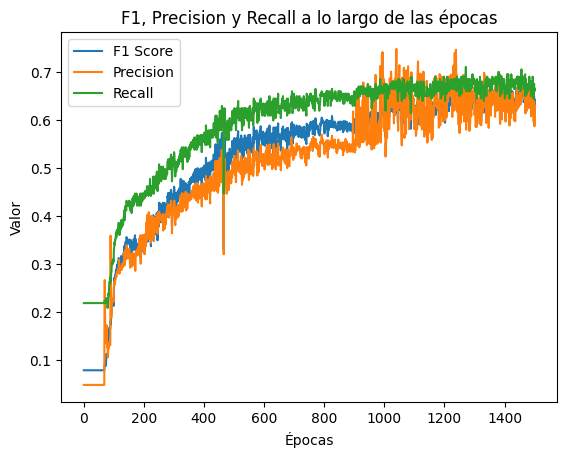

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 6)         168       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 6)         24        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 64, 64, 6)         60        
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 6)         24        
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 6)         42        
                                                        

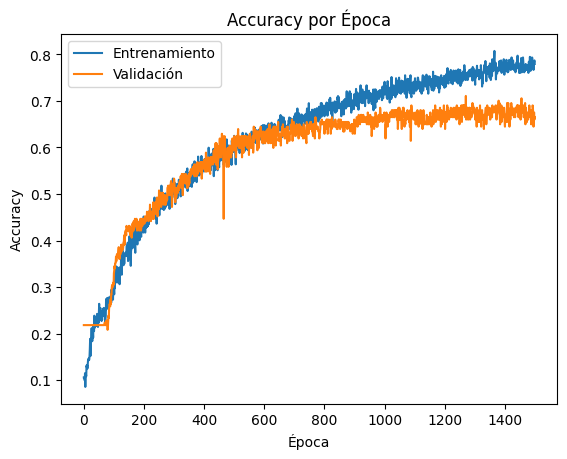

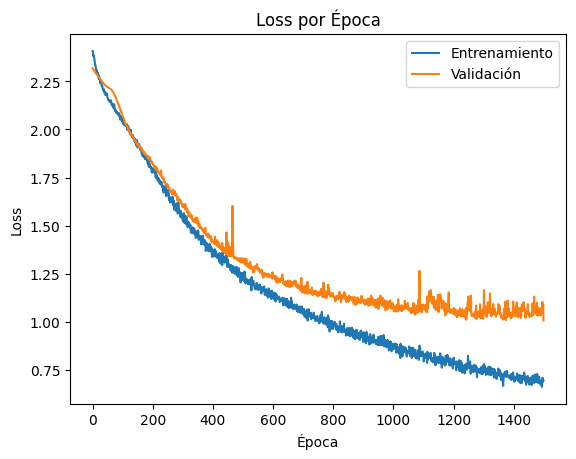

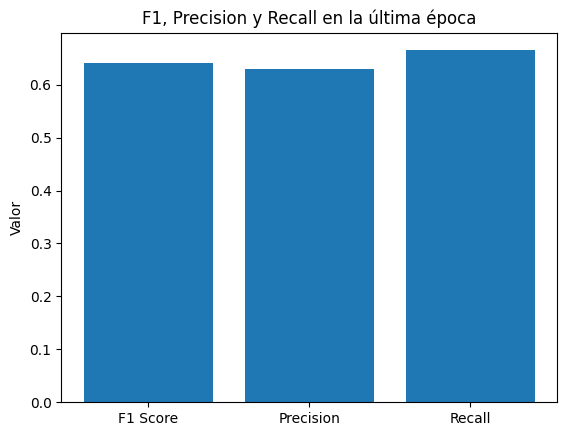

7/7 [==============================] - 0s 12ms/step


NameError: name 'accuracy_score' is not defined

In [2]:
# Graficar F1, Precision y Recall a lo largo de las épocas
epocas = range(1, len(metrics_callback.f1s) + 1)

plt.figure()
plt.plot(epocas, metrics_callback.f1s, label='F1 Score')
plt.plot(epocas, metrics_callback.precisions, label='Precision')
plt.plot(epocas, metrics_callback.recalls, label='Recall')
plt.title('F1, Precision y Recall a lo largo de las épocas')
plt.xlabel('Épocas')
plt.ylabel('Valor')
plt.legend()
plt.show()

# Resumen del modelo
model.summary()

import os
import cv2
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Función para calcular F1, Precision, y Recall
def calcular_metricas(model, imagenes_val, etiquetas_val):
    predicciones = model.predict(imagenes_val)
    predicciones_clases = np.argmax(predicciones, axis=1)
    
    f1 = f1_score(etiquetas_val, predicciones_clases, average='weighted')
    precision = precision_score(etiquetas_val, predicciones_clases, average='weighted')
    recall = recall_score(etiquetas_val, predicciones_clases, average='weighted')
    
    return f1, precision, recall

def calcular_flops(model):
    # Crear una función concreta del modelo
    imagen_de_prueba = tf.random.normal([1, 128, 128, 3])  # Imagen de prueba
    modelo_funcional = tf.function(lambda x: model(x))
    modelo_concreto = modelo_funcional.get_concrete_function(imagen_de_prueba)

    # Convertir el modelo concreto a un gráfico de TensorFlow
    frozen_func = convert_variables_to_constants_v2(modelo_concreto)
    frozen_func.graph.as_graph_def()

    # Utilizar tf.compat.v1.profiler para obtener el número de FLOPS
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    # Iniciar el profiler
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph, run_meta=run_meta, cmd='scope', options=opts)

    # Devolver los FLOPS
    return flops.total_float_ops  # Esta función devuelve el número total de operaciones de punto flotante


# Función para calcular la huella de memoria
def calcular_memoria_modelo(model):
    # Contar los parámetros del modelo
    total_params = model.count_params()
    
    # Asumiendo que los parámetros están almacenados en float32 (4 bytes por parámetro)
    bytes_por_param = 4
    memoria_total = total_params * bytes_por_param
    
    # Convertir a MB
    memoria_total_mb = memoria_total / (1024 ** 2)
    return memoria_total_mb

# Obtener métricas en el conjunto de validación
f1, precision, recall = calcular_metricas(model, imagenes_val, etiquetas_val)

# Obtener los parámetros del modelo
parametros = model.count_params()

# Extraer Accuracy y Loss de la última época
acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

# Calcular FLOPS y huella de memoria
flops = calcular_flops(model)
memoria_modelo = calcular_memoria_modelo(model)

# Imprimir la tabla con los resultados
print(f"Acc: {acc}, F1: {f1}, P: {precision}, R: {recall}, Loss: {loss}, Parámetros: {parametros}, FLOPS: {flops}, Memoria: {memoria_modelo:.2f} MB")

import pandas as pd

# Crear un diccionario con los resultados de la última época
resultados = {
    'Métrica': ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'Loss', 'Parámetros', 'FLOPS', 'Memoria (MB)'],
    'Valor': [acc, f1, precision, recall, loss, parametros, flops, memoria_modelo]
}

# Convertir el diccionario en un DataFrame de pandas
df_resultados = pd.DataFrame(resultados)

# Guardar la tabla en un archivo Excel
#ruta_excel = r"C:\Users\joshu\OneDrive\Desktop\MNJ2MPCK.xlsx"
#df_resultados.to_excel(ruta_excel, index=False)

# Mostrar el archivo guardado
#ruta_excel
# Graficar las métricas
epocas = range(len(history.history['accuracy']))

# Graficar Accuracy
plt.figure()
plt.plot(epocas, history.history['accuracy'], label='Entrenamiento')
plt.plot(epocas, history.history['val_accuracy'], label='Validación')
plt.title('Accuracy por Época')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Graficar Loss
plt.figure()
plt.plot(epocas, history.history['loss'], label='Entrenamiento')
plt.plot(epocas, history.history['val_loss'], label='Validación')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficar F1, Precision, Recall
metricas = ['F1 Score', 'Precision', 'Recall']
valores = [f1, precision, recall]

plt.figure()
plt.bar(metricas, valores)
plt.title('F1, Precision y Recall en la última época')
plt.ylabel('Valor')
plt.show()


# Realizar predicciones con el modelo
y_pred = model.predict(imagenes_val)
y_pred_clases = np.argmax(y_pred, axis=1)

# Calcular métricas de evaluación
acc_val = accuracy_score(etiquetas_val, y_pred_clases)

# Matriz de confusión de validación
matriz_confusion_val = confusion_matrix(etiquetas_val, y_pred_clases)

# Visualizar la matriz de confusión
ax = sn.heatmap(matriz_confusion_val, annot=True, cmap='Blues')
ax.set_title('Validation data Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Ajustar los labels de los ticks
ax.xaxis.set_ticklabels(['NE', 'HA', 'SA', 'SU', 'AN', 'DI', 'FE'])
ax.yaxis.set_ticklabels(['NE', 'HA', 'SA', 'SU', 'AN', 'DI', 'FE'])

plt.show()

# Informe de clasificación
target_names = ['NE', 'HA', 'SA', 'SU', 'AN', 'DI', 'FE']
report = classification_report(etiquetas_val, y_pred_clases, digits=4, target_names=target_names)
print(report)


VISUALIZACIONES DE PESO Y DATOS ESTADISTICOS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from scipy.stats import kurtosis, skew

# Modelo original
model_input = model.input
layer_outputs = [layer.output for layer in model.layers]  # Obtenemos las salidas de todas las capas
activation_model = Model(inputs=model_input, outputs=layer_outputs)  # Modelo para activaciones

# Escoge una imagen del conjunto de entrenamiento para visualizar
img = imagenes_train[0]  # Puedes cambiar el índice para seleccionar otras imágenes
img = img.reshape(1, 128, 128, 3)  # Cambia el tamaño según la entrada del modelo

# Obtener las activaciones de todas las capas
activations = activation_model.predict(img)

# Visualizar activaciones para cada capa
images_per_row = 8

for layer_name, layer_activation in zip([layer.name for layer in model.layers], activations):
    print(f"Visualizando activaciones para la capa: {layer_name}")
    
    if len(layer_activation.shape) == 4:  # Si la salida es 4D (batch_size, height, width, channels)
        n_features = layer_activation.shape[-1]  # Número de filtros en la capa
        size = layer_activation.shape[1]  # Tamaño espacial de los mapas de características

        n_cols = n_features // images_per_row  # Número de columnas para organizar los gráficos
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean()  # Normalizar para mejorar la visualización
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Visualizar el grid de activaciones
        scale = 1.0 / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()
    
    elif len(layer_activation.shape) == 2:  # Si la salida es 2D (batch_size, features)
        plt.figure(figsize=(10, 4))
        plt.title(f"Activaciones de la capa {layer_name}")
        plt.plot(layer_activation[0])
        plt.show()

    else:
        print(f"No se puede visualizar la activación de la capa {layer_name} de dimensión {len(layer_activation.shape)}")

# Visualización de pesos para todas las capas
for layer in model.layers:
    try:
        pesos, sesgos = layer.get_weights()

        # Número de filtros en la capa
        num_filtros = pesos.shape[-1]

        # Tamaño del grid para visualizar los filtros
        grid_size = int(np.ceil(np.sqrt(num_filtros)))

        # Visualizar los filtros
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        for i in range(num_filtros):
            filtro = pesos[:, :, 0, i]  # Extrayendo el filtro
            ax = axes[i // grid_size, i % grid_size]
            ax.imshow(filtro, cmap='viridis', aspect='auto')
            ax.axis('off')
        plt.suptitle(f'Pesos de la capa {layer.name}')
        plt.show()
    except:
        # Algunas capas pueden no tener pesos, como MaxPooling2D
        continue

# Cálculo y visualización de estadísticas de pesos para todas las capas
def calcular_entropia(pesos):
    hist, _ = np.histogram(pesos, bins=256, density=True)
    hist += 1e-7  # Evitar log(0)
    return -np.sum(hist * np.log2(hist))

for layer in model.layers:
    try:
        pesos, _ = layer.get_weights()

        # Calcular estadísticas
        media = np.mean(pesos)
        varianza = np.var(pesos)
        asimetria = skew(pesos.flatten())
        curtosis_val = kurtosis(pesos.flatten())
        entropia = calcular_entropia(pesos)
        rango_val = np.ptp(pesos)

        # Mostrar las estadísticas
        print(f"Capa: {layer.name}")
        print(f"  Media: {media}")
        print(f"  Varianza: {varianza}")
        print(f"  Asimetría: {asimetria}")
        print(f"  Curtosis: {curtosis_val}")
        print(f"  Entropía: {entropia}")
        print(f"  Rango: {rango_val}")

        # Graficar la evolución de las estadísticas
        estadisticas = ['Media', 'Varianza', 'Asimetría', 'Curtosis', 'Entropía', 'Rango']
        valores = [media, varianza, asimetria, curtosis_val, entropia, rango_val]

        plt.figure(figsize=(10, 6))
        plt.bar(estadisticas, valores, color='blue')
        plt.title(f'Estadísticas de los Pesos de la Capa {layer.name}')
        plt.ylabel('Valor')
        plt.show()

    except:
        # Algunas capas pueden no tener pesos, como MaxPooling2D
        continue




In [ ]:
model.summary()